Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data colon
url = "https://raw.githubusercontent.com/jamessaldo/final-task/master/colonTumor.data"
data_colon = pd.read_csv(url, header=None)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data colon Tumor:',data_colon.isnull().sum().sum())

Total Missing Value pada Data colon Tumor: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data colon
data_new_colon = data_colon.drop([2000],axis=1)
scaler = MinMaxScaler()
data_new_colon = scaler.fit_transform(data_new_colon)
data_new_colon = DataFrame(data_new_colon)
data_new_colon['label'] = list(data_colon[2000])
dic = {'negative':1,'positive':0}
data_new_colon.replace(dic,inplace=True)

# 2. Define Reusable Function

## FLNN Classifier

In [5]:
def FLNN_Classifier(data_train, data_test, cancer_name, orde):
    start = timeit.default_timer()
    
    x_data_train = data_train.drop(['label'],axis=1)
    y_data_train = data_train['label']
    x_data_test = data_test.drop(['label'],axis=1)
    y_data_test = data_test['label']
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for x in range(1, orde+1):
        pn = legendre(x)
        y_orde = pn(x_data_train)
        df_train = pd.concat([df_train, y_orde], axis=1)
        
        pn = legendre(x)
        y_orde = pn(x_data_test)
        df_test = pd.concat([df_test, y_orde], axis=1)

    df_train.columns = ["Attribut"+str(i) for i in range(len(df_train.columns))]
    df_train['label'] = y_data_train.reset_index().label
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1].values
    y_train = df_train.iloc[:, len(df_train.columns)-1].values
    
    df_test.columns = ["Attribut"+str(i) for i in range(len(df_test.columns))]
    df_test['label'] = y_data_test.reset_index().label
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1].values
    y_test = df_test.iloc[:, len(df_test.columns)-1].values

    # Melakukan proses klasifikasi FLNN
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_train.columns)-1, kernel_initializer = 'uniform', input_dim = len(df_train.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    akurasi = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')

    print("Akurasi : ", akurasi)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

    stop = timeit.default_timer()
    print('Running Time: ', stop - start) 
    return akurasi, F1, stop-start

## Genetic Algorithm

In [6]:
# define parameters
mutationRate = 0.01
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, data_train, data_test, orde): #using Entropy as fitness
  datasetGA_train = pd.DataFrame()
  datasetGA_test = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(data_train.columns)-1):
    if indv[i] == 1:
      datasetGA_train[idxDatasetGA] = data_train[i]
      datasetGA_test[idxDatasetGA] = data_test[i]
      idxDatasetGA += 1
  datasetGA_train['label'] = data_train['label']
  datasetGA_test['label'] = data_test['label']
  Acc_score, F1_score, rt = FLNN_Classifier(datasetGA_train, datasetGA_test, "colon cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [7]:
def GeneticAlgorithm(data_train, data_test, orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(data_train.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(data_train.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], data_train, data_test, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(data_train.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(data_train.columns[i])
  dataset_GA_train = data_train.drop(listDrop, axis = 1)
  dataset_GA_test = data_test.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return bestAcc, bestF1, bestNFeature, stop-start

# 3. Feature Selection with IG

## colon

In [8]:
# Feature Selection using Mutual Information
def InformationGain(data_train, data_test):
    start = timeit.default_timer()
    data_X_train = data_train.drop(['label'],axis=1)
    data_Y_train = data_train['label']
    
    data_X_test = data_test.drop(['label'],axis=1)
    data_Y_test = data_test['label']

    sel_k_best = SelectKBest(mutual_info_classif, k=100)
    sel_k_best.fit(data_X_train, data_Y_train)
    data_train_X_new = sel_k_best.transform(data_X_train)
    data_test_X_new = sel_k_best.transform(data_X_test)

    colon_IG_train = pd.DataFrame(data_train_X_new)
    colon_IG_train['label'] = data_Y_train
    colon_IG_test = pd.DataFrame(data_test_X_new)
    colon_IG_test['label'] = data_Y_test
    
    print("train: ",colon_IG_train.shape)
    print("test: ",colon_IG_test.shape)
    stop = timeit.default_timer()
    print("Running Time: ", stop-start)
    return colon_IG_train, colon_IG_test, stop-start

# 4. Classification

Train :  [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test :  [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
train:  (49, 101)
test:  (13, 101)
Running Time:  1.8746210000000003
colon + IG Orde 2
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



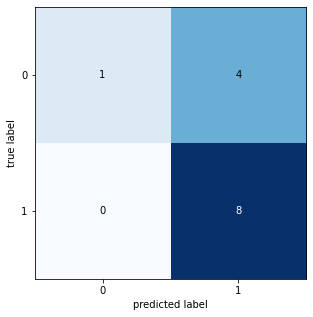

Running Time:  1.7367489000000003
colon + IG Orde 3
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



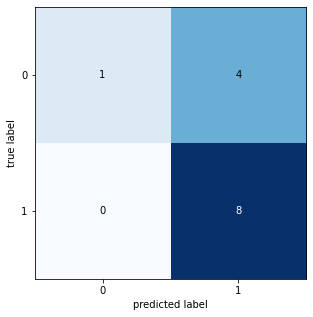

Running Time:  1.5156172000000012
colon + IG Orde 4
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



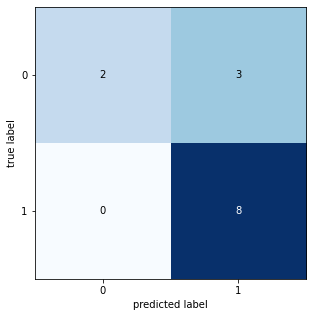

Running Time:  1.5255168999999995
colon + IG + GA Orde 2
Generation : 0
gene : [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



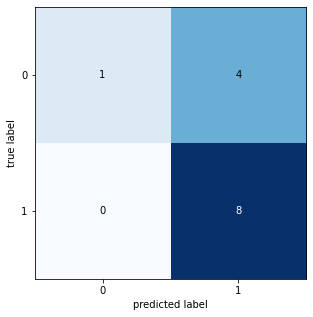

Running Time:  1.5274991
gene : [0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6153846153846154
F1_Score :  0.5112781954887218
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.64      0.88      0.74         8

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13



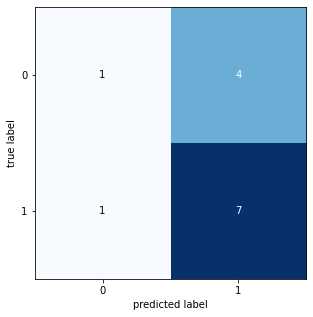

Running Time:  1.5404595000000008
gene : [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



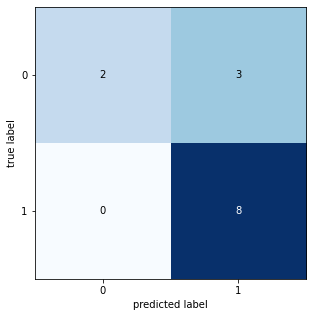

Running Time:  1.6457517
gene : [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



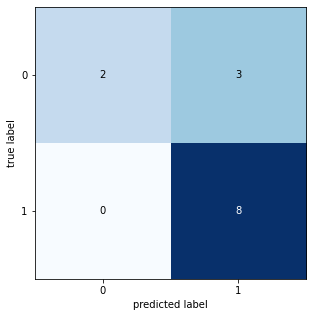

Running Time:  1.4738466000000017
gene : [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



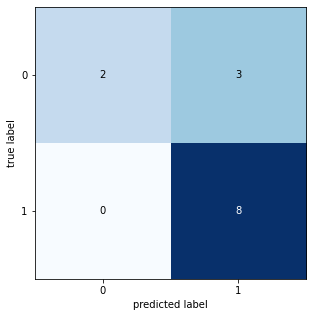

Running Time:  1.4845228000000006
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



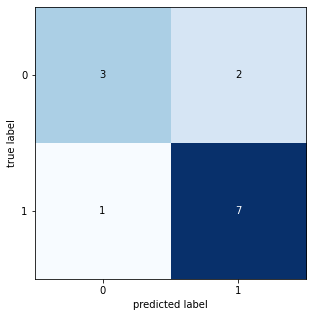

Running Time:  1.4772015999999972
gene : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6153846153846154
F1_Score :  0.5112781954887218
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.64      0.88      0.74         8

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13



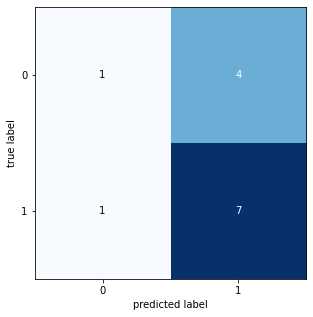

Running Time:  1.485253499999999
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



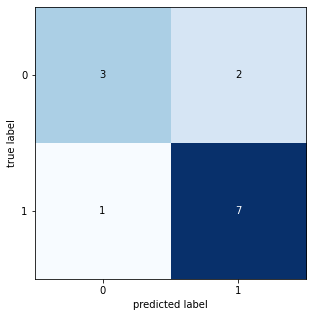

Running Time:  1.4687596999999997
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



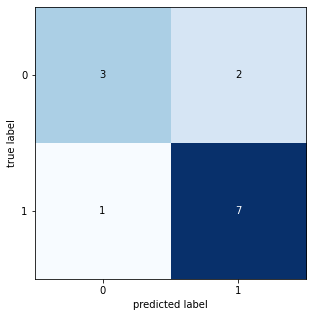

Running Time:  1.4693768000000027
gene : [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



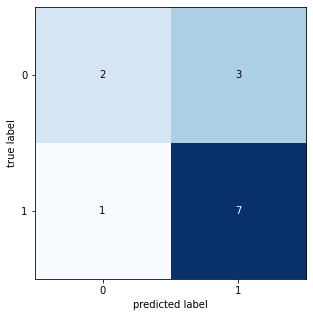

Running Time:  1.4736665000000002
gen terbaik : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.7450980392156863  || Akurasi terbaik : 0.7692307692307693  || jumlah fitur : 50

Generation : 1
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pr

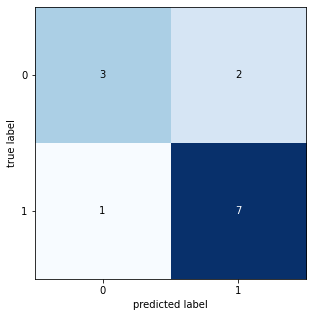

Running Time:  1.6297005999999996
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



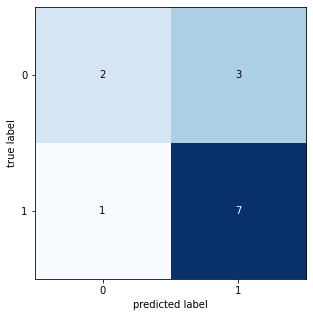

Running Time:  1.4719831000000028
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



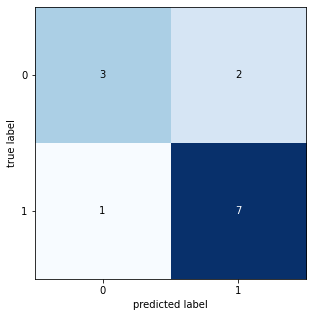

Running Time:  1.4644370999999978
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



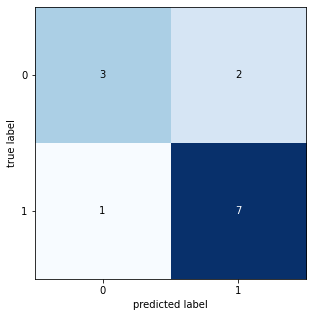

Running Time:  1.4684247999999975
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



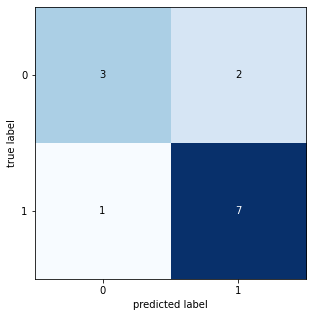

Running Time:  1.4823572000000027
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



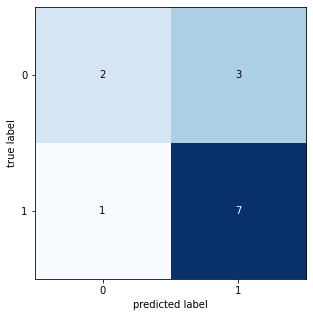

Running Time:  1.458469000000001
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



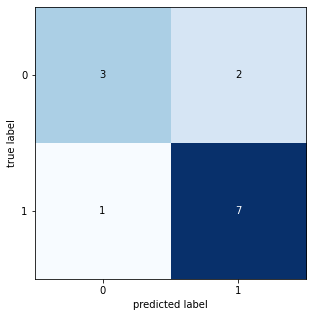

Running Time:  1.4574500000000015
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



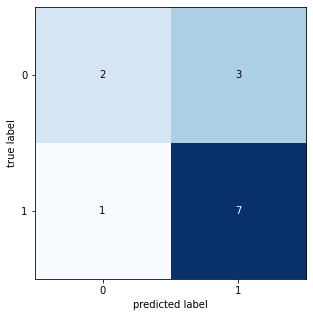

Running Time:  1.6316045000000017
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



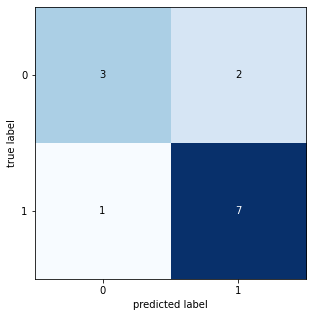

Running Time:  1.4684241
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



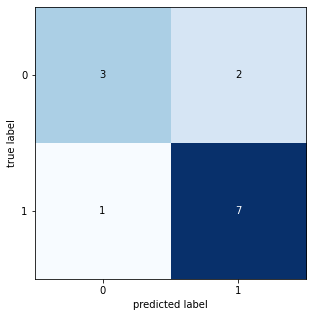

Running Time:  1.4678348999999997
gen terbaik : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.7450980392156863  || Akurasi terbaik : 0.7692307692307693  || jumlah fitur : 48

Generation : 2
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              pr

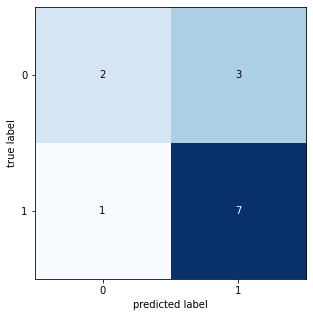

Running Time:  1.4756284999999991
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



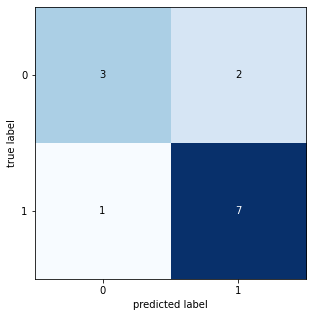

Running Time:  1.471770499999998
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



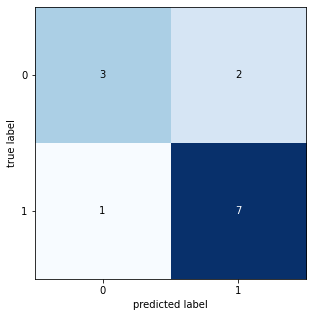

Running Time:  1.4759663000000032
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



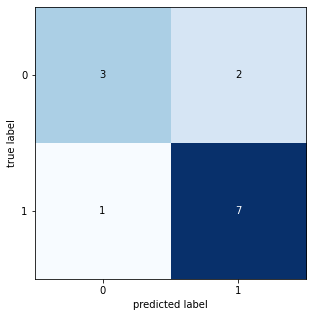

Running Time:  1.4708982000000006
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



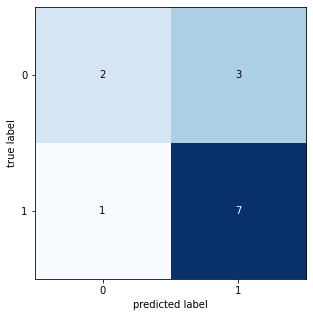

Running Time:  1.4659042999999983
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



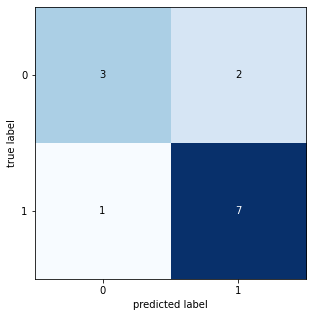

Running Time:  1.634036700000003
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



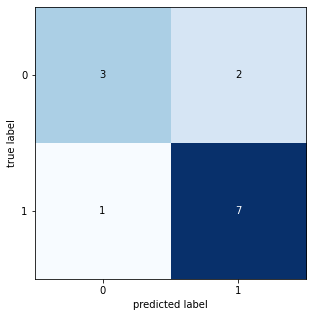

Running Time:  1.4701975999999988
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



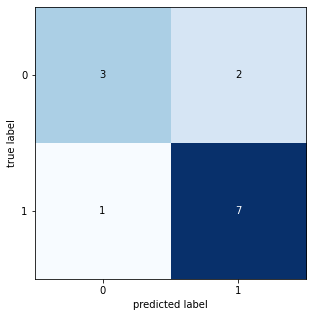

Running Time:  1.4719645000000057
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



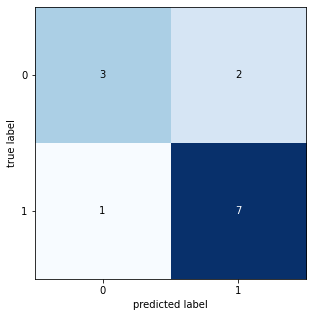

Running Time:  1.459357599999997
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



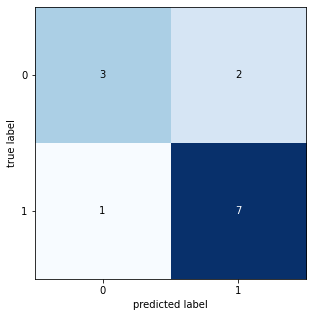

Running Time:  1.466654399999996
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.7450980392156863  || Akurasi terbaik : 0.7692307692307693  || jumlah fitur : 50

Generation : 3
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pre

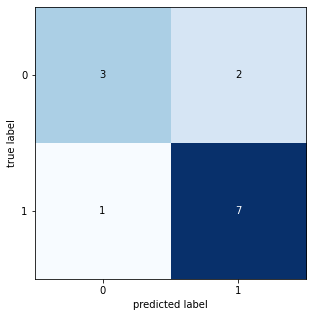

Running Time:  1.469706500000001
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



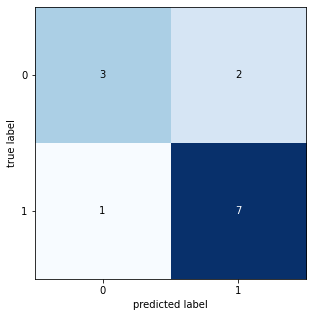

Running Time:  1.464790800000003
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



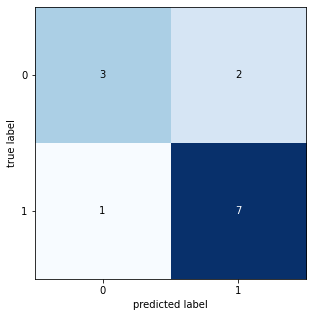

Running Time:  1.4693208000000055
gene : [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



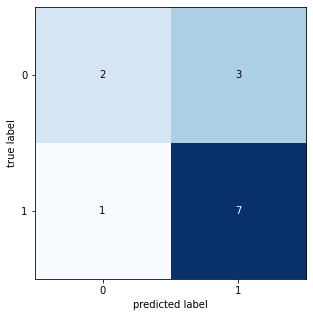

Running Time:  1.648622699999997
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



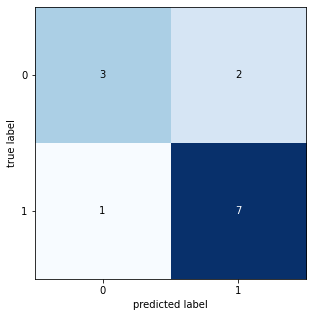

Running Time:  1.4617700000000013
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



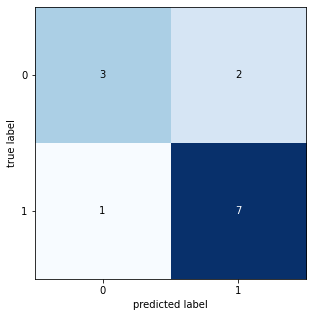

Running Time:  1.470819800000001
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



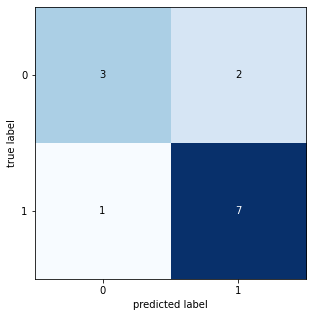

Running Time:  1.4727153999999985
gene : [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



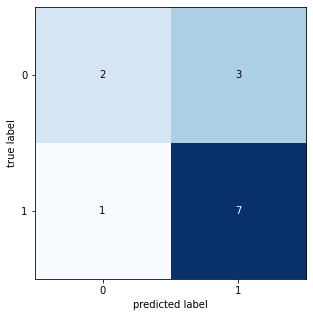

Running Time:  1.4675617000000045
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



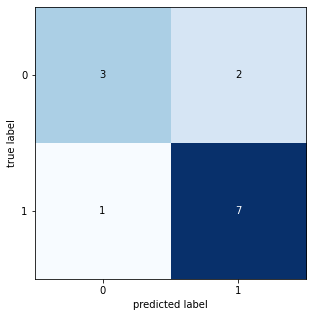

Running Time:  1.4666595999999998
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



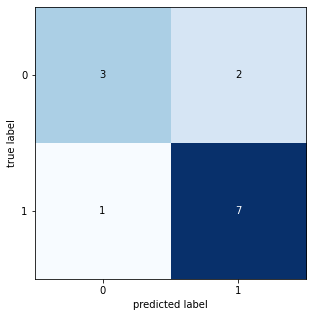

Running Time:  1.4613338000000056
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.7450980392156863  || Akurasi terbaik : 0.7692307692307693  || jumlah fitur : 48

Generation : 4
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pr

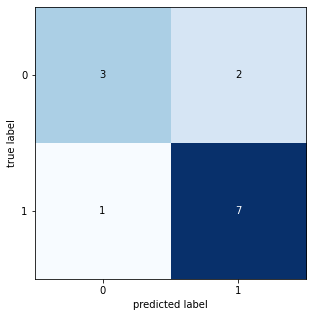

Running Time:  1.4622943999999904
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



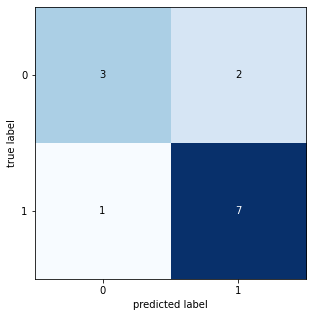

Running Time:  1.638030299999997
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



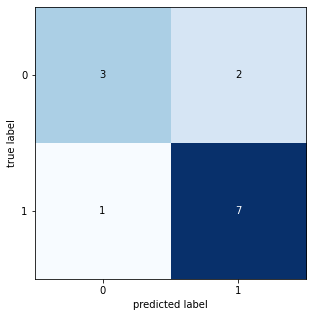

Running Time:  1.4652180000000072
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



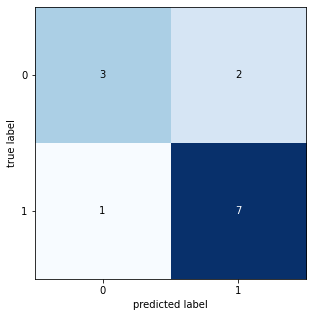

Running Time:  1.4655682999999868
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



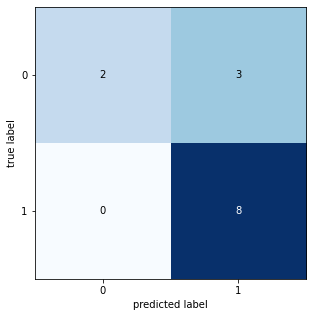

Running Time:  1.4767962000000097
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



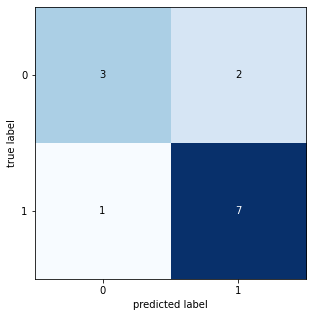

Running Time:  1.4740156000000013
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



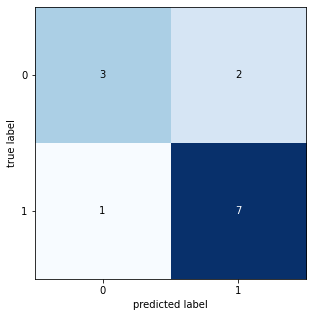

Running Time:  1.4592370999999957
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



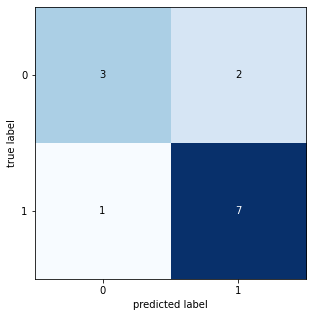

Running Time:  1.4979974000000027
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



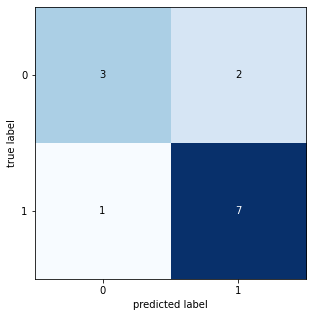

Running Time:  1.493179700000013
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



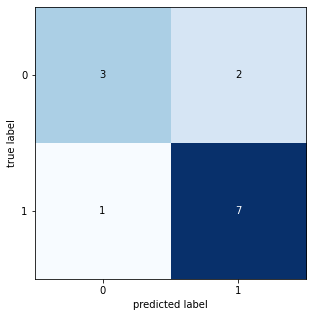

Running Time:  1.6335622
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.7450980392156863  || Akurasi terbaik : 0.7692307692307693  || jumlah fitur : 49

Running Time:  75.728521
colon + IG + GA Orde 3
Generation : 0
gene : [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score

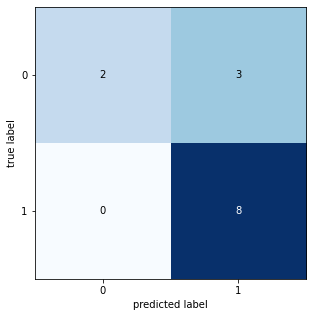

Running Time:  1.4916426999999999
gene : [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



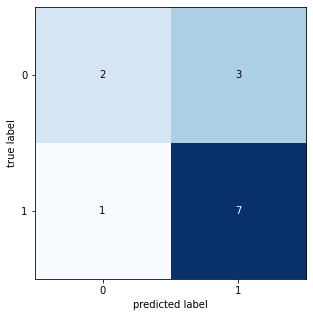

Running Time:  1.4743833999999936
gene : [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



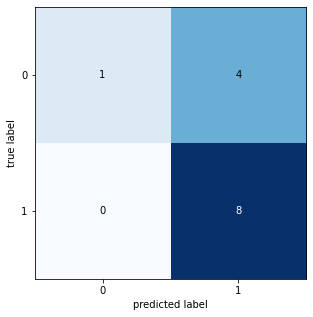

Running Time:  1.4825693000000086
gene : [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



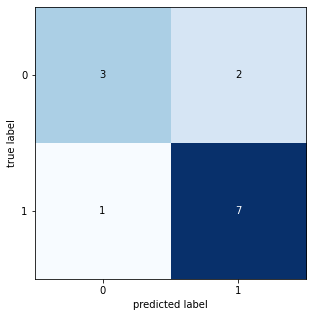

Running Time:  1.475450500000008
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



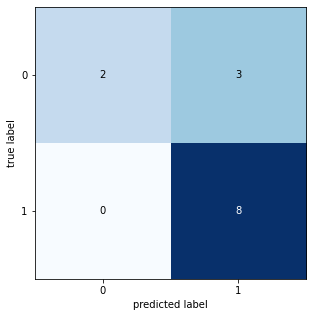

Running Time:  1.4775240999999966
gene : [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



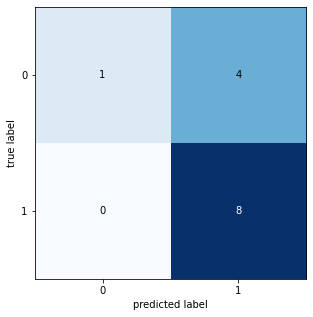

Running Time:  1.4759362000000067
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



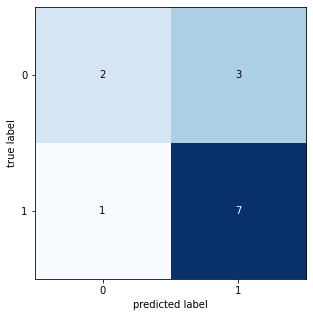

Running Time:  1.6319406000000072
gene : [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



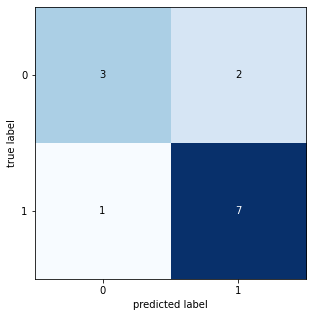

Running Time:  1.4770321000000024
gene : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



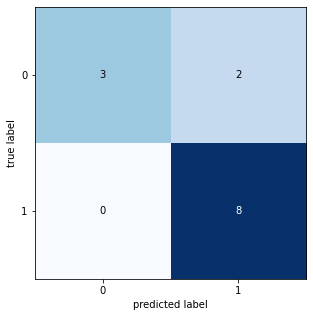

Running Time:  1.4725370000000026
gene : [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



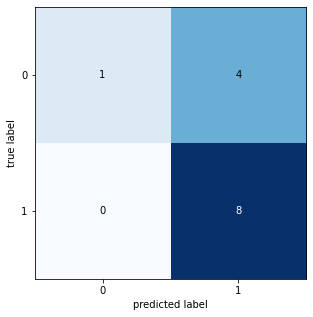

Running Time:  1.4769238999999885
gen terbaik : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.8194444444444444  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 50

Generation : 1
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              pr

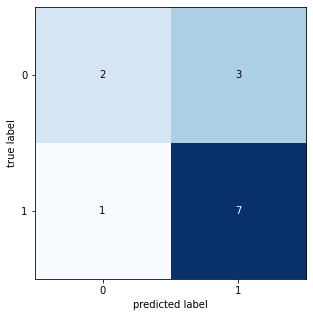

Running Time:  1.4788080000000008
gene : [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



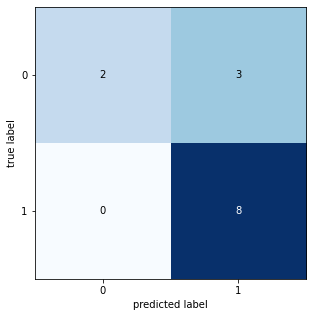

Running Time:  1.4800819000000018
gene : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



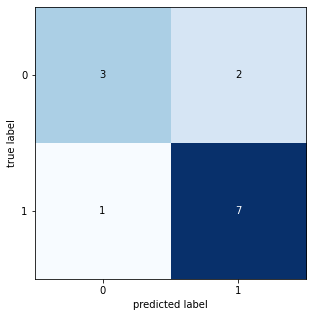

Running Time:  1.4755574999999936
gene : [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



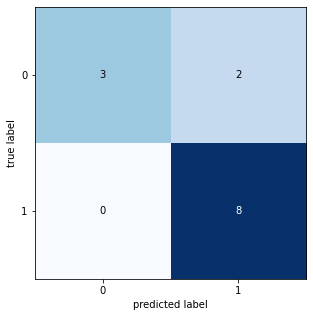

Running Time:  1.4814797000000084
gene : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.89      1.00      0.94         8

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



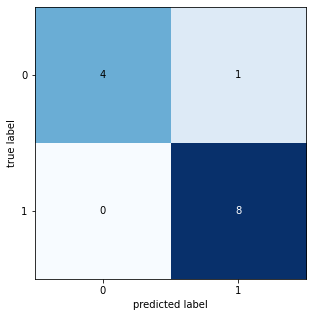

Running Time:  1.6468722999999983
gene : [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



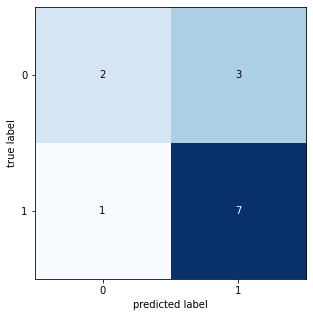

Running Time:  1.4859414999999956
gene : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



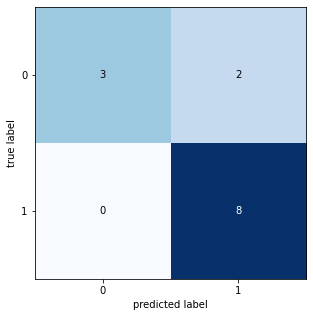

Running Time:  1.4778340000000014
gene : [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



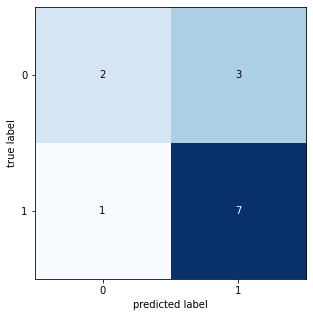

Running Time:  1.4881469000000038
gene : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



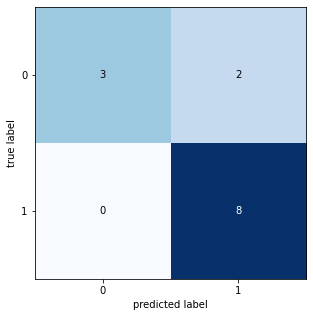

Running Time:  1.4840020999999979
gene : [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



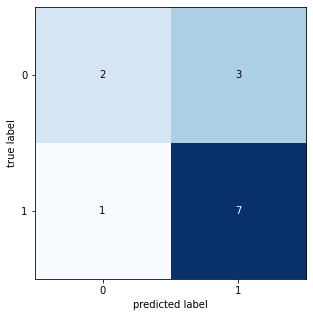

Running Time:  1.4709328
gen terbaik : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.9150326797385622  || Akurasi terbaik : 0.9230769230769231  || jumlah fitur : 44

Running Time:  30.269509
colon + IG + GA Orde 4
Generation : 0
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score

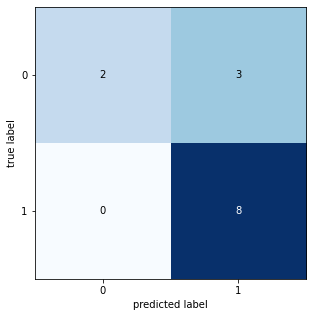

Running Time:  1.4961032000000074
gene : [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



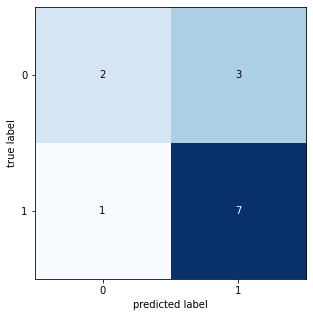

Running Time:  1.4916395000000051
gene : [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



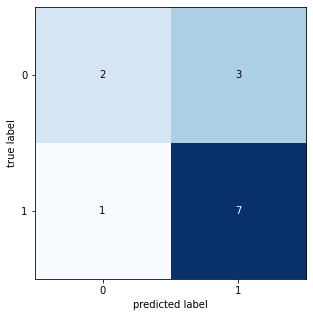

Running Time:  1.652458199999998
gene : [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



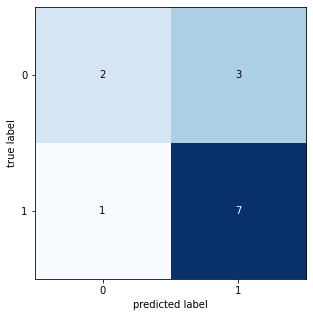

Running Time:  1.492692500000004
gene : [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



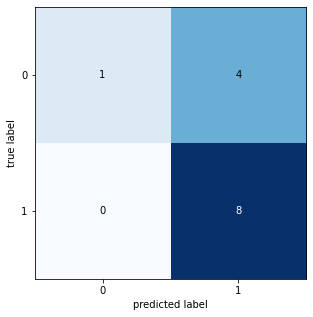

Running Time:  1.4908962999999886
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



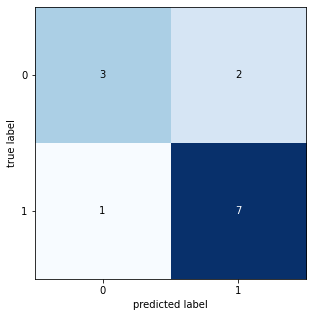

Running Time:  1.4902828999999969
gene : [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



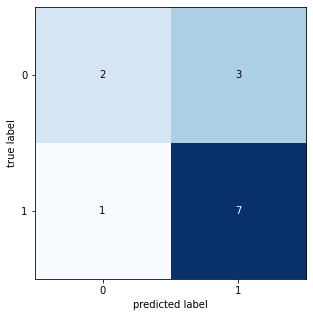

Running Time:  1.4941941999999955
gene : [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



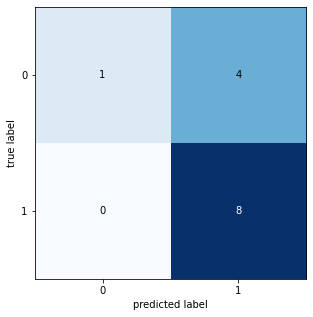

Running Time:  1.4942180000000036
gene : [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6153846153846154
F1_Score :  0.5112781954887218
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.64      0.88      0.74         8

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13



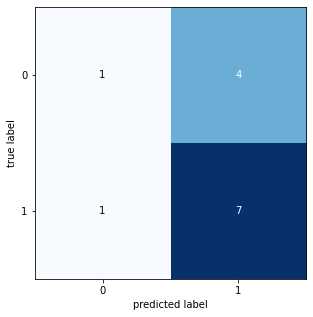

Running Time:  1.482772600000004
gene : [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



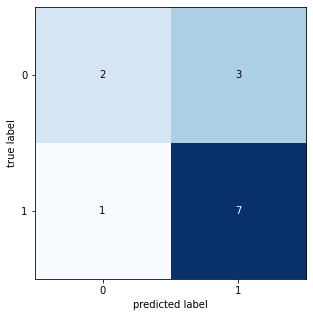

Running Time:  1.6374351000000047
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.7450980392156863  || Akurasi terbaik : 0.7692307692307693  || jumlah fitur : 58

Generation : 1
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              pr

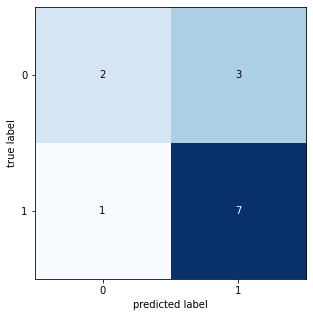

Running Time:  1.492765300000002
gene : [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9212121212121211
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.88      0.93         8

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13



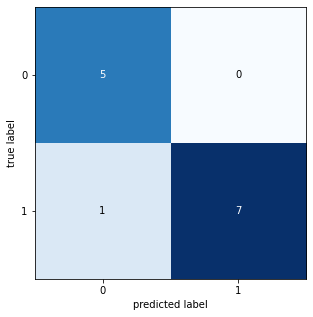

Running Time:  1.4845173999999872
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



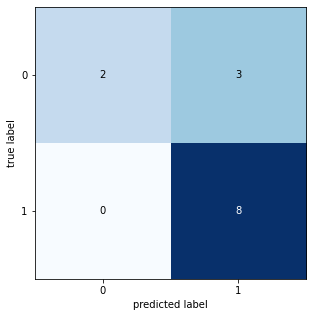

Running Time:  1.501231099999984
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



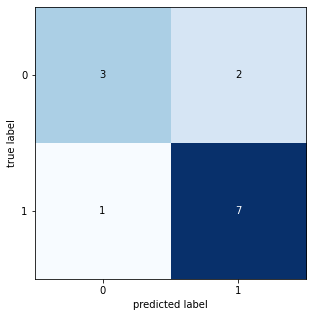

Running Time:  1.495040700000004
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.89      1.00      0.94         8

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



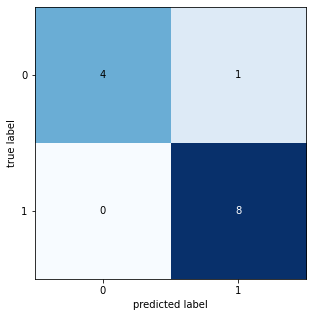

Running Time:  1.4905713999999932
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



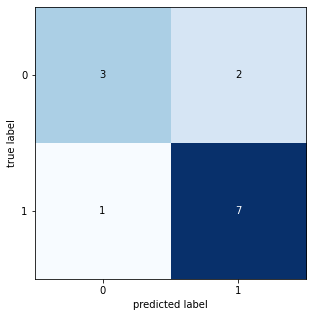

Running Time:  1.4865854999999897
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



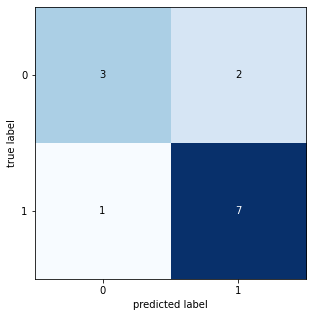

Running Time:  1.4940073999999868
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



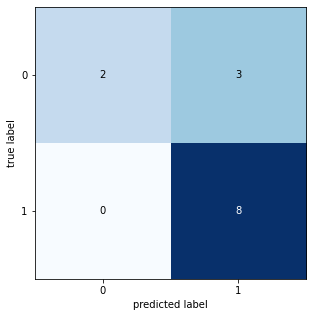

Running Time:  1.6706331000000034
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



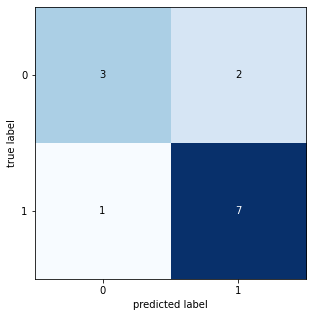

Running Time:  1.4925462999999866
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



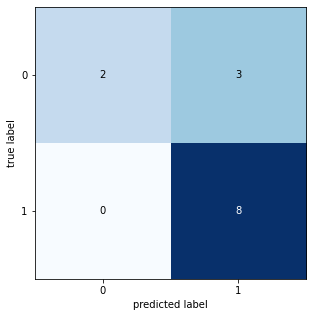

Running Time:  1.496930600000013
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.9212121212121211  || Akurasi terbaik : 0.9230769230769231  || jumlah fitur : 50

Running Time:  30.71276180000001
Train :  [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test :  [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
train:  (49, 101)
test:  (13, 101)
Running Time:  1.872059400000012
colon + IG Orde 2
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
            

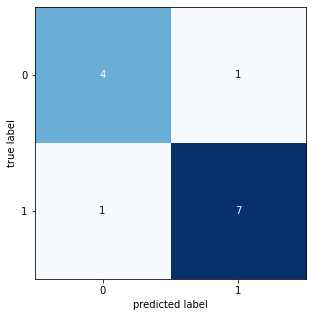

Running Time:  1.5002126999999916
colon + IG Orde 3
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



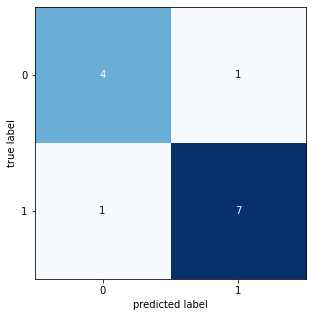

Running Time:  1.5040022999999962
colon + IG Orde 4
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



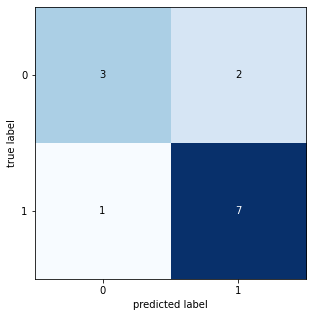

Running Time:  1.5173023000000114
colon + IG + GA Orde 2
Generation : 0
gene : [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



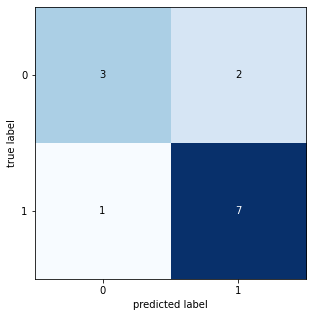

Running Time:  1.4757270000000062
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



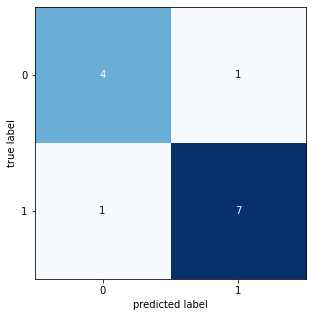

Running Time:  1.6132306000000085
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



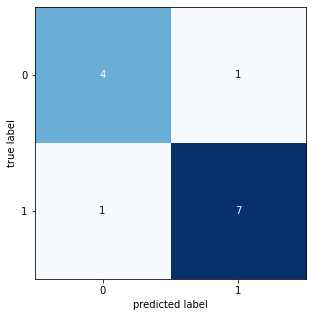

Running Time:  1.4701483000000053
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



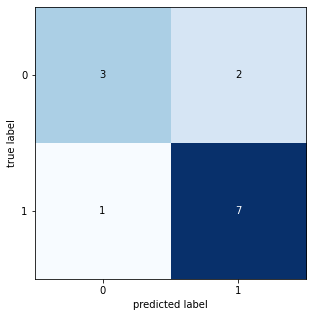

Running Time:  1.4703753999999947
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



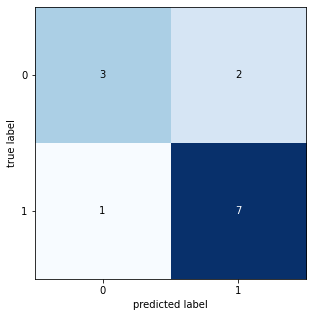

Running Time:  1.4806429000000207
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



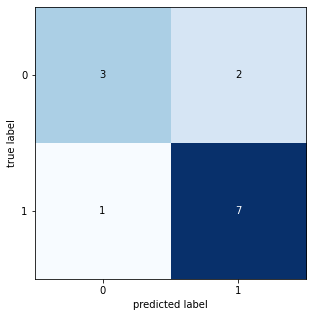

Running Time:  1.4760907000000145
gene : [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



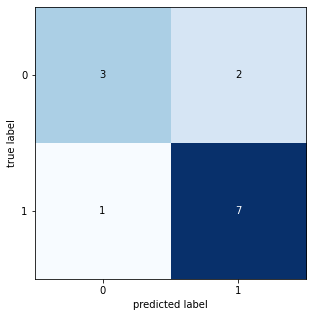

Running Time:  1.4754741000000138
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



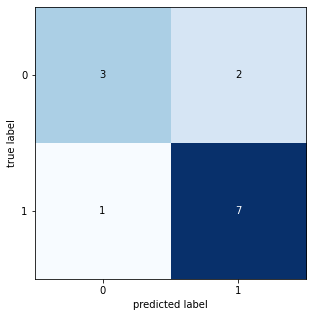

Running Time:  1.487806599999999
gene : [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



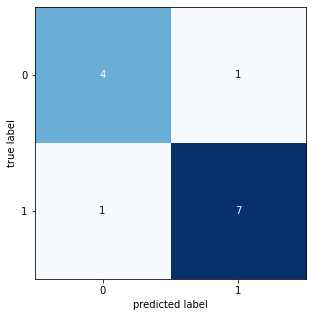

Running Time:  1.4771908999999823
gene : [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



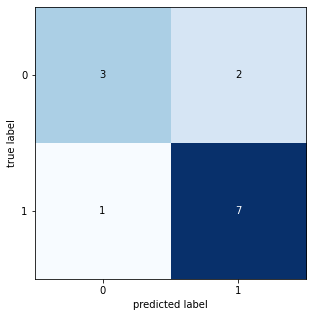

Running Time:  1.6500765999999771
gen terbaik : [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 50

Generation : 1
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pr

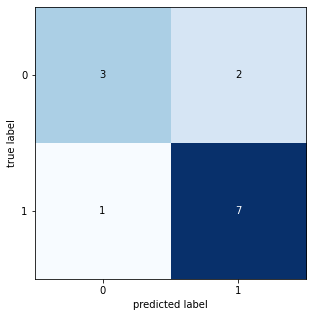

Running Time:  1.4775475999999799
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



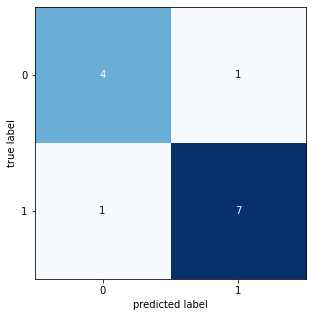

Running Time:  1.4750741999999946
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



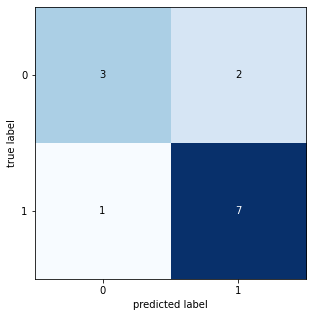

Running Time:  1.4842979999999955
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



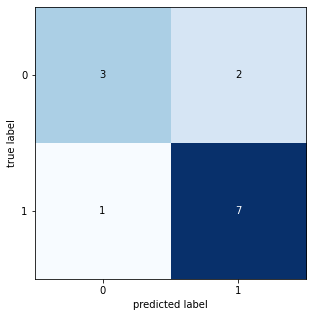

Running Time:  1.4849973999999975
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



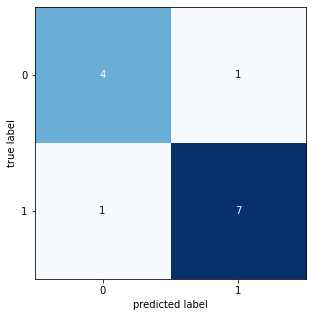

Running Time:  1.476257000000004
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



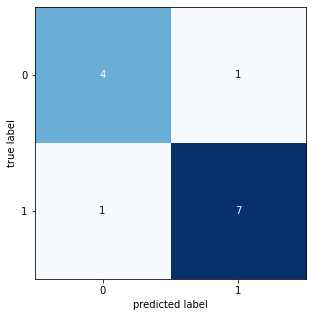

Running Time:  1.4722647000000109
gene : [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



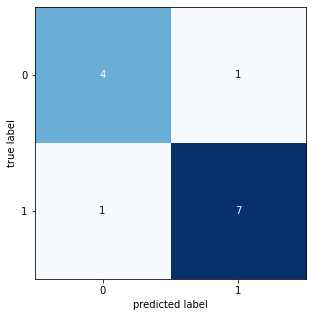

Running Time:  1.4744135999999912
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



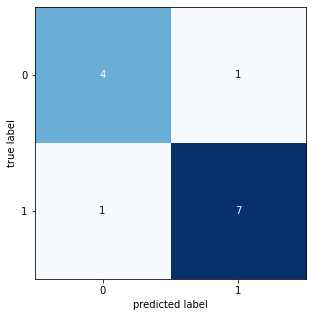

Running Time:  1.6525124000000062
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



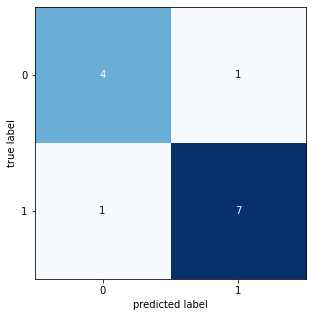

Running Time:  1.4770891999999947
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



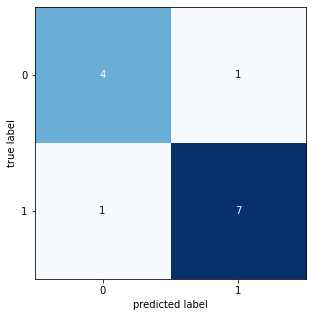

Running Time:  1.4800470999999789
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 48

Generation : 2
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

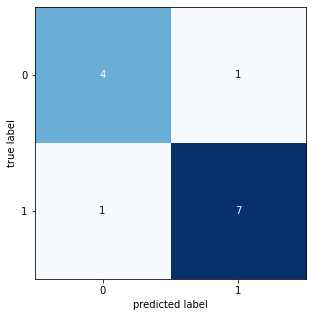

Running Time:  1.474751700000013
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



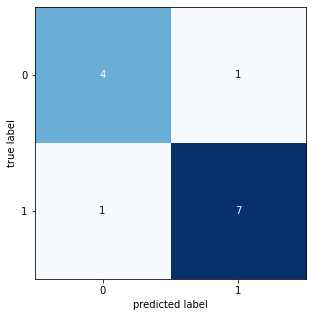

Running Time:  1.4796808000000112
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



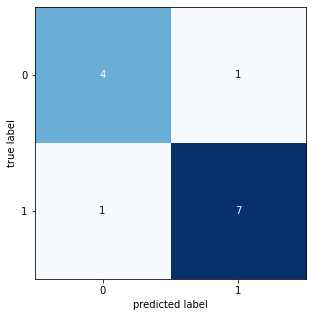

Running Time:  1.4806111999999985
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



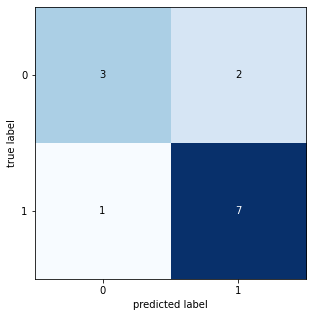

Running Time:  1.5263058999999828
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



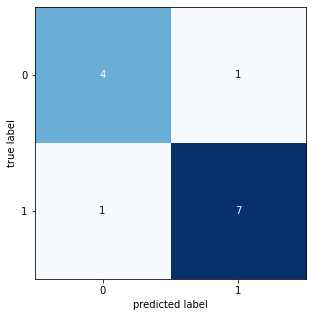

Running Time:  1.4749979999999994
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



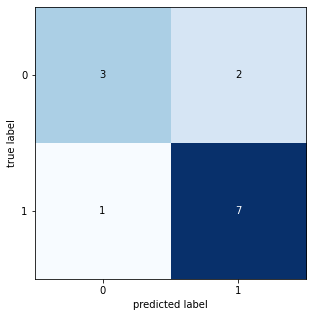

Running Time:  1.64258319999999
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



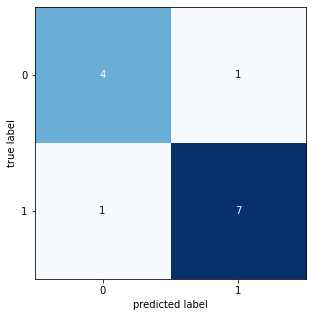

Running Time:  1.4655340000000194
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



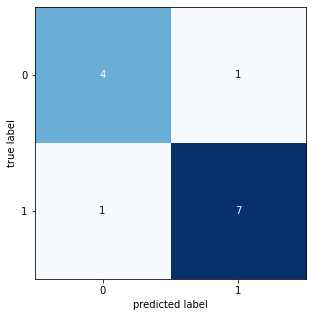

Running Time:  1.4831776999999988
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



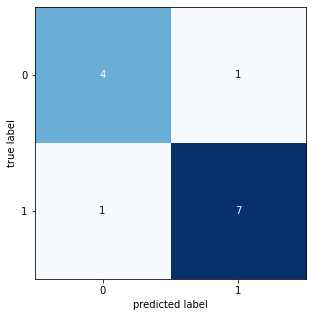

Running Time:  1.4784762999999828
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



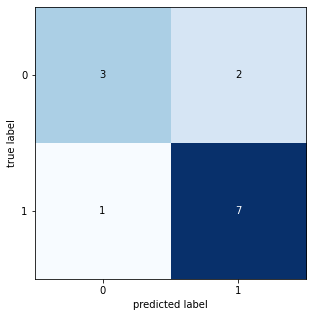

Running Time:  1.4818941999999993
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 54

Generation : 3
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pr

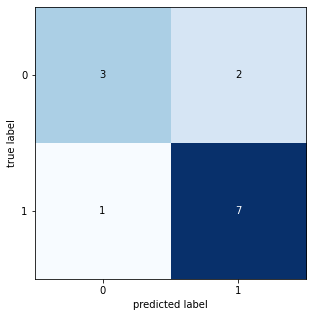

Running Time:  1.487107999999978
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



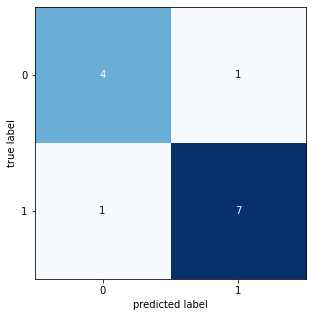

Running Time:  1.4759353999999973
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



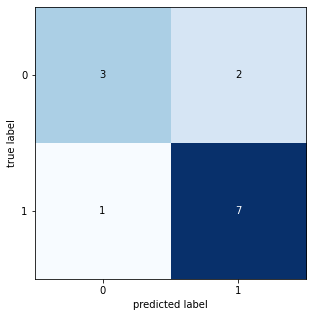

Running Time:  1.4582856999999763
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



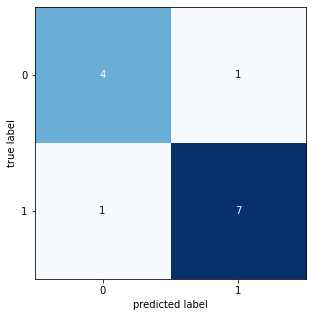

Running Time:  1.6655901000000028
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



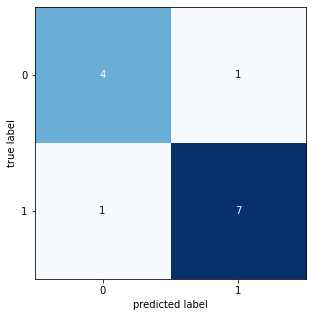

Running Time:  1.4699653999999782
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



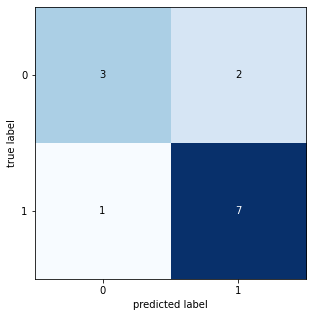

Running Time:  1.4726603999999952
gene : [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



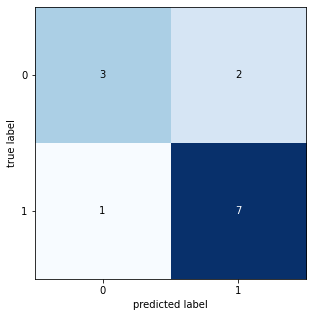

Running Time:  1.4809226000000137
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



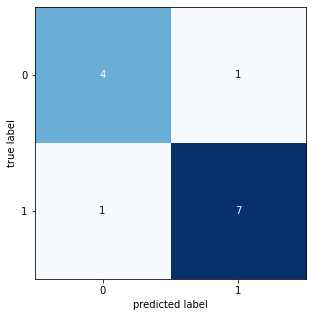

Running Time:  1.47411120000001
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



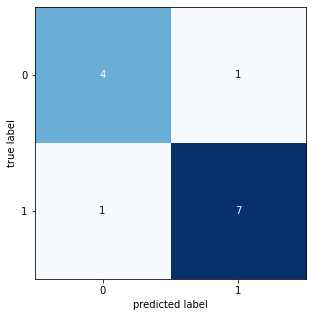

Running Time:  1.4773801000000049
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



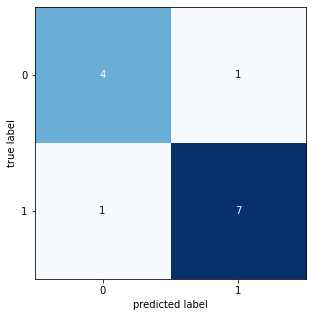

Running Time:  1.4798708000000147
gen terbaik : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 41

Generation : 4
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

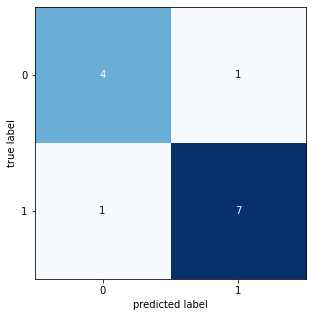

Running Time:  1.4725152000000037
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



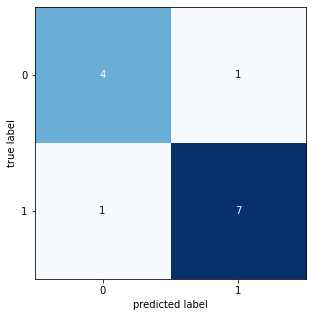

Running Time:  1.6626971000000026
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



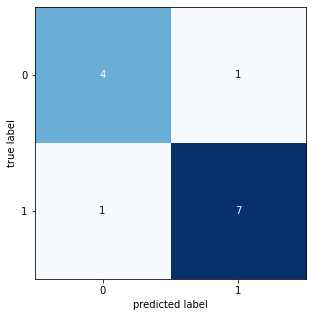

Running Time:  1.4827463000000023
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



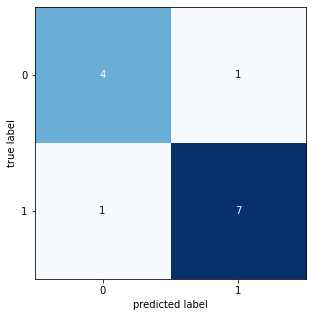

Running Time:  1.4841969999999947
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



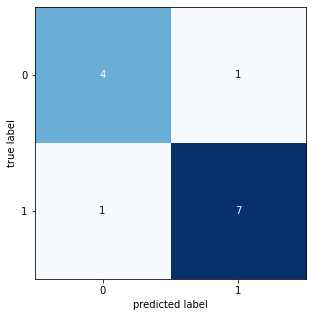

Running Time:  1.4766153999999858
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



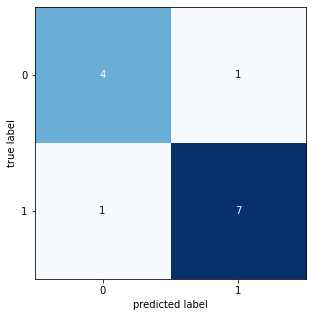

Running Time:  1.4847000000000037
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



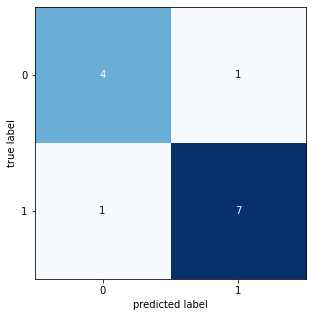

Running Time:  1.4799733000000117
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



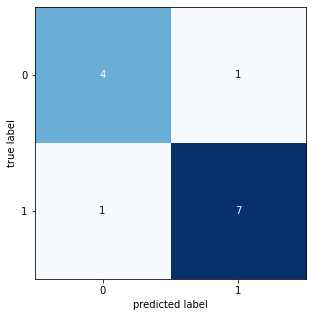

Running Time:  1.479574299999996
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



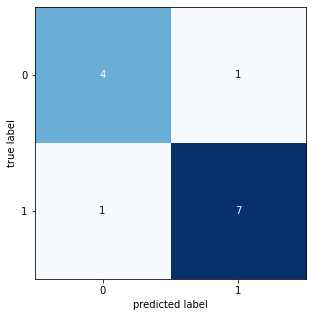

Running Time:  1.469928600000003
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



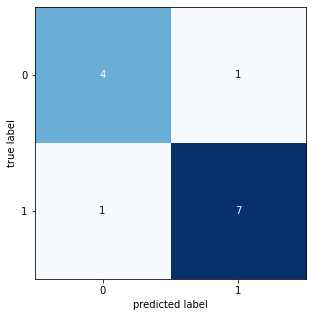

Running Time:  1.6503088000000048
gen terbaik : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 39

Running Time:  75.9591815
colon + IG + GA Orde 3
Generation : 0
gene : [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.769230769230769

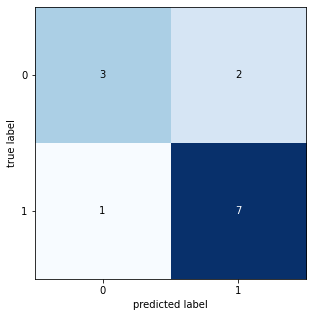

Running Time:  1.4848752999999988
gene : [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



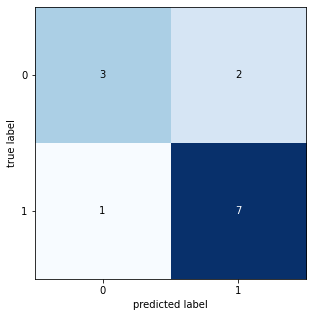

Running Time:  1.4943317999999977
gene : [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



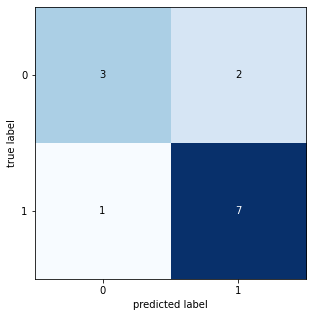

Running Time:  1.4887214000000029
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



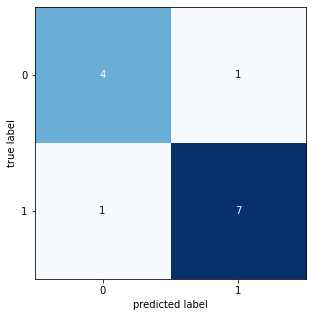

Running Time:  1.4834830000000068
gene : [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



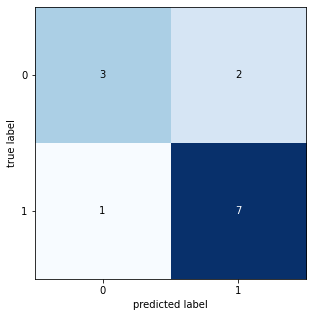

Running Time:  1.493046800000002
gene : [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



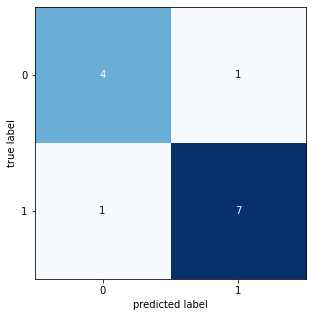

Running Time:  1.4850718000000143
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



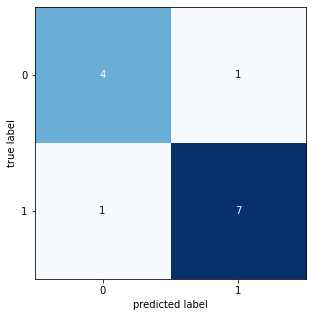

Running Time:  1.6326441999999872
gene : [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



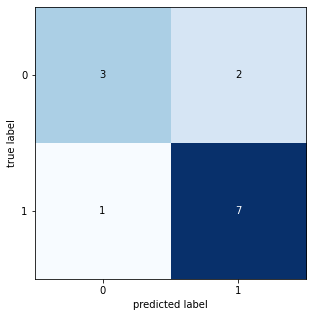

Running Time:  1.4846554000000083
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



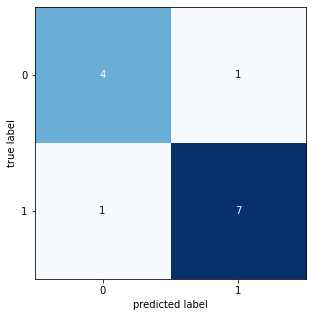

Running Time:  1.5038356999999962
gene : [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



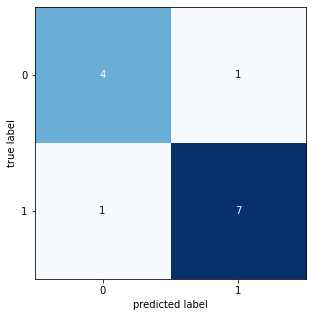

Running Time:  1.4874063000000035
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 47

Generation : 1
gene : [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pr

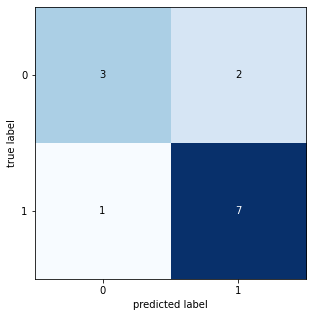

Running Time:  1.5037249000000088
gene : [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



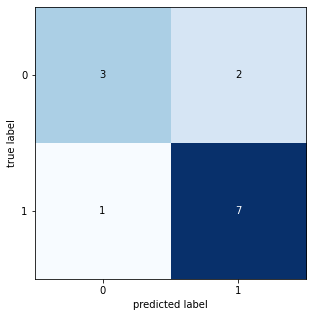

Running Time:  1.4909942999999828
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



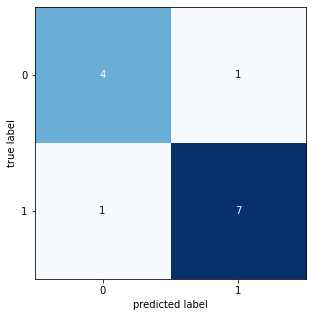

Running Time:  1.5081935000000044
gene : [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



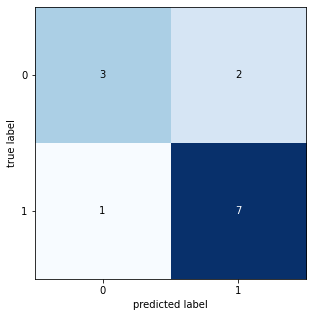

Running Time:  1.5022771000000148
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



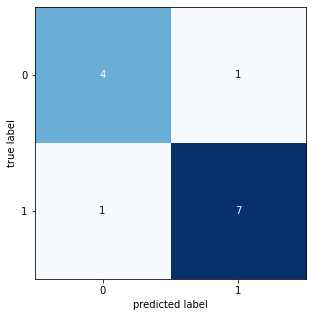

Running Time:  1.6526791000000003
gene : [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



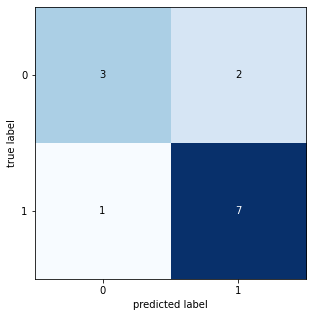

Running Time:  1.4887271999999996
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



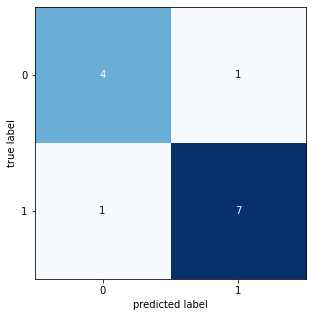

Running Time:  1.4881964999999866
gene : [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



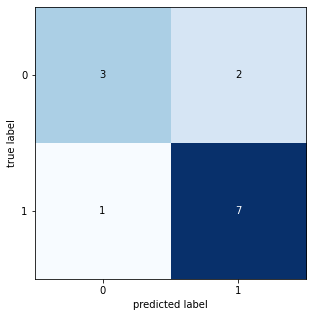

Running Time:  1.513868699999989
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



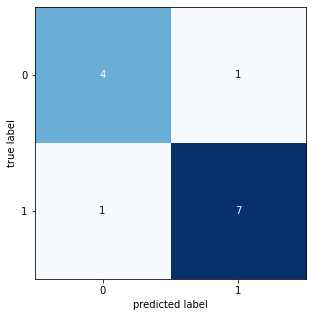

Running Time:  1.48566790000001
gene : [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



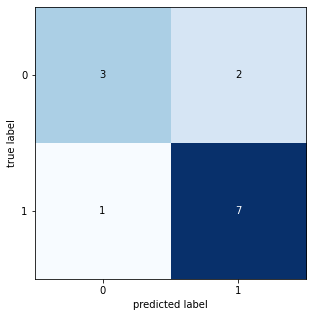

Running Time:  1.5022629000000052
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 54

Generation : 2
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

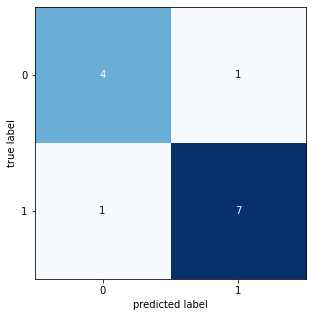

Running Time:  1.489204299999983
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



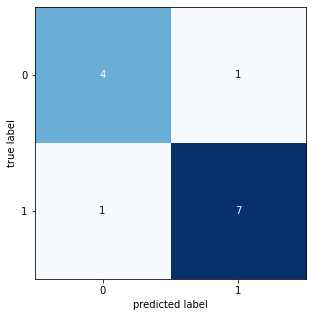

Running Time:  1.4920970000000011
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



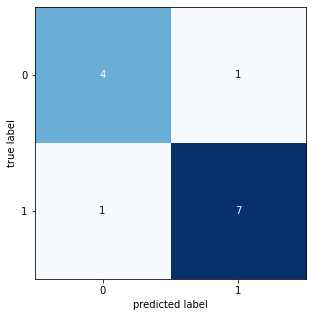

Running Time:  1.6524160999999822
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



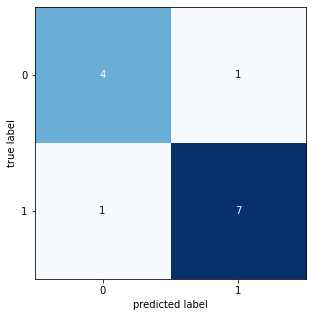

Running Time:  1.494236399999977
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



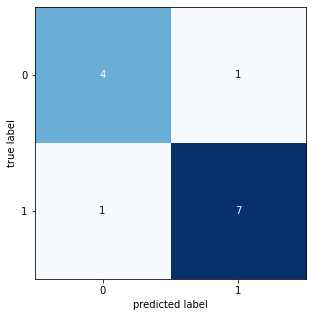

Running Time:  1.4978350999999748
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



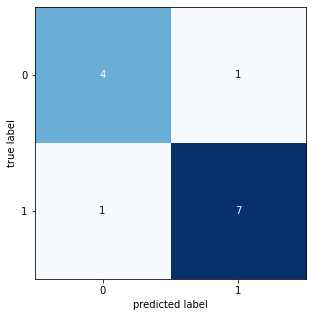

Running Time:  1.5049865000000295
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



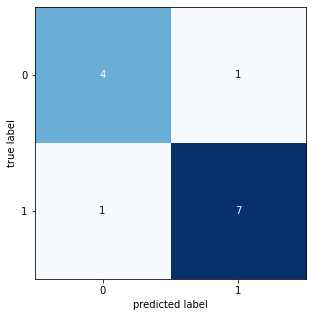

Running Time:  1.4936604999999759
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



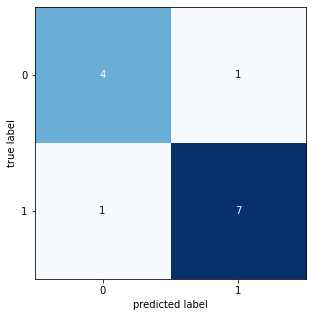

Running Time:  1.4950172000000066
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



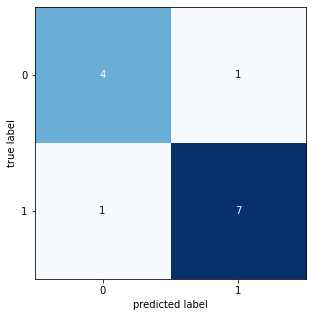

Running Time:  1.5470258999999942
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



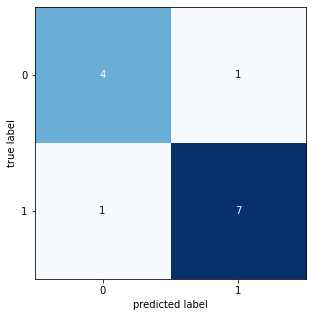

Running Time:  1.524610999999993
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 50

Generation : 3
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pre

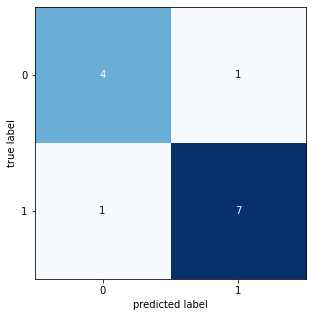

Running Time:  1.6658375000000092
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



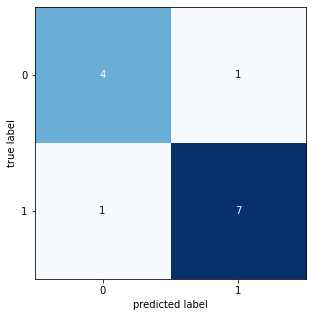

Running Time:  1.4878827000000001
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



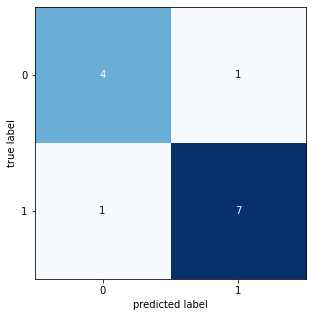

Running Time:  1.4950106000000005
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



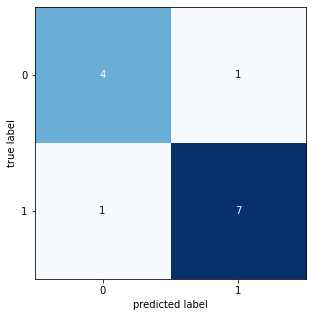

Running Time:  1.489658200000008
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



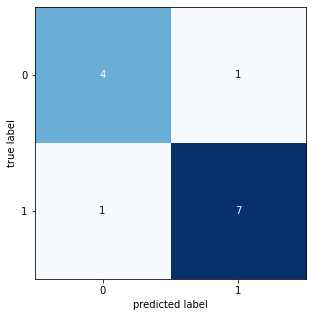

Running Time:  1.505348099999992
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



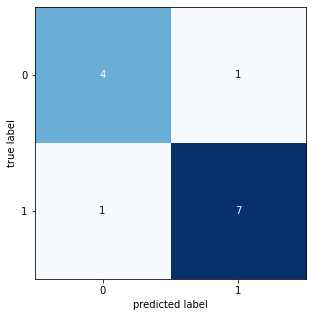

Running Time:  1.4945572000000311
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



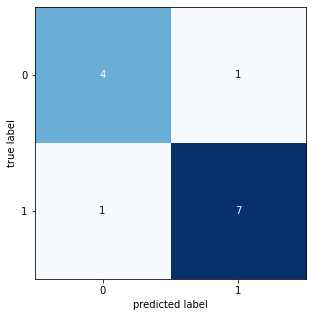

Running Time:  1.4965053999999895
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



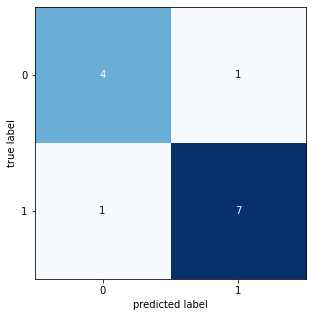

Running Time:  1.5066931999999724
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



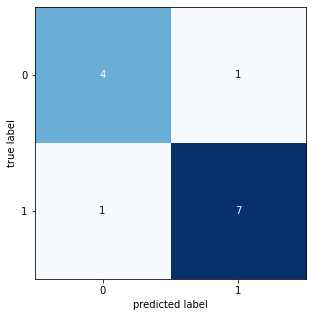

Running Time:  1.6769649999999956
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



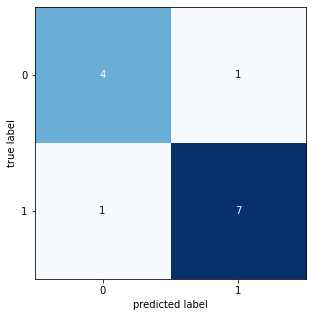

Running Time:  1.4966660000000047
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 57

Generation : 4
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

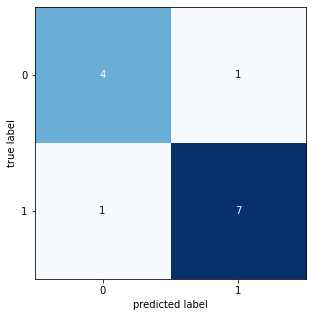

Running Time:  1.549401400000022
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



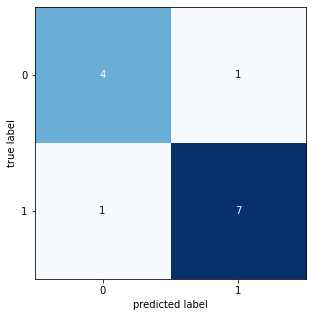

Running Time:  1.5790286999999807
gene : [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



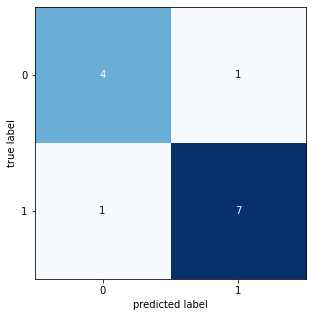

Running Time:  1.5061666999999943
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



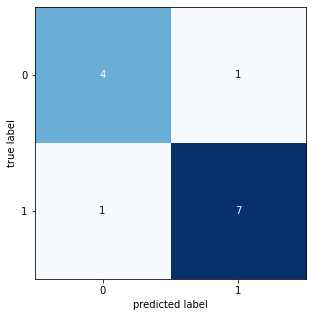

Running Time:  1.5013789999999858
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



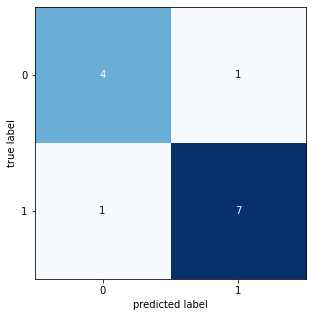

Running Time:  1.4914813000000322
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



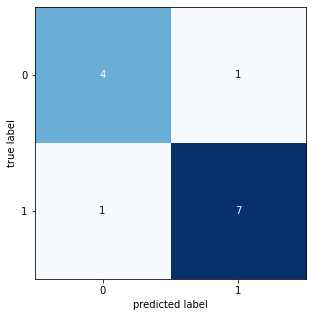

Running Time:  1.4924852000000328
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



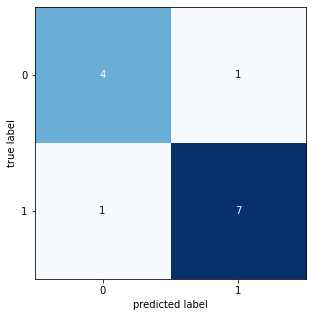

Running Time:  1.6660557000000153
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



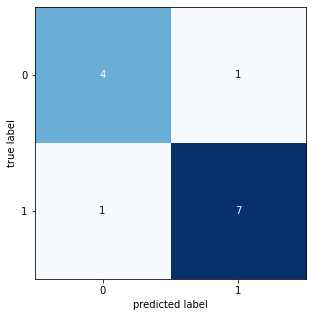

Running Time:  1.4973395999999752
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



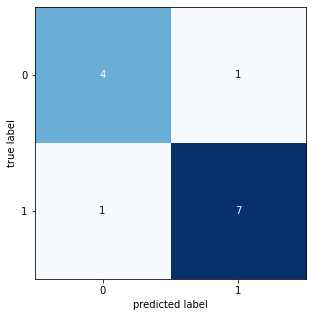

Running Time:  1.4903410000000008
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



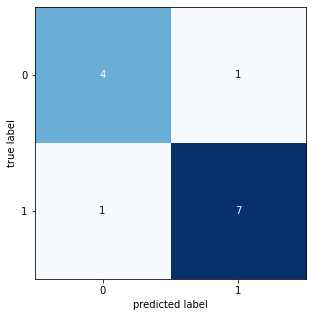

Running Time:  1.5061362000000145
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 52

Running Time:  76.90808480000001
colon + IG + GA Orde 4
Generation : 0
gene : [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.76923076

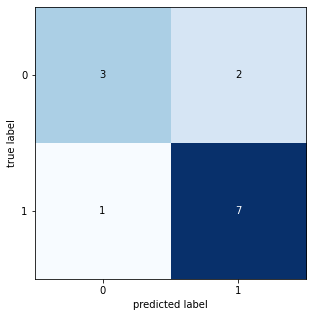

Running Time:  1.5081599999999753
gene : [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



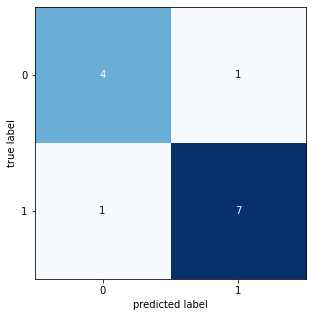

Running Time:  1.5196004000000016
gene : [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



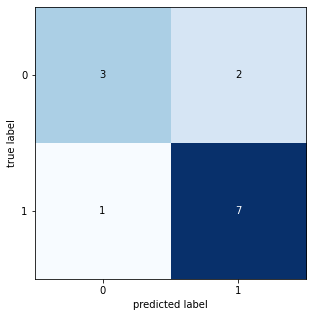

Running Time:  1.5148217000000272
gene : [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



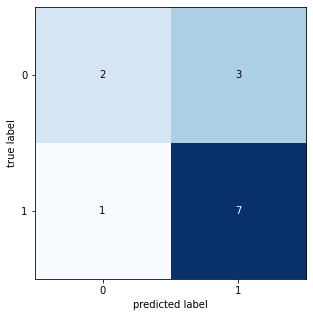

Running Time:  1.6575955999999792
gene : [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



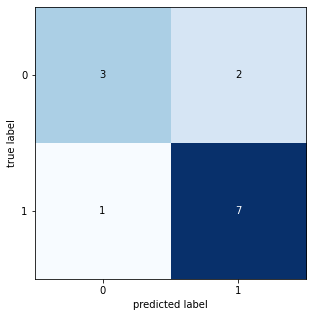

Running Time:  1.5041621999999961
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



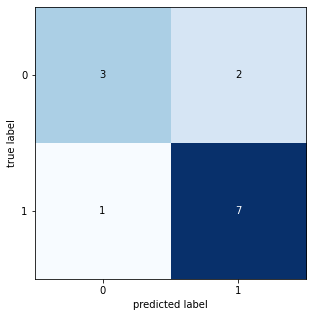

Running Time:  1.503622699999994
gene : [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



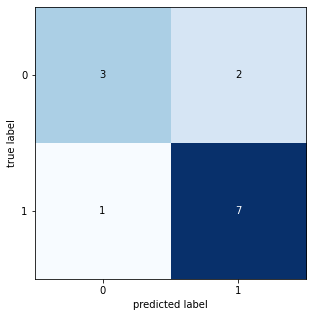

Running Time:  1.5034665000000018
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.89      1.00      0.94         8

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



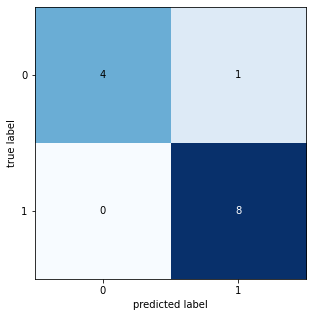

Running Time:  1.4980596999999989
gene : [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



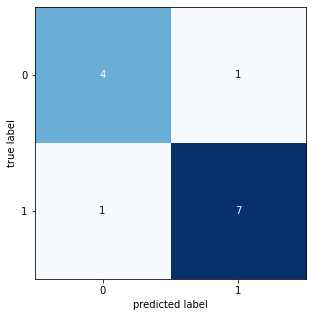

Running Time:  1.4982588999999962
gene : [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.6923076923076923
F1_Score :  0.675
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.75      0.75      0.75         8

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13



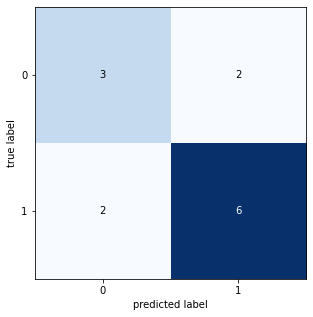

Running Time:  1.4933955999999853
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
F-1 Score terbaik : 0.9150326797385622  || Akurasi terbaik : 0.9230769230769231  || jumlah fitur : 39

Running Time:  15.394060999999965
Train :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test :  [19 25 26 29 32 33 34 36 46 53 54 59]
train:  (50, 101)
test:  (12, 101)
Running Time:  1.9046321000000148
colon + IG Orde 2
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
         

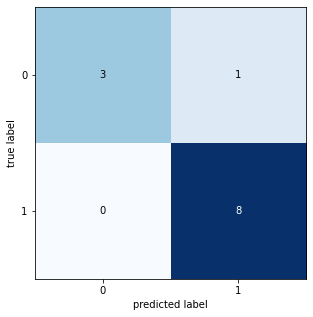

Running Time:  1.4874082000000044
colon + IG Orde 3
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



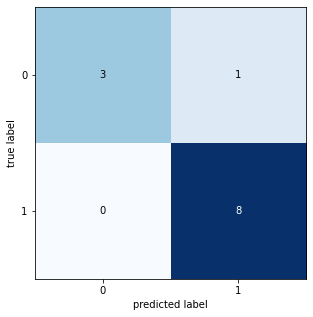

Running Time:  1.7026879000000008
colon + IG Orde 4
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



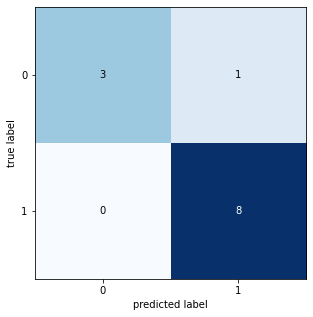

Running Time:  1.5308539999999766
colon + IG + GA Orde 2
Generation : 0
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



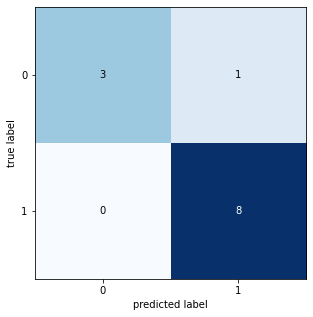

Running Time:  1.4945680000000152
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



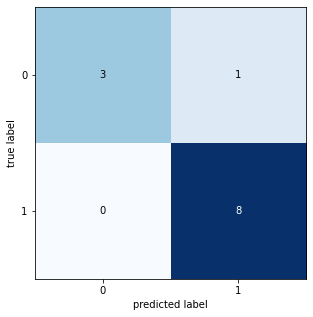

Running Time:  1.4849773000000255
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



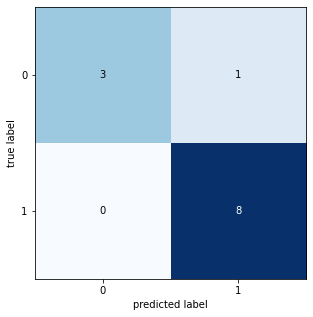

Running Time:  1.480135100000041
gene : [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



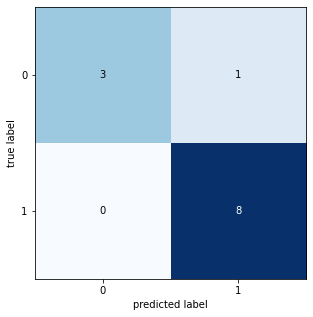

Running Time:  1.4853734000000145
gene : [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



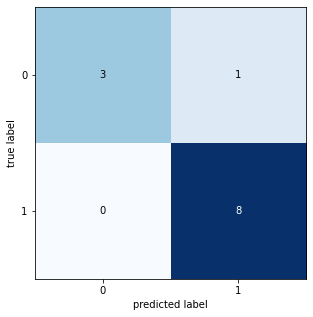

Running Time:  1.4868019999999547
gene : [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



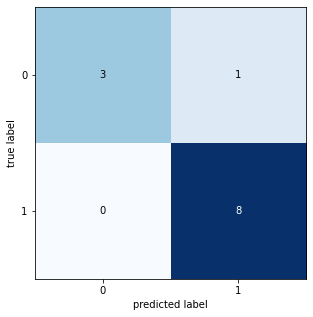

Running Time:  1.636595600000021
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



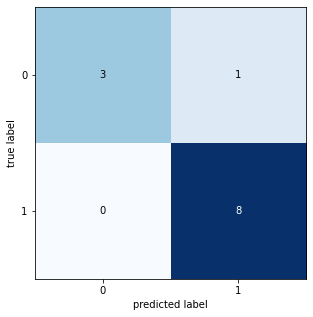

Running Time:  1.4884392999999818
gene : [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



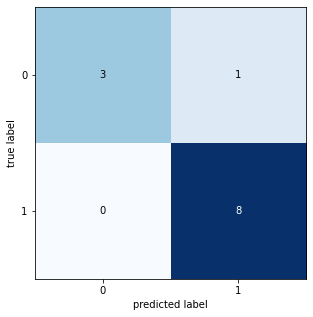

Running Time:  1.4879920999999854
gene : [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



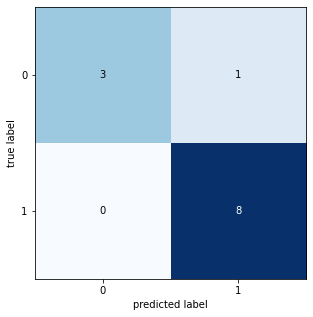

Running Time:  1.4828315999999973
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



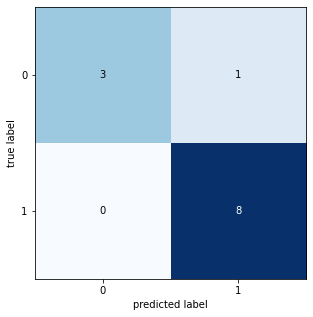

Running Time:  1.4781646999999793
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 42

Generation : 1
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

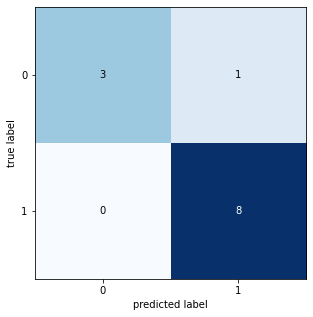

Running Time:  1.4855044999999905
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



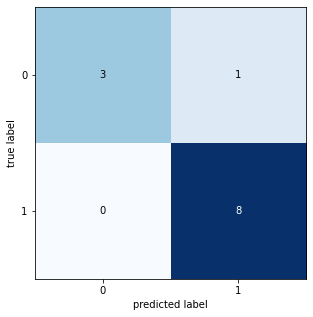

Running Time:  1.488373700000011
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



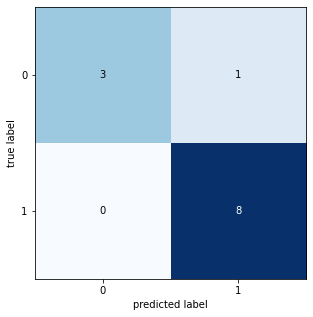

Running Time:  1.4863444000000072
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



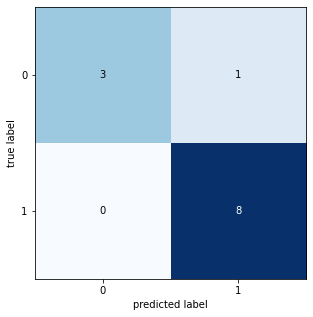

Running Time:  1.6709787000000347
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



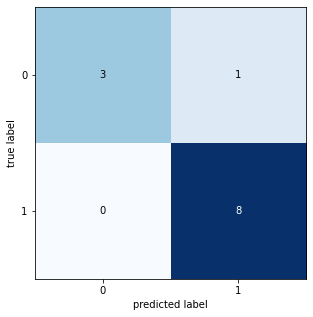

Running Time:  1.481918099999973
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



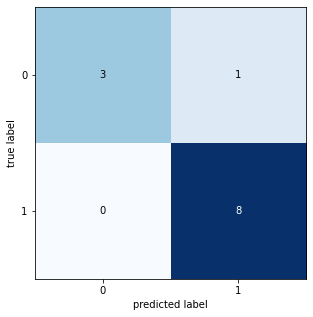

Running Time:  1.496520299999986
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



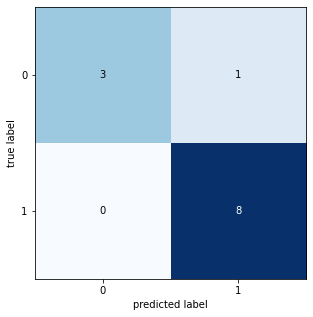

Running Time:  1.4838539000000424
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



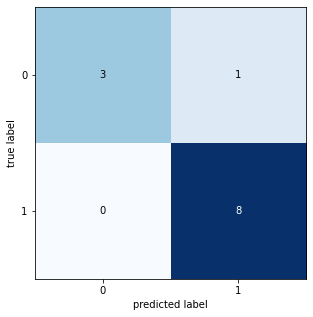

Running Time:  1.48117000000002
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



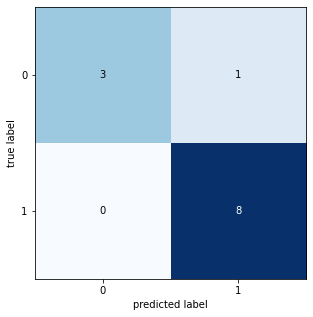

Running Time:  1.4990045000000123
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



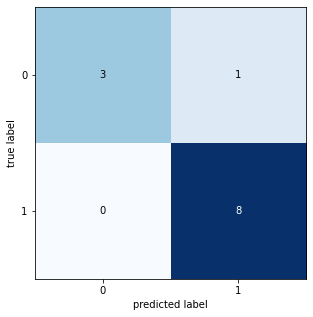

Running Time:  1.4847078999999894
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 44

Generation : 2
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

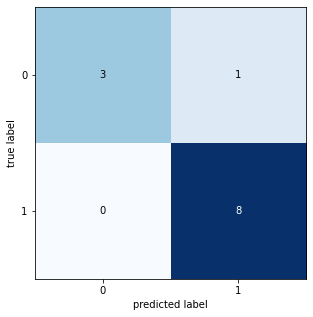

Running Time:  1.4874713000000384
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



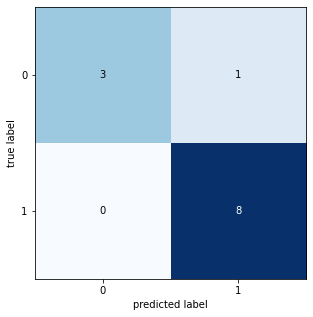

Running Time:  1.6709038999999848
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



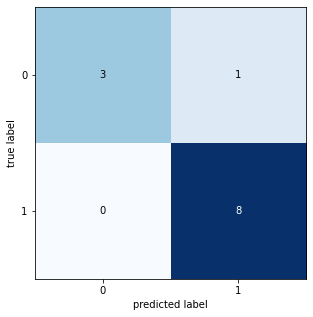

Running Time:  1.477998599999978
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



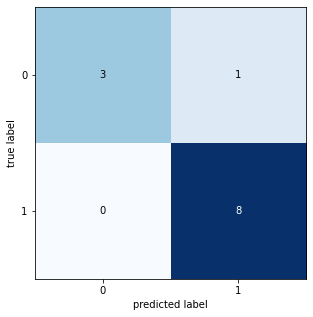

Running Time:  1.4861697999999706
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



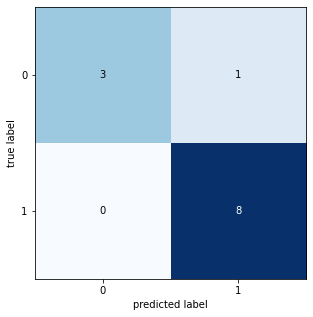

Running Time:  1.4917072999999732
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



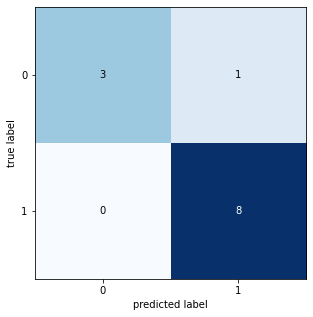

Running Time:  1.4894714000000135
gene : [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



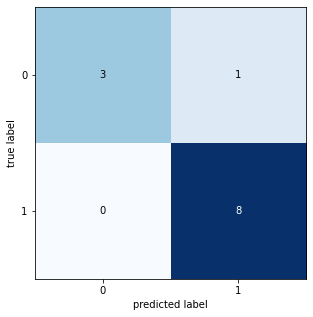

Running Time:  1.4826817999999662
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



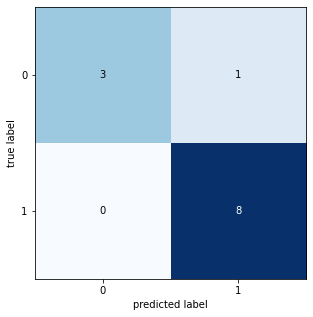

Running Time:  1.4896144999999592
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



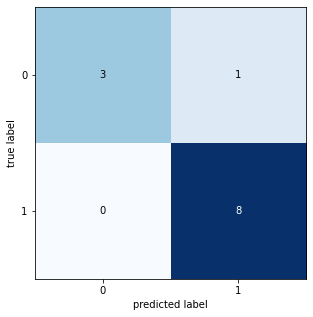

Running Time:  1.4862142000000063
gene : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



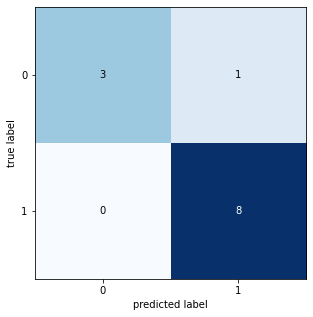

Running Time:  1.657276799999977
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 51

Generation : 3
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

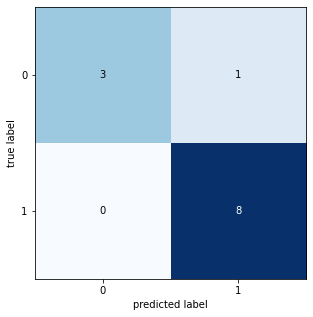

Running Time:  1.4932164000000512
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



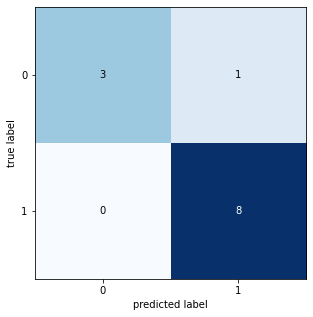

Running Time:  1.4818415999999957
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



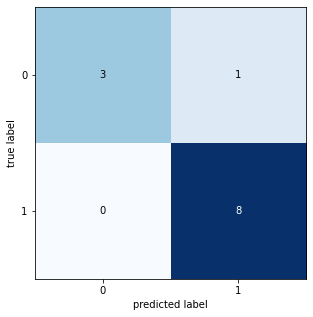

Running Time:  1.4871683999999732
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



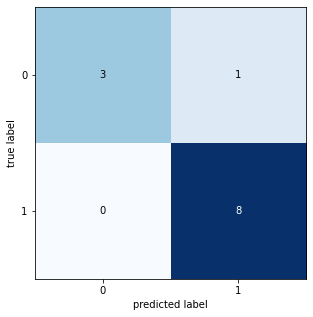

Running Time:  1.4973283000000492
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



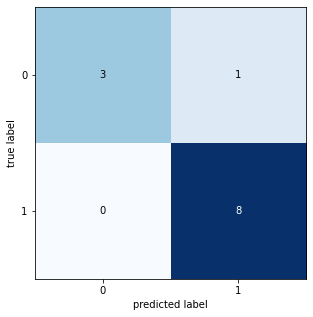

Running Time:  1.482191499999999
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



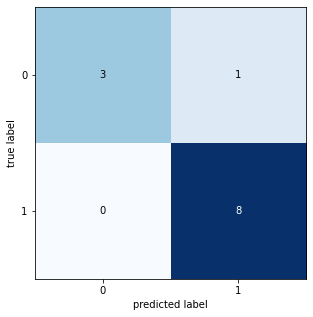

Running Time:  1.4941389999999615
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



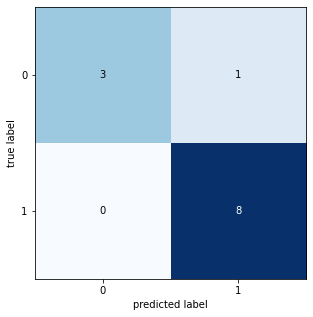

Running Time:  1.5019507999999746
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



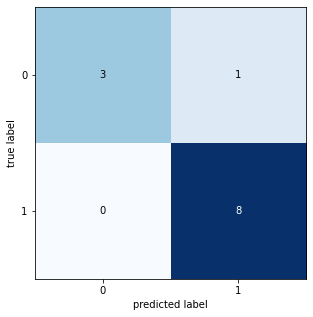

Running Time:  1.6665024999999787
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



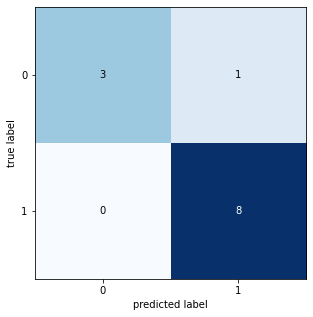

Running Time:  1.4810610999999767
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



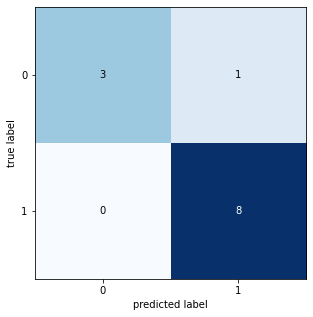

Running Time:  1.4964390000000094
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 49

Generation : 4
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

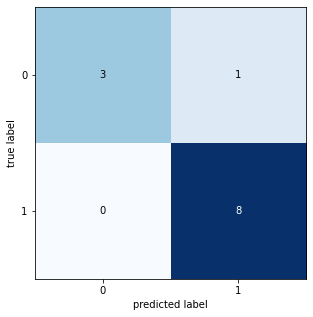

Running Time:  1.4992020999999909
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



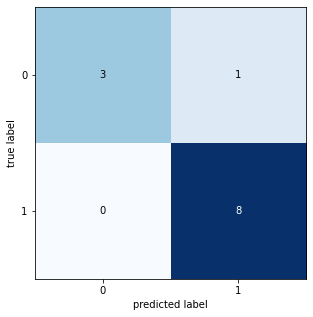

Running Time:  1.4894859000000338
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



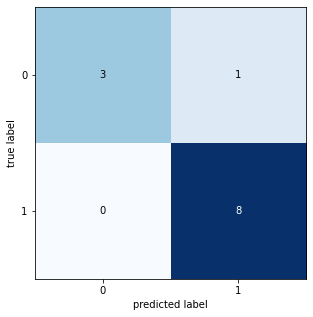

Running Time:  1.472145600000033
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



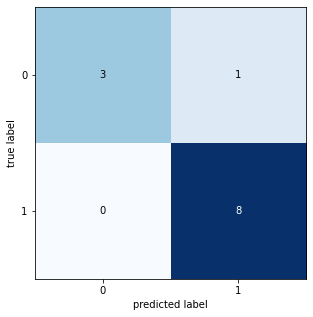

Running Time:  1.4744941000000154
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



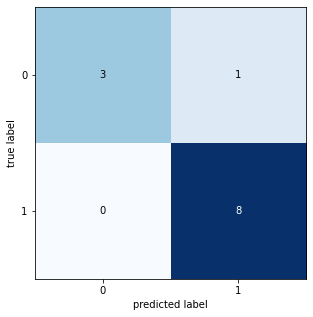

Running Time:  1.4603982999999516
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



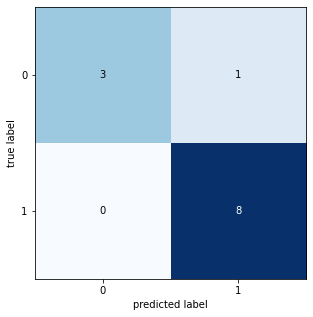

Running Time:  1.6421221999999602
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



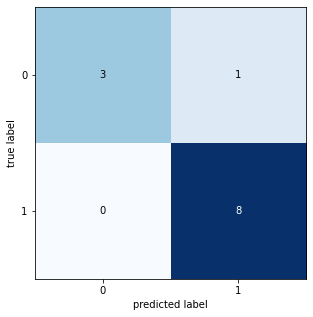

Running Time:  1.4640957000000299
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



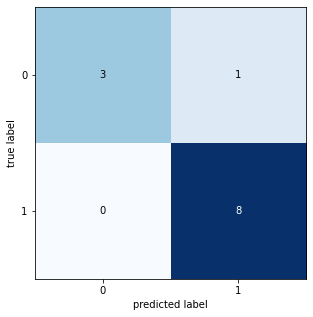

Running Time:  1.4656524000000104
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



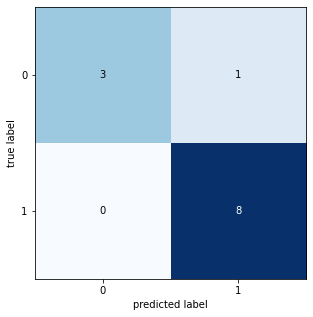

Running Time:  1.4667102999999884
gene : [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



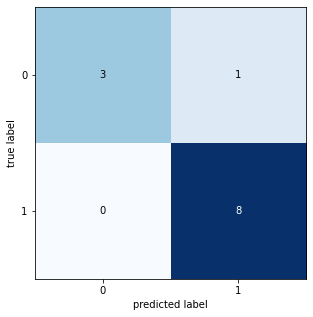

Running Time:  1.4648136000000136
gen terbaik : [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 47

Running Time:  76.10030720000003
colon + IG + GA Orde 3
Generation : 0
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.91666666

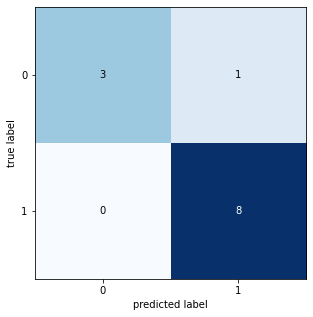

Running Time:  1.4784440000000245
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



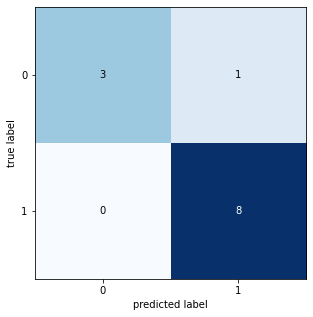

Running Time:  1.4835092000000145
gene : [1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



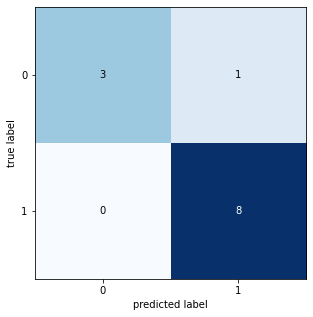

Running Time:  1.4786326000000258
gene : [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



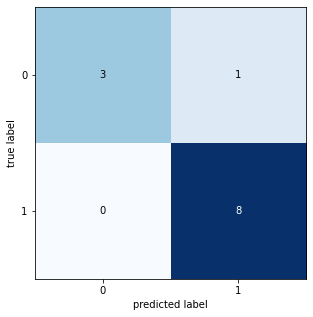

Running Time:  1.6451614000000063
gene : [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



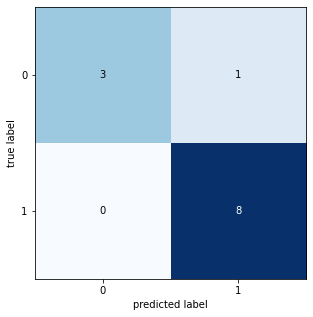

Running Time:  1.4865464000000088
gene : [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



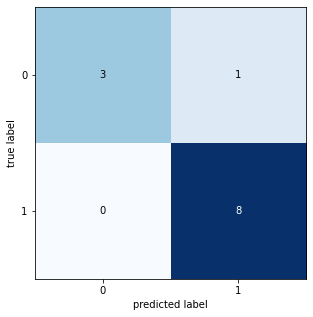

Running Time:  1.4785953999999606
gene : [1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



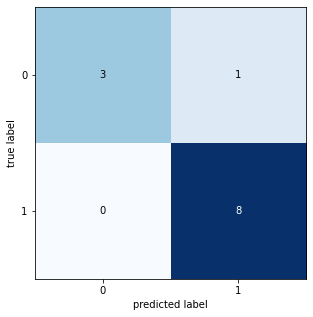

Running Time:  1.478518500000007
gene : [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



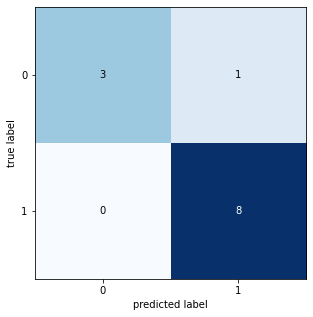

Running Time:  1.4909442000000013
gene : [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



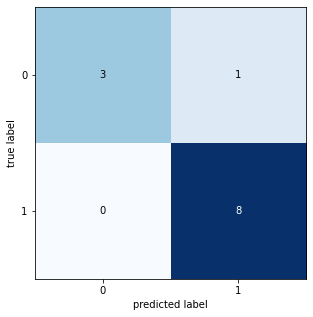

Running Time:  1.4856351999999902
gene : [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



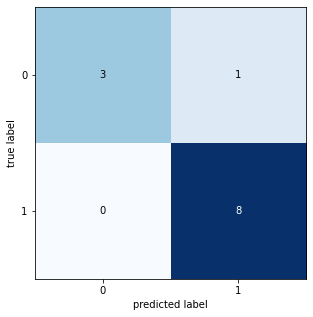

Running Time:  1.4747184999999945
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 52

Generation : 1
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

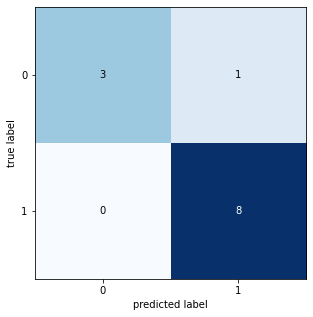

Running Time:  1.6453599999999824
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



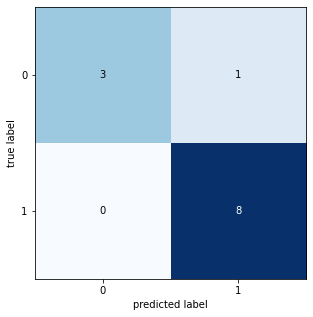

Running Time:  1.4672906999999782
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



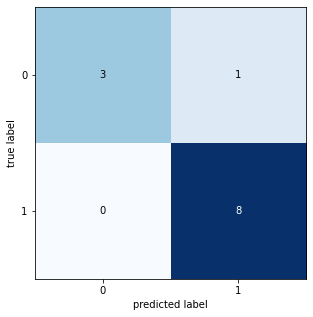

Running Time:  1.4781035999999972
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



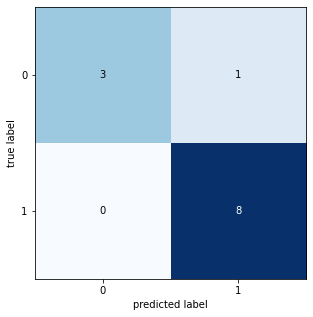

Running Time:  1.4884923000000185
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



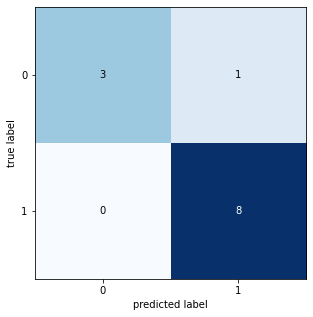

Running Time:  1.4749133999999913
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



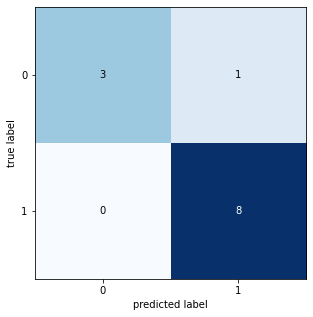

Running Time:  1.4794095000000311
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



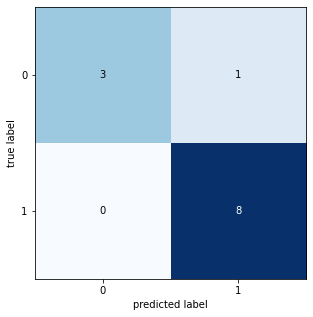

Running Time:  1.489285300000006
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



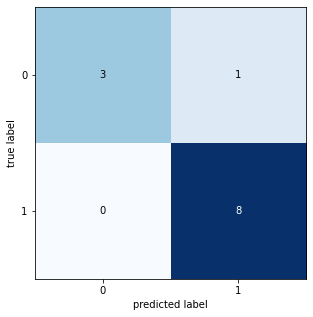

Running Time:  1.475969599999985
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



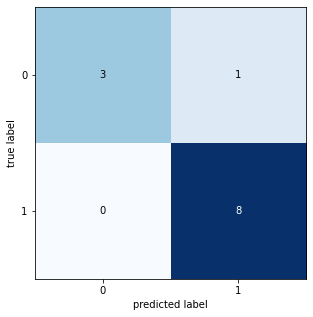

Running Time:  1.6587635999999861
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



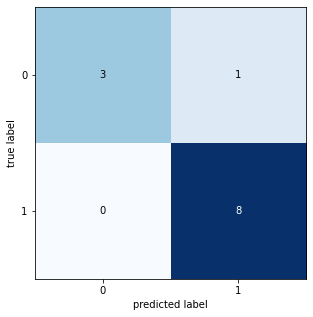

Running Time:  1.4823432000000025
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 52

Generation : 2
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

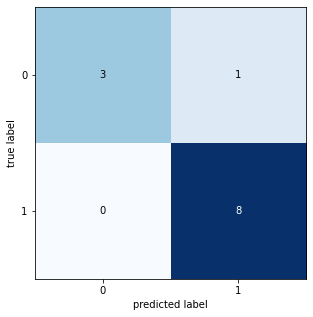

Running Time:  1.4850374999999758
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



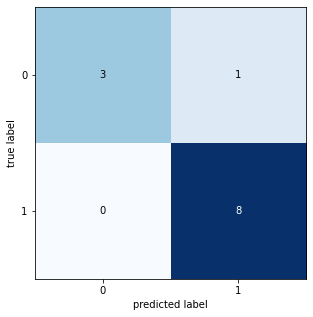

Running Time:  1.474562399999968
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



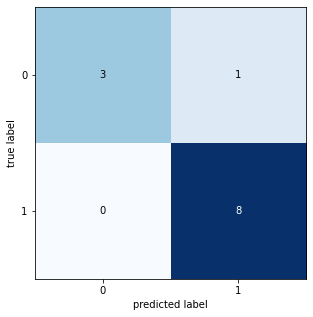

Running Time:  1.4906790999999657
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



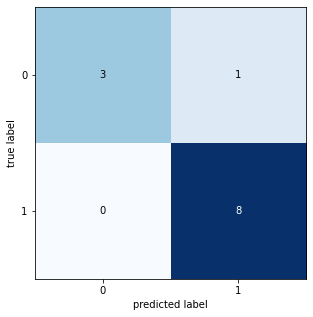

Running Time:  1.4860454000000232
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



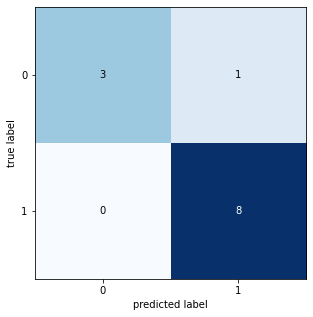

Running Time:  1.4822704000000044
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



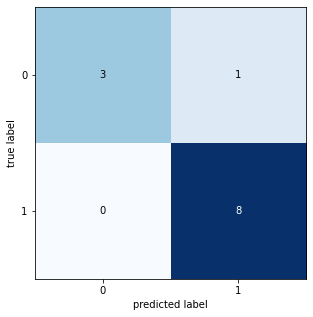

Running Time:  1.477643100000023
gene : [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



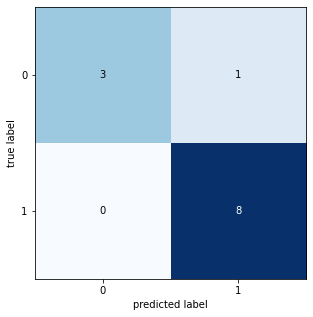

Running Time:  1.669646699999987
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



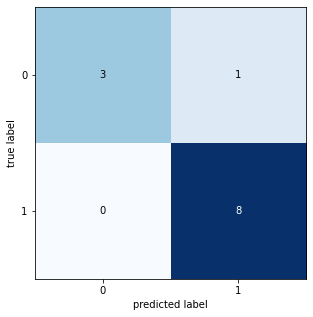

Running Time:  1.480168899999967
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



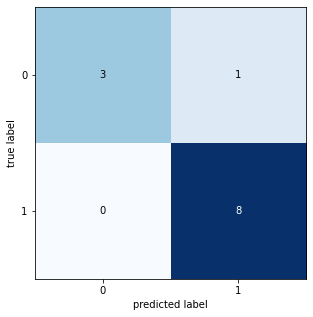

Running Time:  1.482931399999984
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



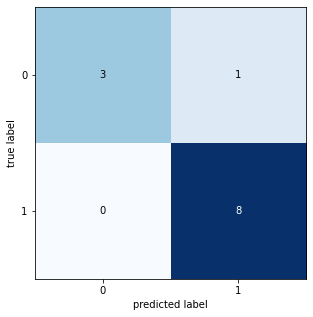

Running Time:  1.4869739000000095
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 51

Generation : 3
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

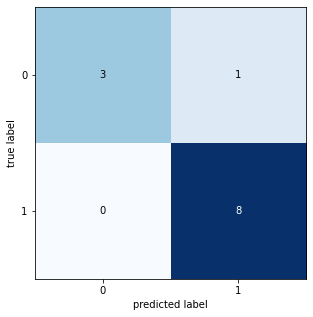

Running Time:  1.4897046000000387
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



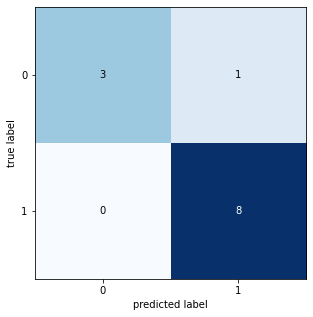

Running Time:  1.4918890999999803
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



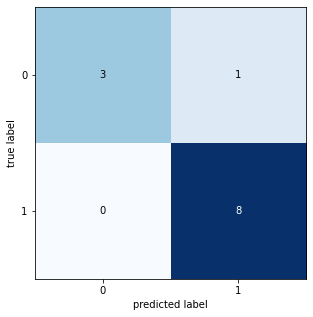

Running Time:  1.4854290999999762
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



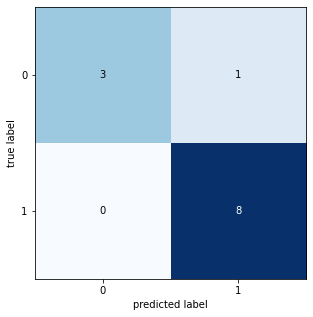

Running Time:  1.4781426000000124
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



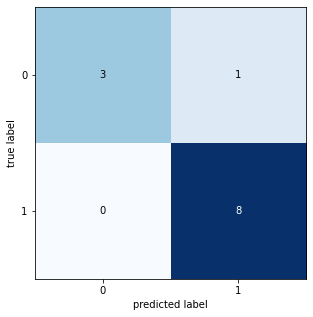

Running Time:  1.6617790999999897
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



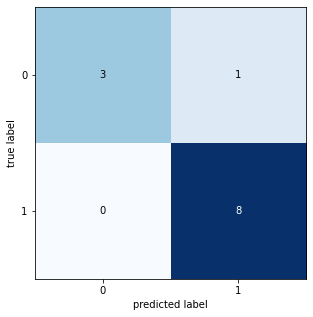

Running Time:  1.4894380999999726
gene : [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



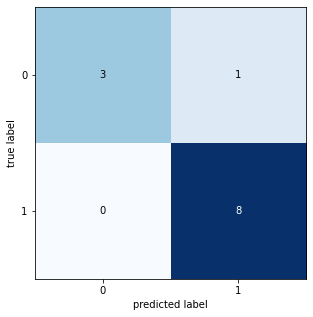

Running Time:  1.4864296000000081
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



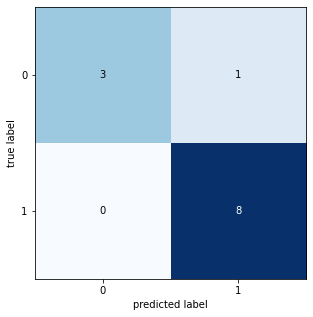

Running Time:  1.4932329999999752
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



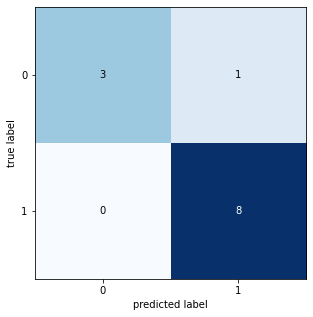

Running Time:  1.4862095000000295
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



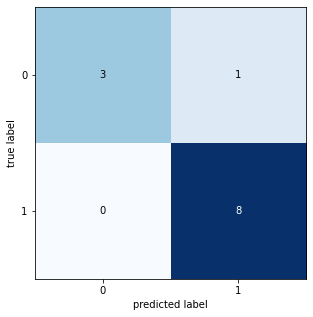

Running Time:  1.4793079000000375
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 53

Generation : 4
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

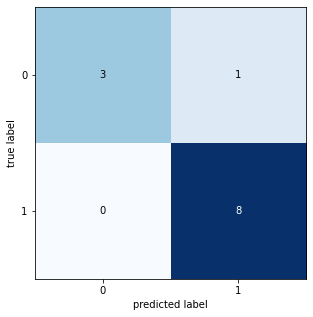

Running Time:  1.4909278999999742
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



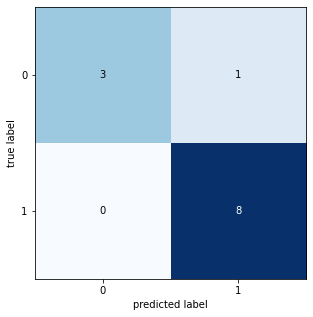

Running Time:  1.489403799999991
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



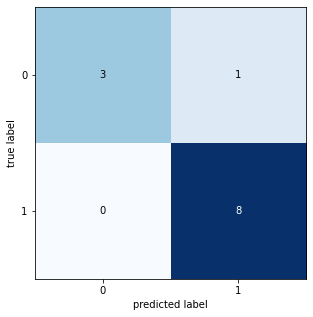

Running Time:  1.6683651999999825
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



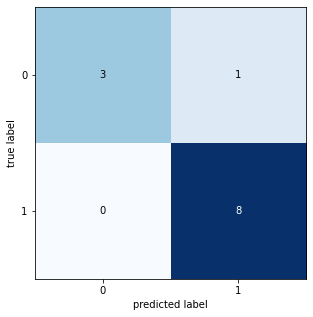

Running Time:  1.4790300999999886
gene : [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



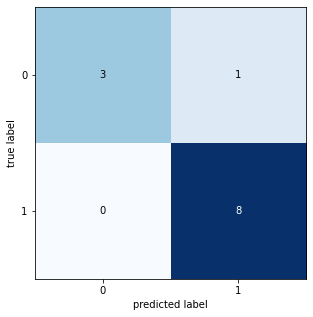

Running Time:  1.4830170999999837
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



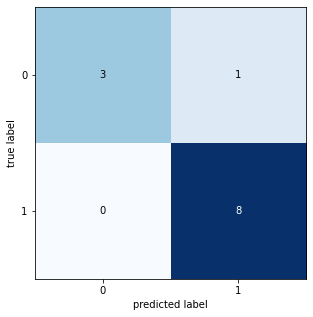

Running Time:  1.487731999999994
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



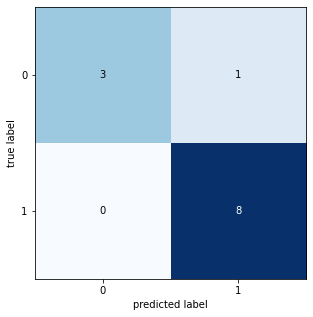

Running Time:  1.5028790000000072
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



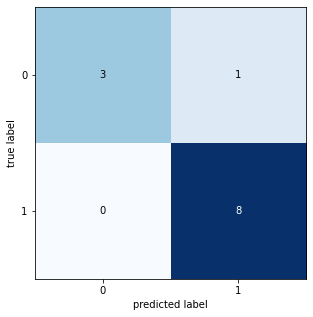

Running Time:  1.4955602
gene : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



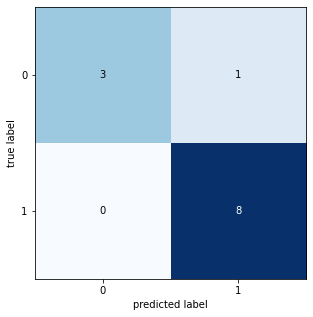

Running Time:  1.4878532999999834
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



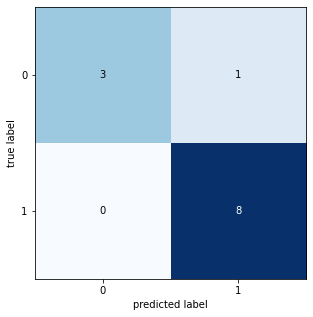

Running Time:  1.4863121999999862
gen terbaik : [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 53

Running Time:  76.15088549999996
colon + IG + GA Orde 4
Generation : 0
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.91666666

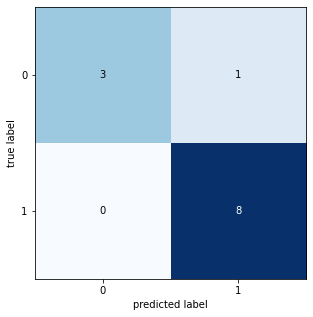

Running Time:  1.6768652999999745
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



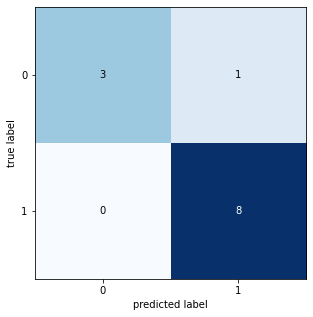

Running Time:  1.4782142999999905
gene : [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



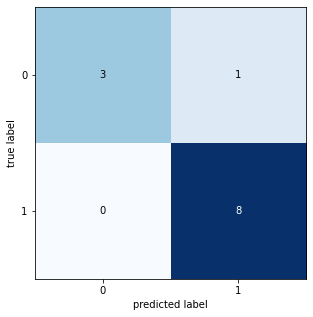

Running Time:  1.5052668000000153
gene : [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



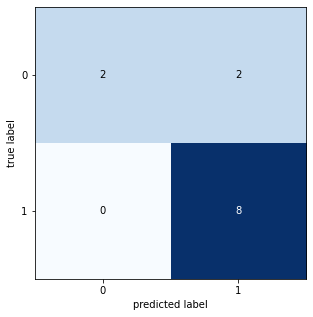

Running Time:  1.4979493000000161
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



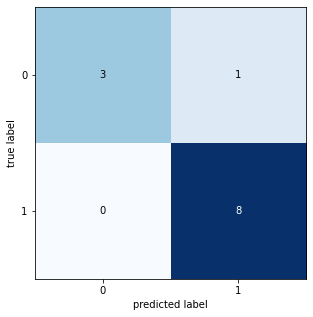

Running Time:  1.4891240999999695
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



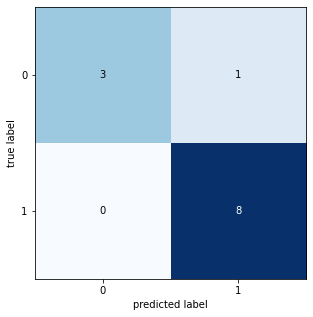

Running Time:  1.4936974999999961
gene : [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



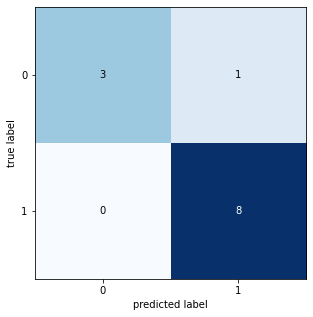

Running Time:  1.487455099999977
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



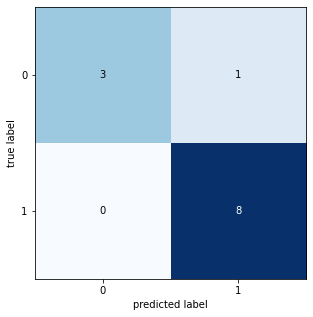

Running Time:  1.6311150999999882
gene : [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



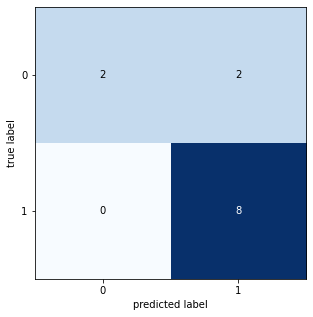

Running Time:  1.490760899999998
gene : [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



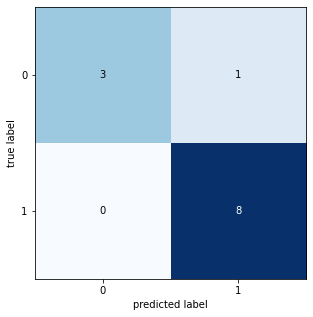

Running Time:  1.4839111000000003
gen terbaik : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 46

Generation : 1
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

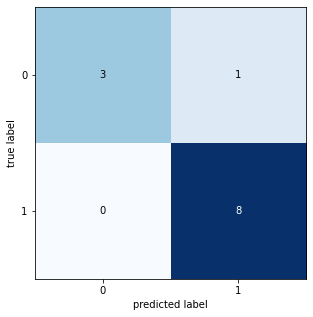

Running Time:  1.4839613999999983
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



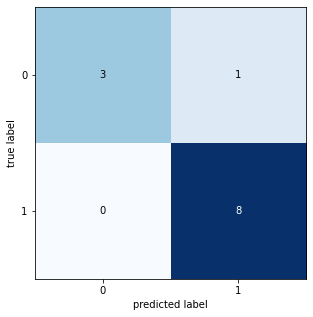

Running Time:  1.4860390000000052
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



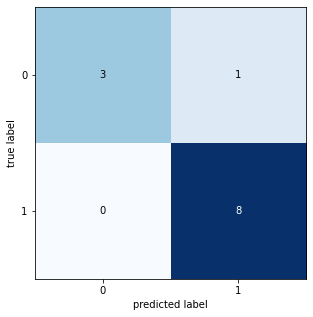

Running Time:  1.482649800000047
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



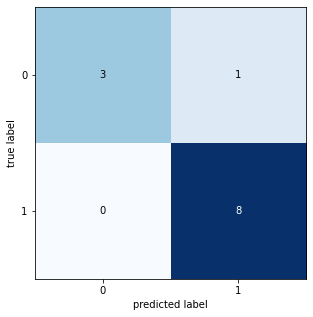

Running Time:  1.4910179999999968
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



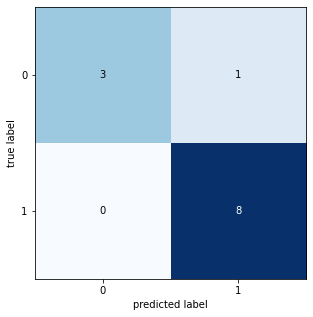

Running Time:  1.4846763999999553
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



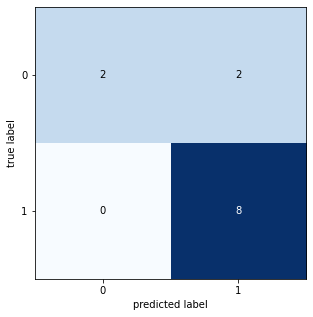

Running Time:  1.6551259999999957
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



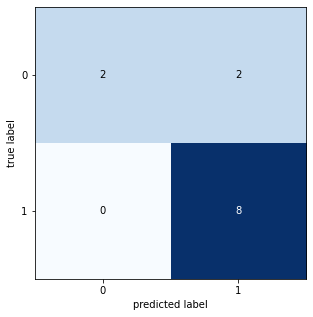

Running Time:  1.487045299999977
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



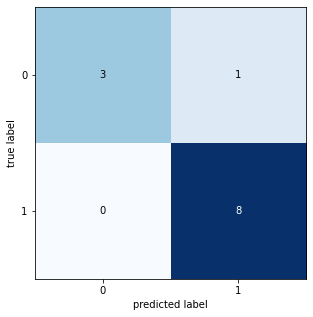

Running Time:  1.4951747999999725
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



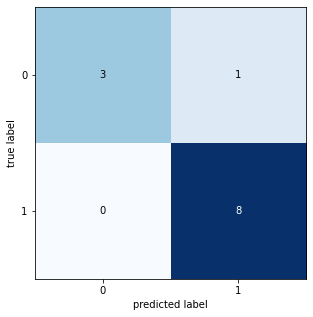

Running Time:  1.4953878000000032
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



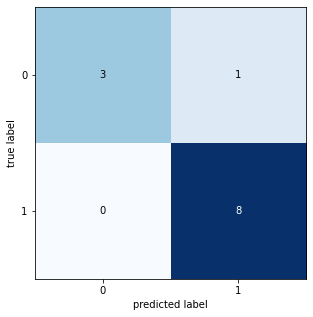

Running Time:  1.483469599999978
gen terbaik : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 43

Generation : 2
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              pre

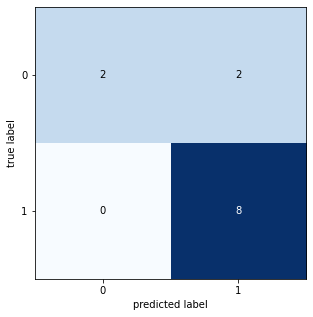

Running Time:  1.4896422000000484
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



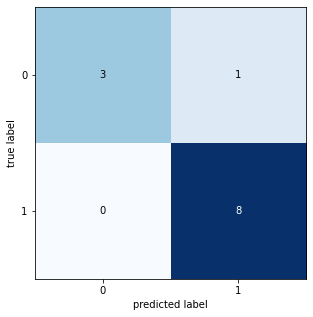

Running Time:  1.4990895999999339
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



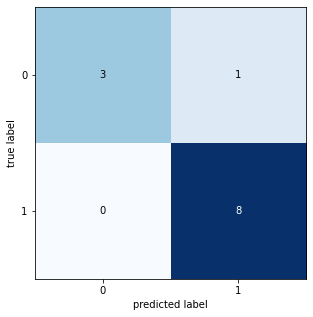

Running Time:  1.4868249000001015
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



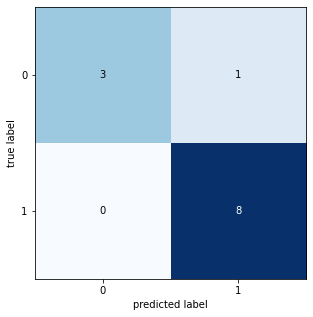

Running Time:  1.653895200000079
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



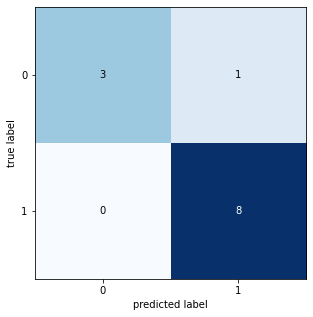

Running Time:  1.486976899999945
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



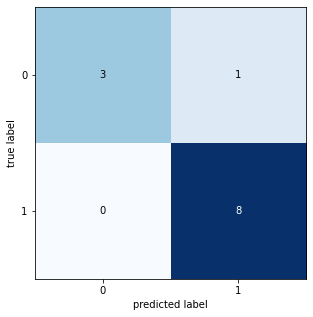

Running Time:  1.4860985000000255
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



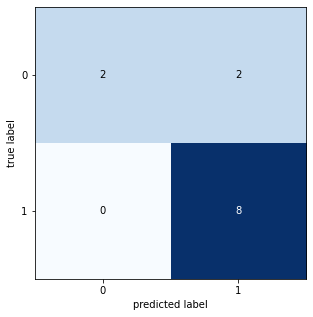

Running Time:  1.4923807000000124
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



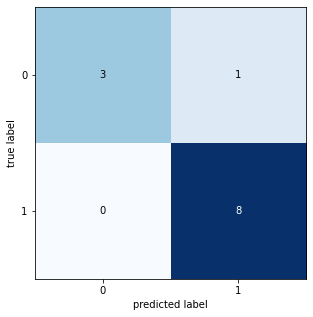

Running Time:  1.4879172999999355
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



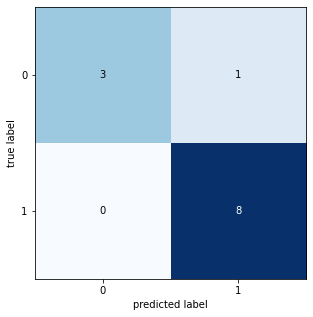

Running Time:  1.483905899999968
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



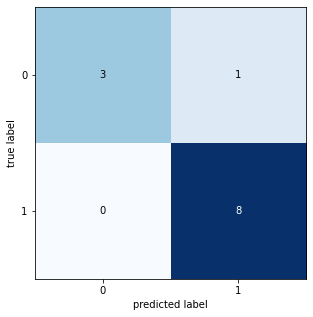

Running Time:  1.4900232999999616
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 46

Generation : 3
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

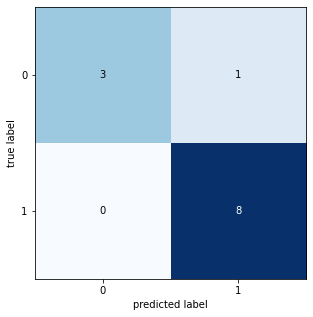

Running Time:  1.4893309999999929
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



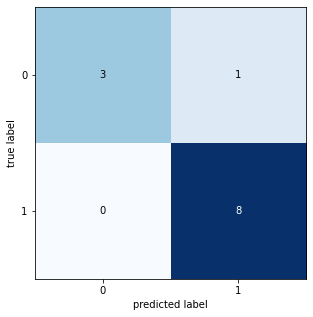

Running Time:  1.6631297000000131
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



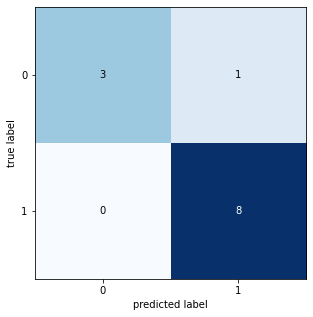

Running Time:  1.4976793999999245
gene : [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



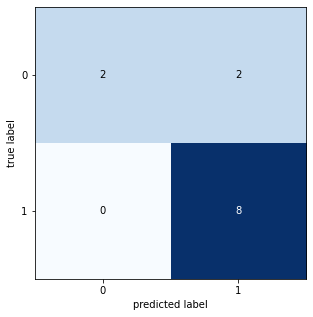

Running Time:  1.487288499999977
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



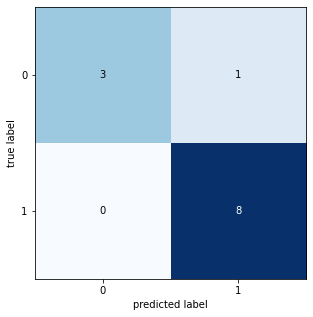

Running Time:  1.5068966000000046
gene : [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



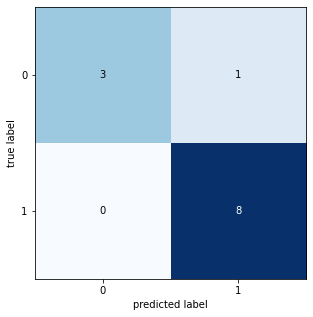

Running Time:  1.5051339999999982
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



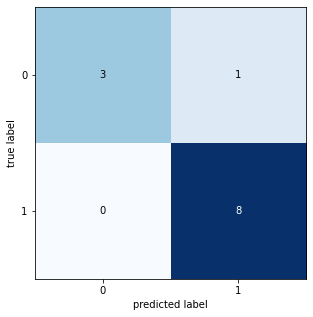

Running Time:  1.5043861000000334
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



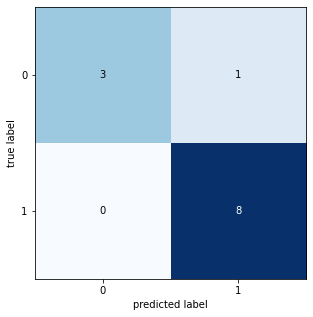

Running Time:  1.4936206999999513
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



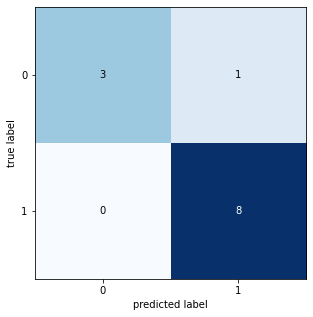

Running Time:  1.48910479999995
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



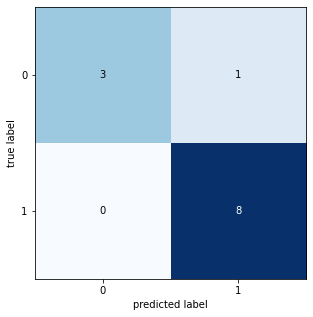

Running Time:  1.6629493000000366
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 43

Generation : 4
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

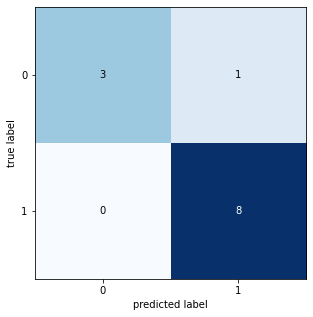

Running Time:  1.499465500000042
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



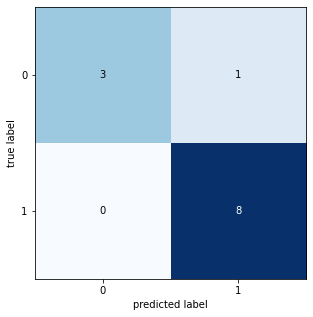

Running Time:  1.4891328999999587
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



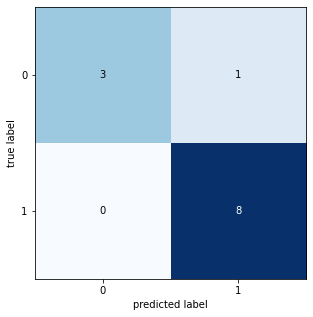

Running Time:  1.486537799999951
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



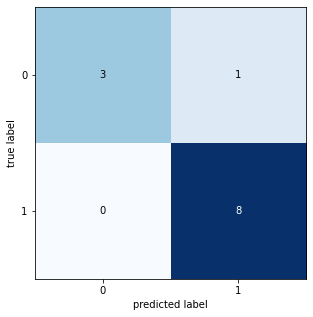

Running Time:  1.4916451999999936
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



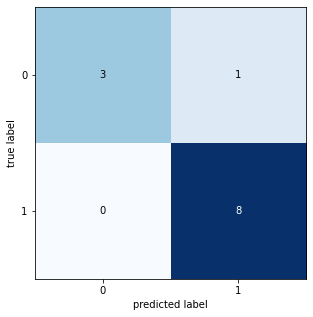

Running Time:  1.4998516000000564
gene : [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



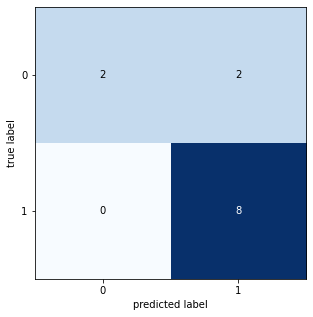

Running Time:  1.4786152000000357
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



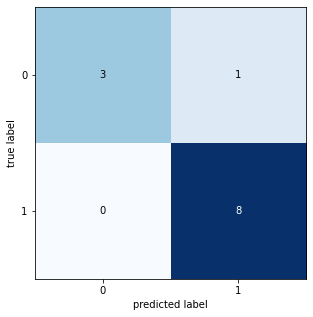

Running Time:  1.4751561000000493
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



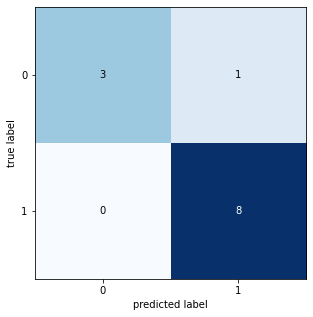

Running Time:  1.6590911999999207
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



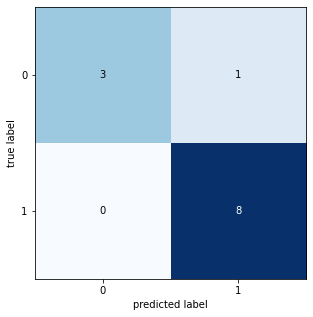

Running Time:  1.4803344000000607
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



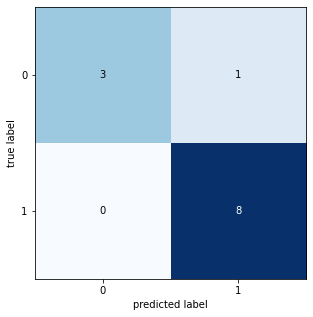

Running Time:  1.4982358000000886
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 44

Running Time:  76.53342329999992
Train :  [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test :  [ 2  6  7 11 13 14 16 45 49 51 52 55]
train:  (50, 101)
test:  (12, 101)
Running Time:  1.8804426000000376
colon + IG Orde 2
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
          

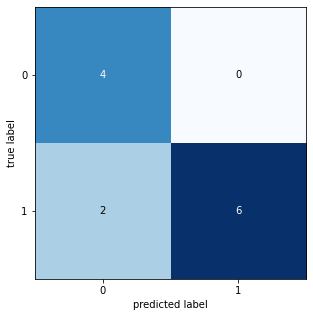

Running Time:  1.4707270999999764
colon + IG Orde 3
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



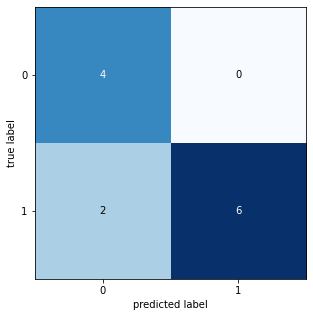

Running Time:  1.5030483000000459
colon + IG Orde 4
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



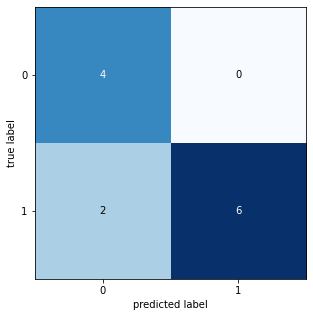

Running Time:  1.510537099999965
colon + IG + GA Orde 2
Generation : 0
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



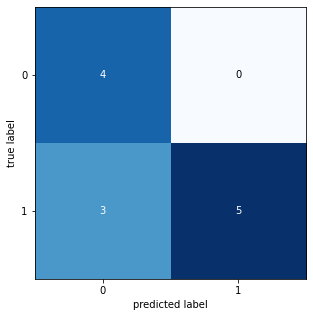

Running Time:  1.4812802999999803
gene : [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



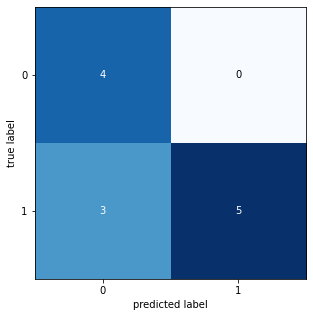

Running Time:  1.6224036999999498
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



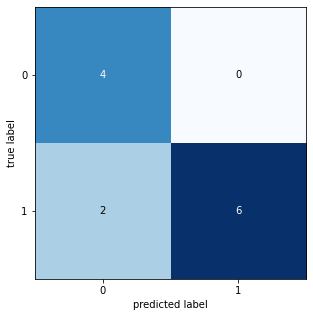

Running Time:  1.4758590999999797
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



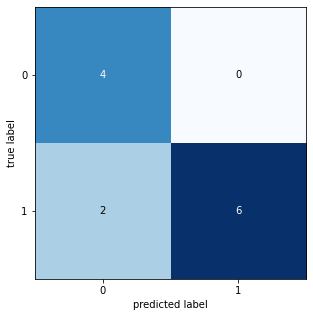

Running Time:  1.4899556999999959
gene : [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



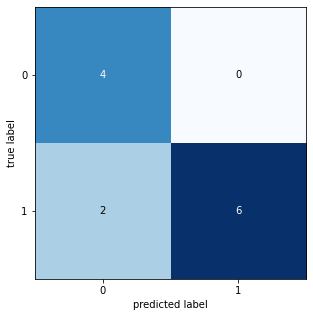

Running Time:  1.485512700000072
gene : [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



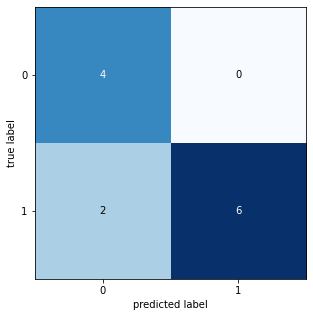

Running Time:  1.4787933000000066
gene : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



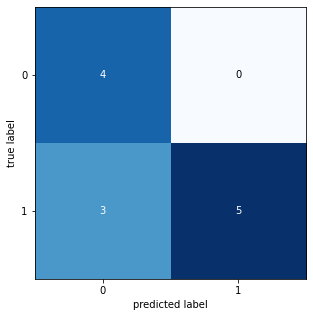

Running Time:  1.4884809000000132
gene : [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



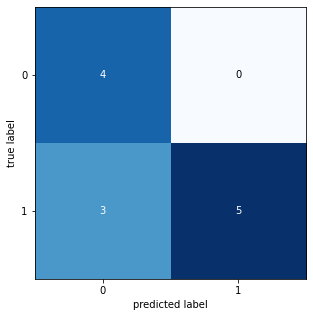

Running Time:  1.4837384999999585
gene : [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



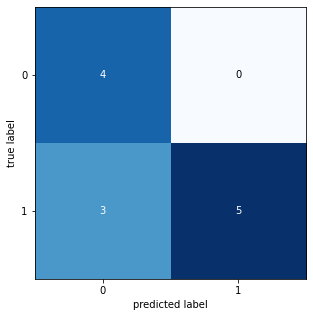

Running Time:  1.4801817000000028
gene : [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



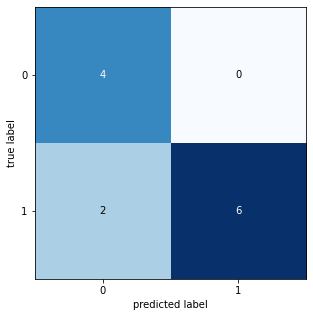

Running Time:  1.668034499999976
gen terbaik : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 57

Generation : 1
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

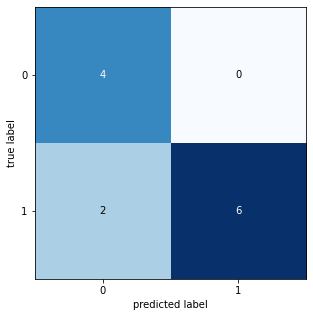

Running Time:  1.490599399999951
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



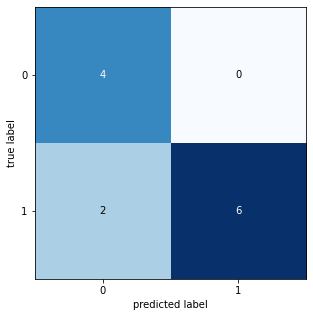

Running Time:  1.492227600000092
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



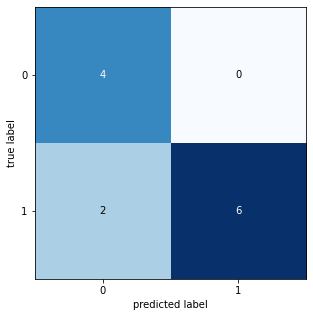

Running Time:  1.4908411000000115
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



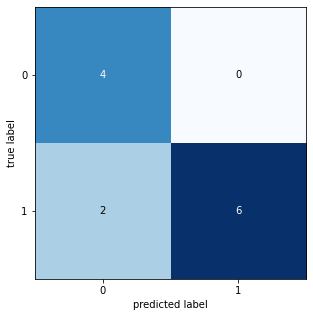

Running Time:  1.4822904999999764
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



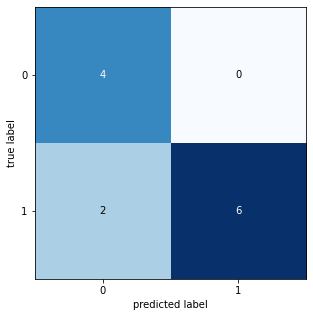

Running Time:  1.4857417000000623
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



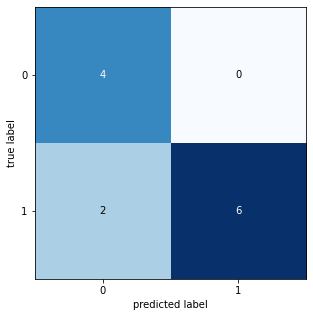

Running Time:  1.4893350999999484
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



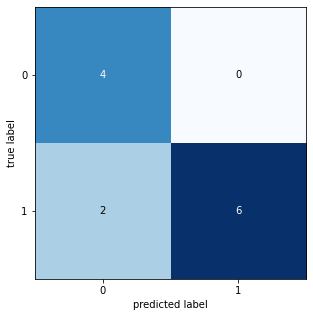

Running Time:  1.4760212999999567
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



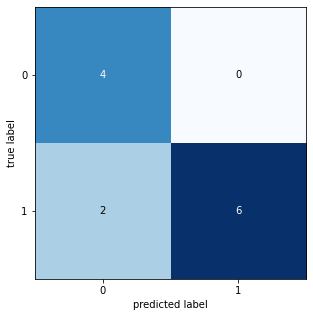

Running Time:  1.66112499999997
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



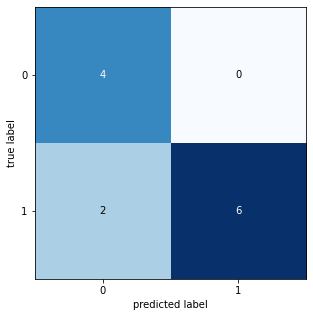

Running Time:  1.4833309000000554
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



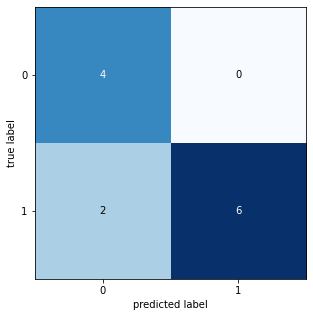

Running Time:  1.4866400000000795
gen terbaik : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 58

Generation : 2
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

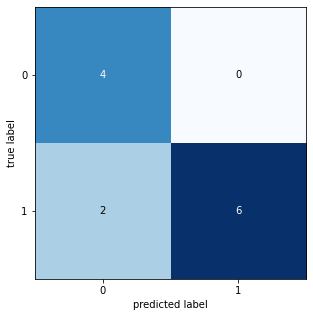

Running Time:  1.4841508000000658
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



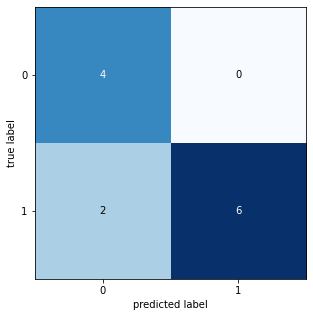

Running Time:  1.4884900999999218
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



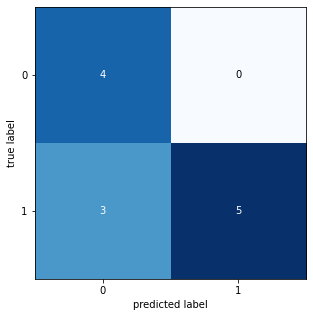

Running Time:  1.4775227000000086
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



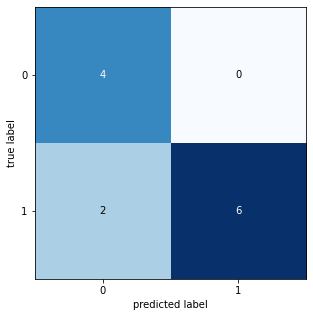

Running Time:  1.476359699999989
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



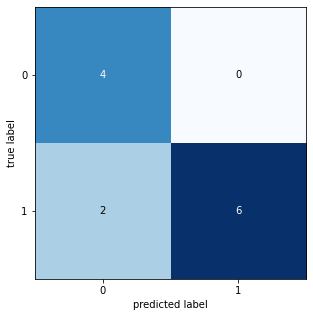

Running Time:  1.4834804000000759
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



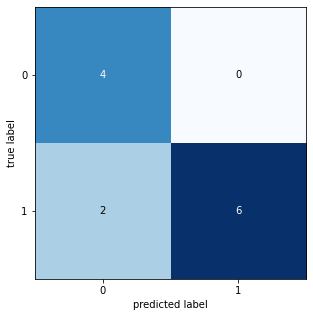

Running Time:  1.6639007999999649
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



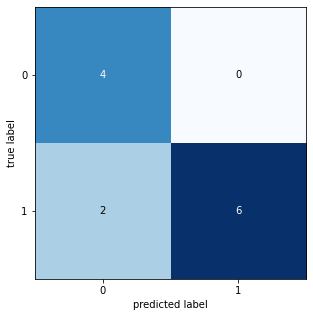

Running Time:  1.477356400000076
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



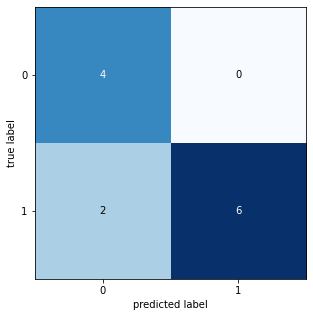

Running Time:  1.4861193000000412
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



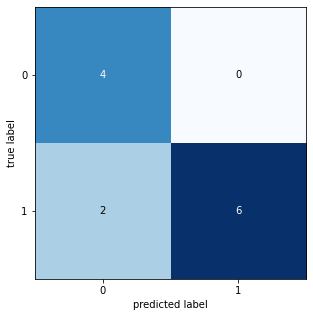

Running Time:  1.495298299999945
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



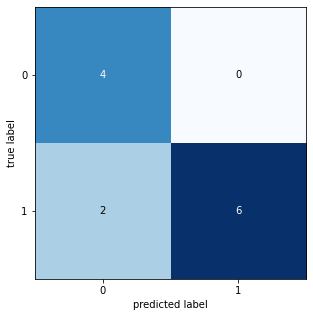

Running Time:  1.4979121999999734
gen terbaik : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 56

Generation : 3
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    rec

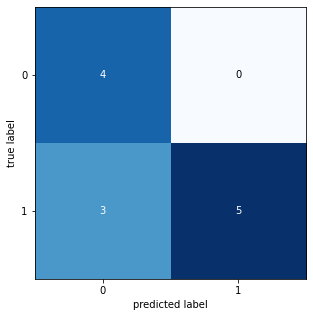

Running Time:  1.476332100000036
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



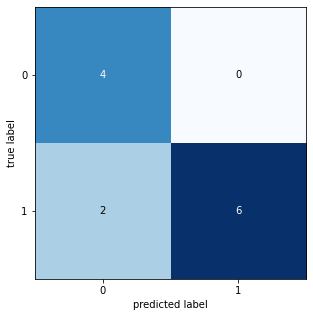

Running Time:  1.486244700000043
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



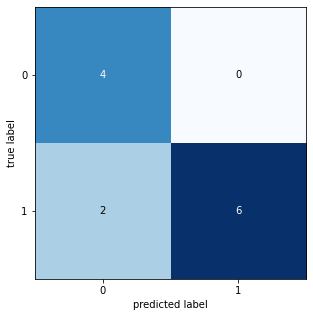

Running Time:  1.4813020999999935
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



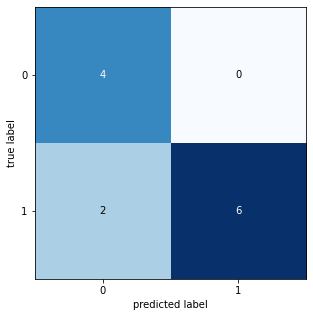

Running Time:  1.6634276999999429
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



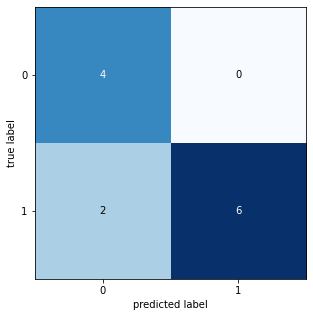

Running Time:  1.484671300000059
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



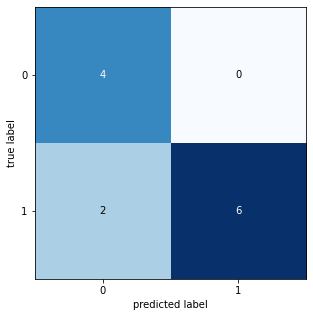

Running Time:  1.4886185000000296
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



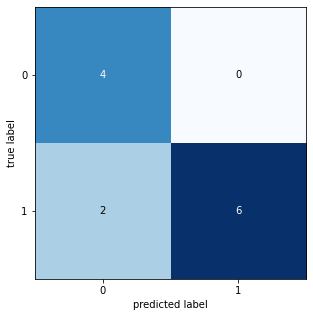

Running Time:  1.478299800000059
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



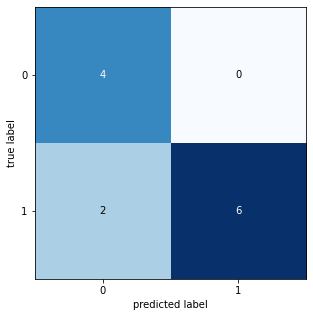

Running Time:  1.4662306999999828
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



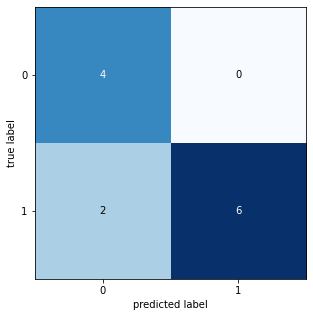

Running Time:  1.483034900000007
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



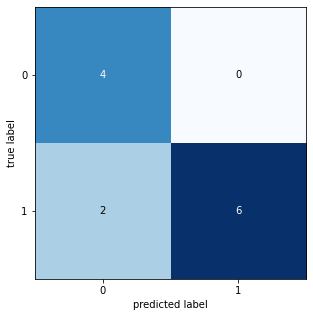

Running Time:  1.4743816000000152
gen terbaik : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 62

Generation : 4
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

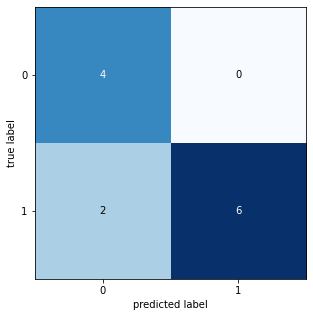

Running Time:  1.4825847999999269
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



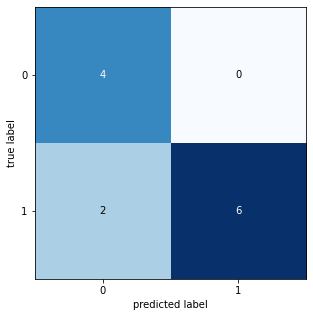

Running Time:  1.6528008000000227
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



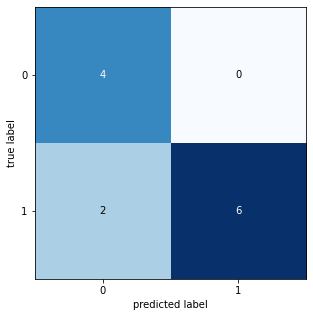

Running Time:  1.494247200000018
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



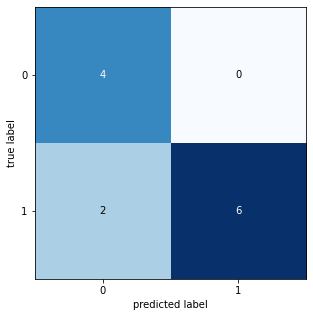

Running Time:  1.4721786000000066
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



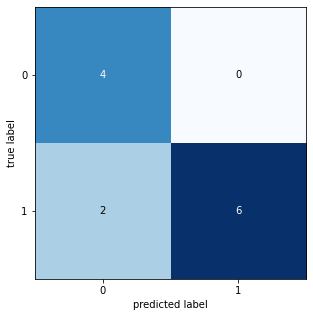

Running Time:  1.473888699999975
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



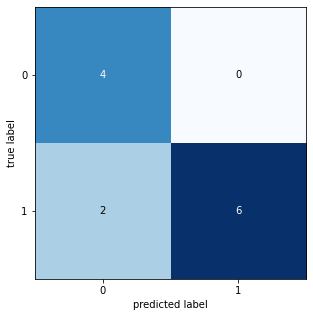

Running Time:  1.4786053999999922
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



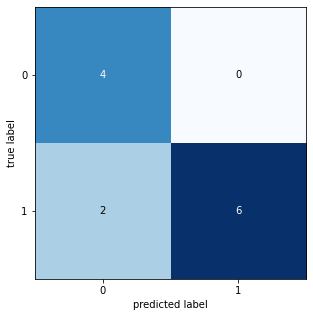

Running Time:  1.4576169000000618
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



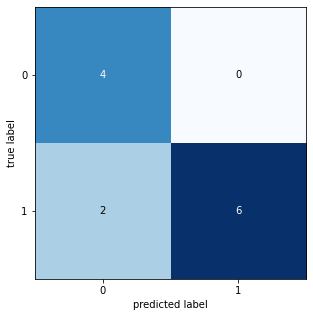

Running Time:  1.4788908000000447
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



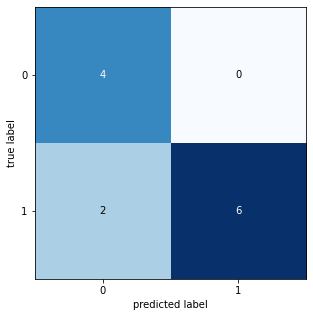

Running Time:  1.4640428000000156
gene : [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



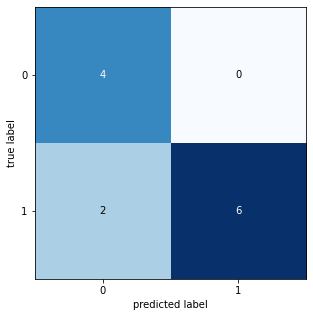

Running Time:  1.6415776999999707
gen terbaik : [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 59

Running Time:  76.33275270000001
colon + IG + GA Orde 3
Generation : 0
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.83333333

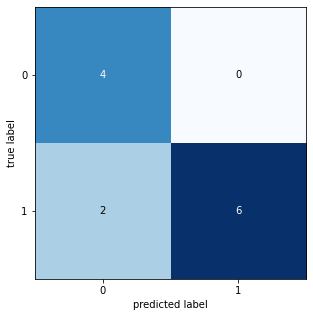

Running Time:  1.4767186999999922
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



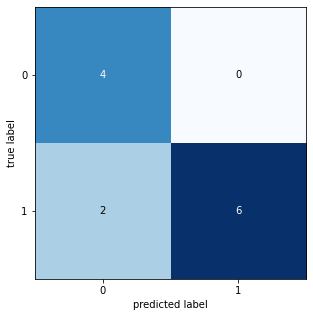

Running Time:  1.4749715000000378
gene : [1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



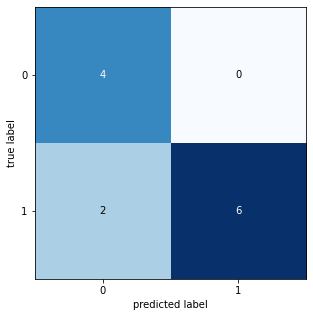

Running Time:  1.4833686000000625
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



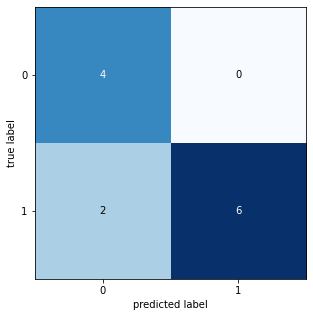

Running Time:  1.484587900000065
gene : [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



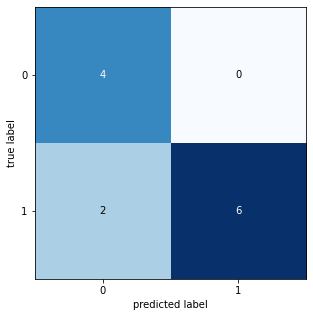

Running Time:  1.4750308000000132
gene : [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



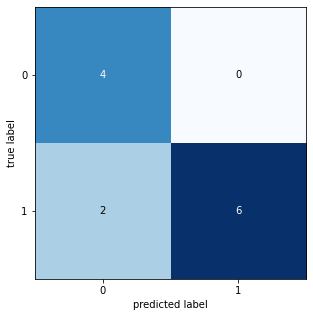

Running Time:  1.4734545000000026
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



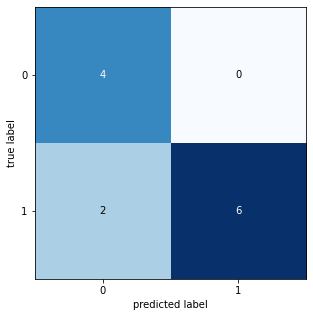

Running Time:  1.627449200000001
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



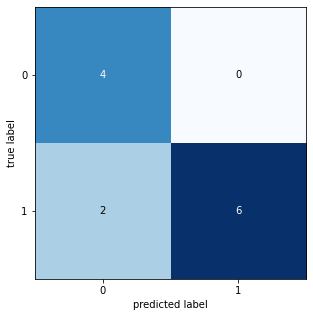

Running Time:  1.4698865999999953
gene : [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



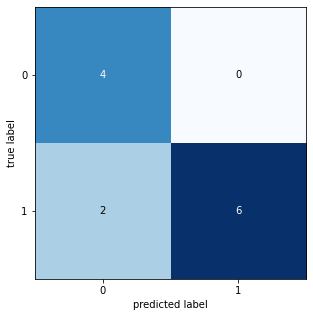

Running Time:  1.4711041000000478
gene : [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



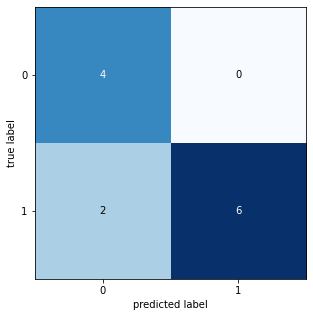

Running Time:  1.4690722000000278
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 44

Generation : 1
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

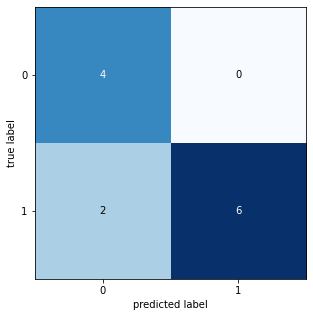

Running Time:  1.466615000000047
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



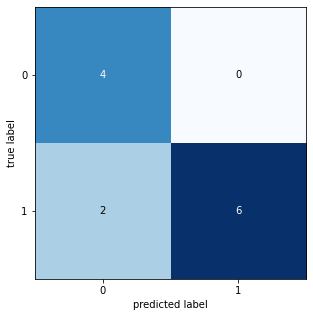

Running Time:  1.477679999999964
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



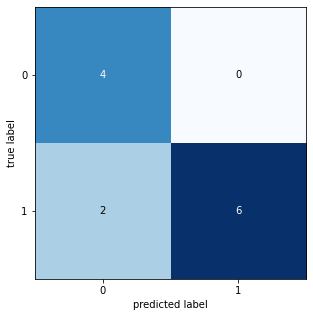

Running Time:  1.4773945000000595
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



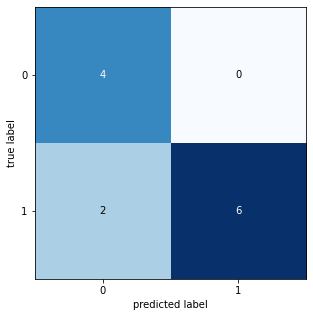

Running Time:  1.471263399999998
gene : [1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



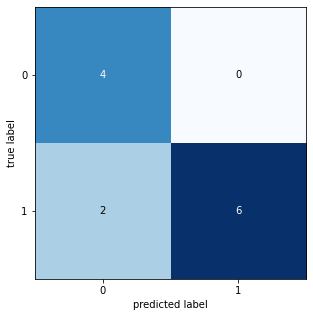

Running Time:  1.6557199999999739
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



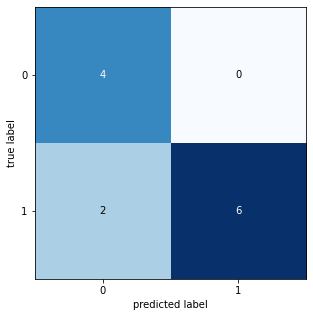

Running Time:  1.478554499999973
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



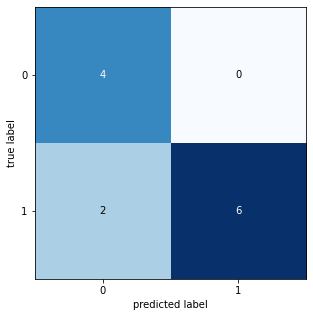

Running Time:  1.4766822000000275
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



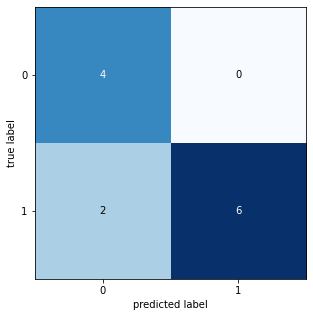

Running Time:  1.4800999000000274
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



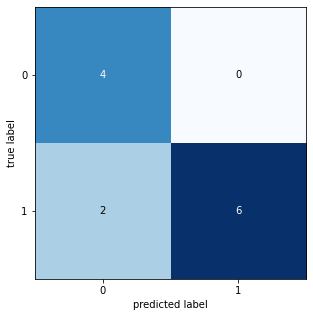

Running Time:  1.4668599000000313
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



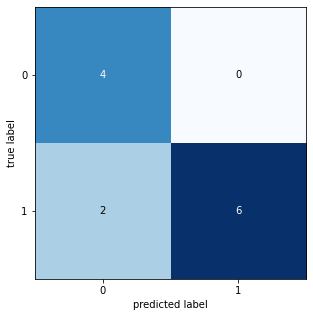

Running Time:  1.4645663000000013
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 44

Generation : 2
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

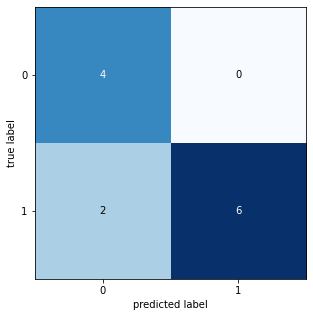

Running Time:  1.4599868999999899
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



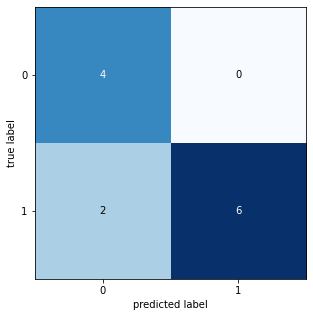

Running Time:  1.4670977999999195
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



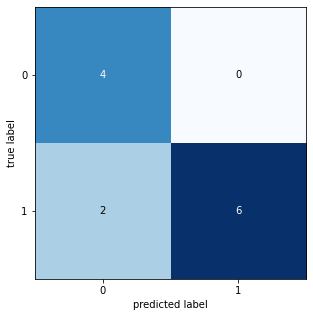

Running Time:  1.623223199999984
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



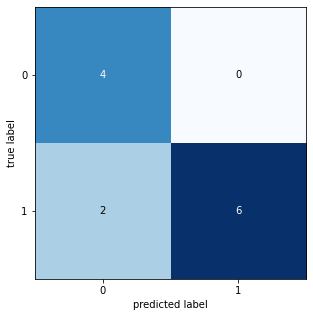

Running Time:  1.4850917999999638
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



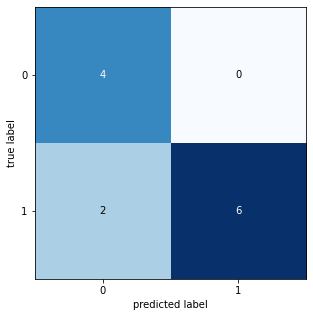

Running Time:  1.4782504000000927
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



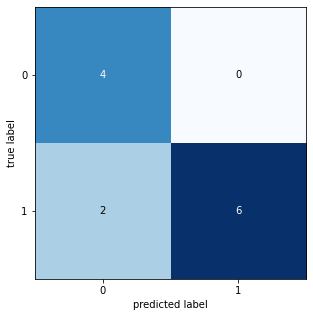

Running Time:  1.4631491999999753
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



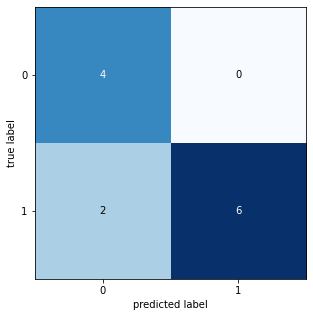

Running Time:  1.4681297000000768
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



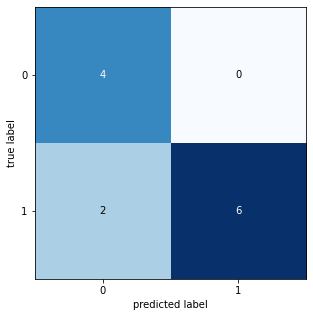

Running Time:  1.4723744000000352
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



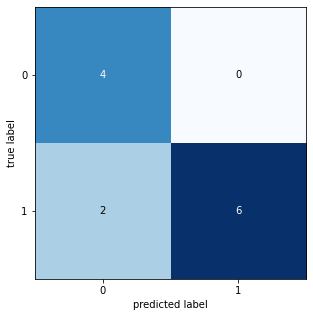

Running Time:  1.4645874000000276
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



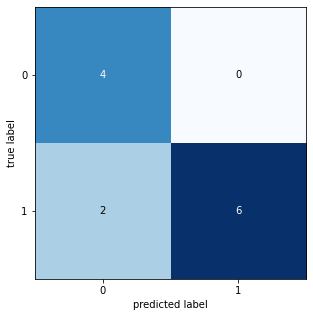

Running Time:  1.4822105000000647
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 46

Generation : 3
gene : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

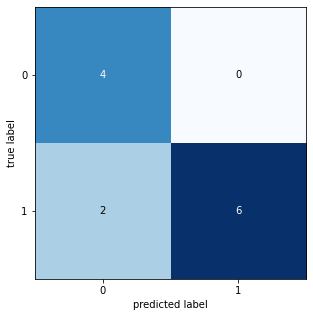

Running Time:  1.660247400000003
gene : [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



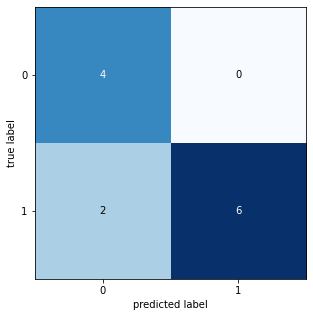

Running Time:  1.467765600000007
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



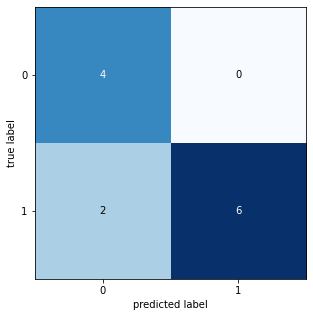

Running Time:  1.4627520000000231
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



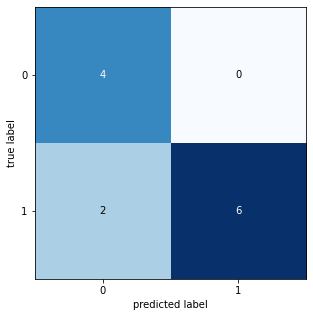

Running Time:  1.471897399999989
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



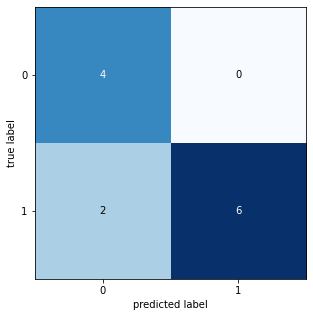

Running Time:  1.4686303999999382
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



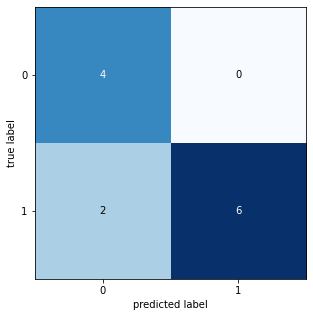

Running Time:  1.459118999999987
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



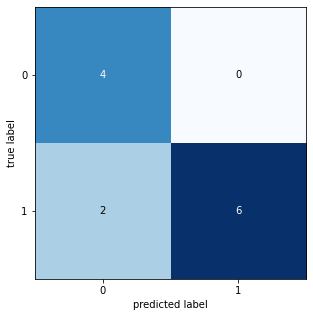

Running Time:  1.4703226000000313
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



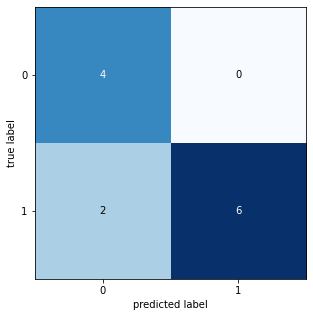

Running Time:  1.4612332999998898
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



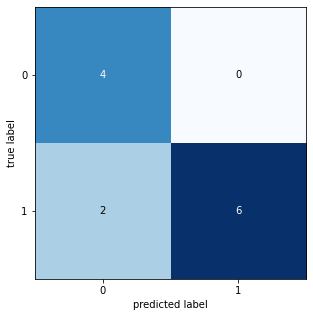

Running Time:  1.6608496999999716
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



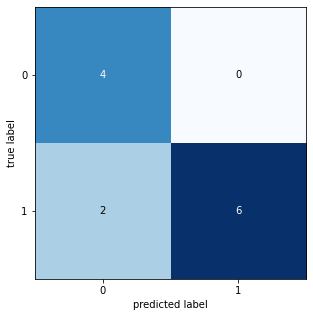

Running Time:  1.481667399999992
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 53

Generation : 4
gene : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

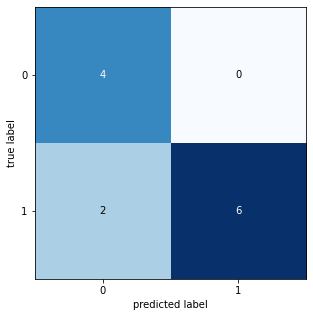

Running Time:  1.469436299999984
gene : [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



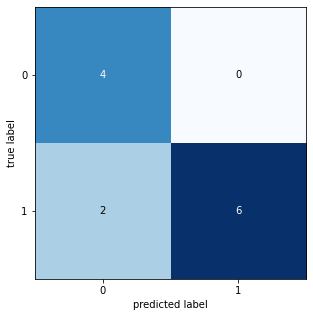

Running Time:  1.469194899999934
gene : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



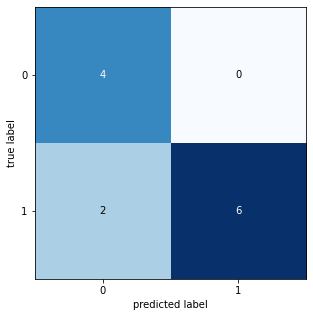

Running Time:  1.4773487999999588
gene : [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



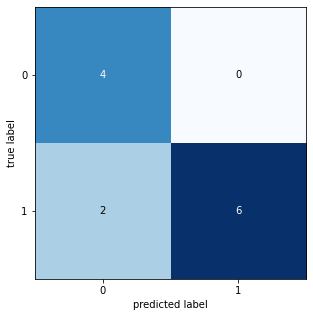

Running Time:  1.4662054000000353
gene : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



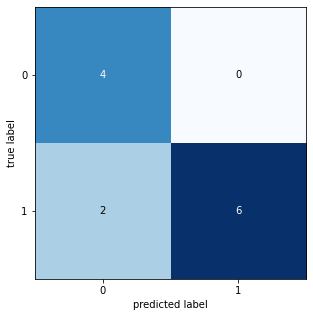

Running Time:  1.4724911999999222
gene : [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



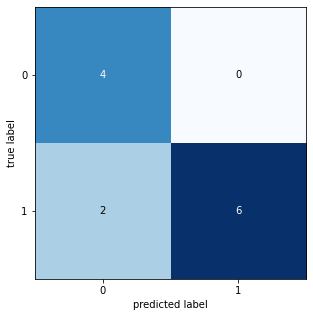

Running Time:  1.4702996999999414
gene : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



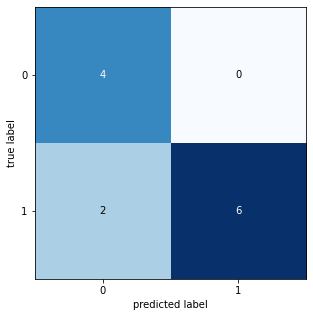

Running Time:  1.6298837999999023
gene : [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



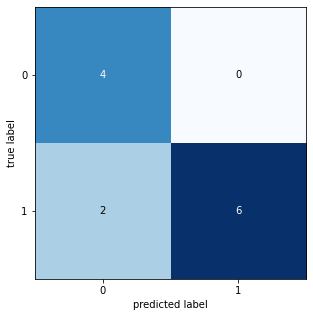

Running Time:  1.4585395999999946
gene : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



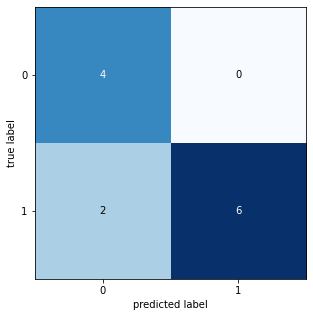

Running Time:  1.4633424999999534
gene : [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



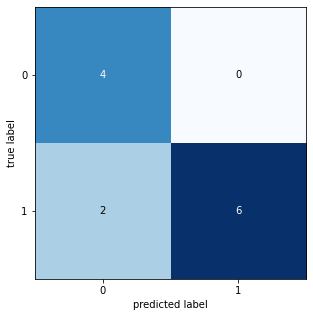

Running Time:  1.4637639000000036
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 53

Running Time:  75.49772559999997
colon + IG + GA Orde 4
Generation : 0
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.83333333

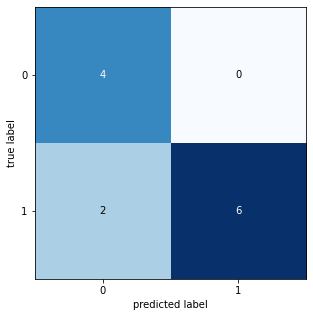

Running Time:  1.4814583000000994
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



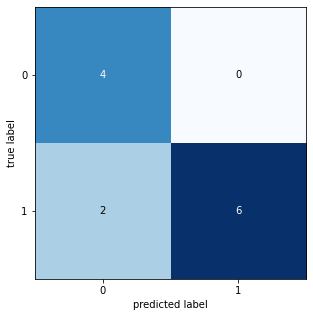

Running Time:  1.4801439999999957
gene : [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



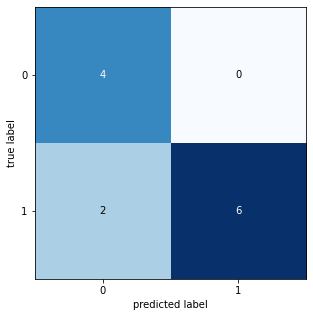

Running Time:  1.4595259999999826
gene : [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



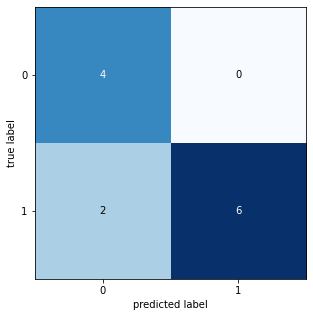

Running Time:  1.6312078999999358
gene : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



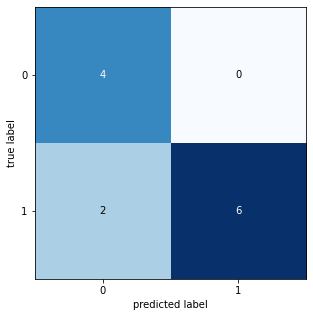

Running Time:  1.4682437000000164
gene : [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



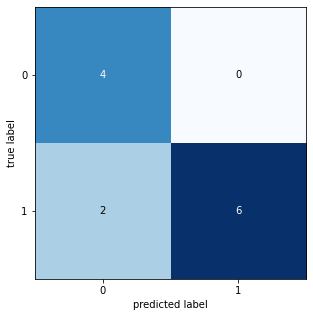

Running Time:  1.4688746000000492
gene : [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



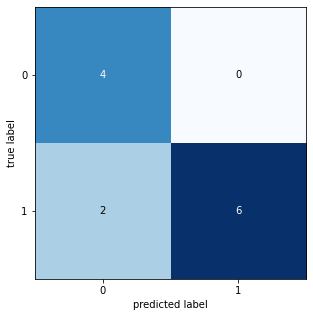

Running Time:  1.4666254999999637
gene : [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



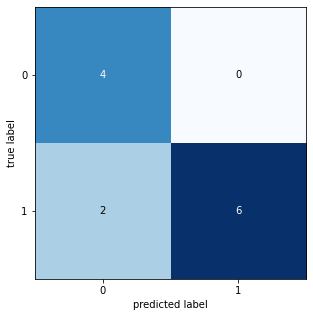

Running Time:  1.467602100000022
gene : [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



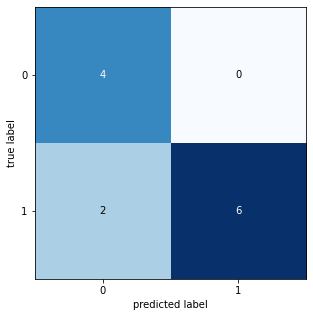

Running Time:  1.4889221000000816
gene : [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



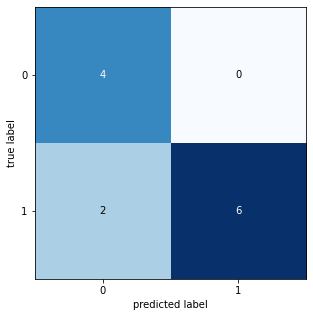

Running Time:  1.475559399999952
gen terbaik : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 55

Generation : 1
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

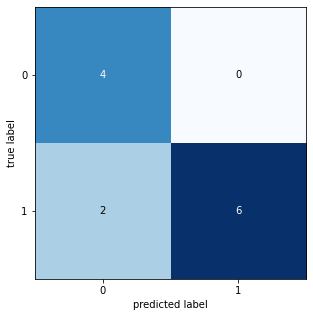

Running Time:  1.479825900000037
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



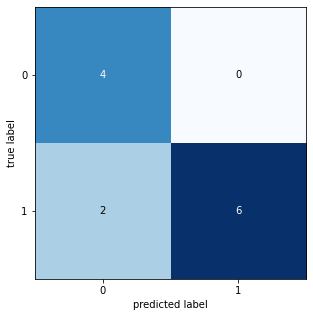

Running Time:  1.6318264999999883
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



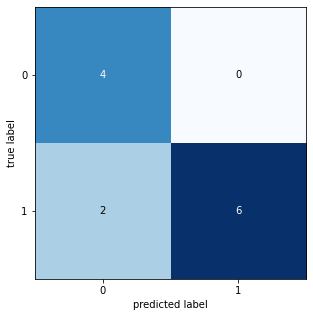

Running Time:  1.466985099999988
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



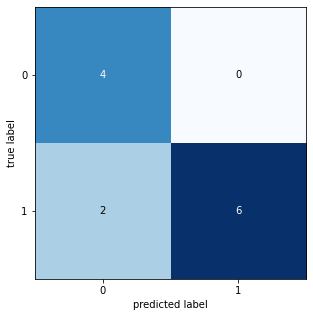

Running Time:  1.487845200000038
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



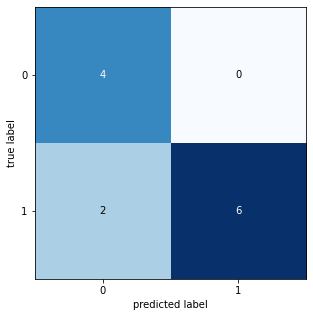

Running Time:  1.4871994000000086
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



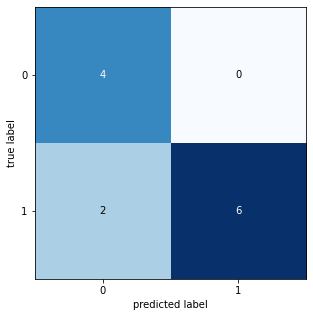

Running Time:  1.4733648999999787
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



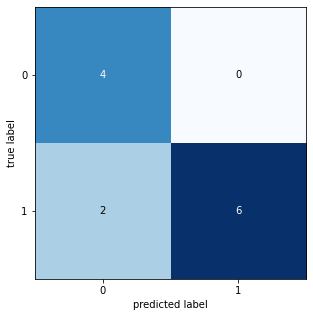

Running Time:  1.4810448999999153
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



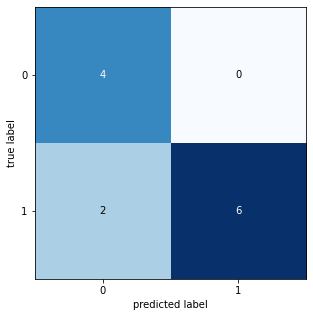

Running Time:  1.4816839000000073
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



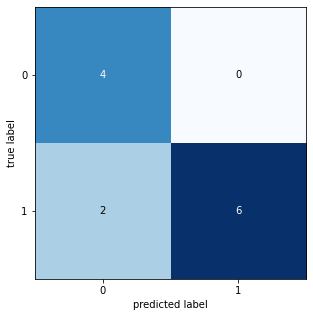

Running Time:  1.4720270000000255
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



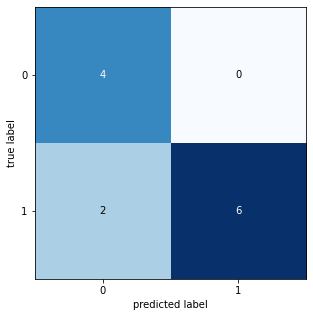

Running Time:  1.6438892999999553
gen terbaik : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 55

Generation : 2
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

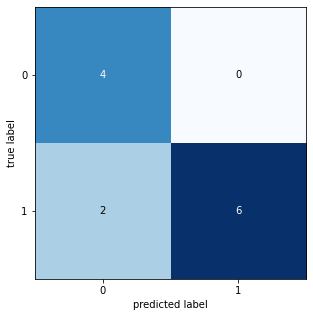

Running Time:  1.4932225000000017
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



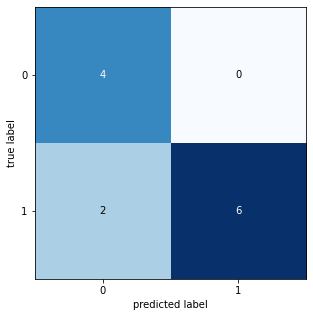

Running Time:  1.4725341000000753
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



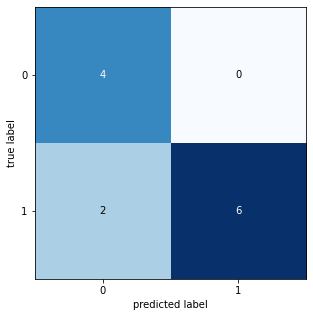

Running Time:  1.4869703000000527
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



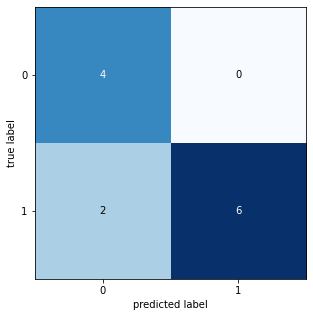

Running Time:  1.4838451000000532
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



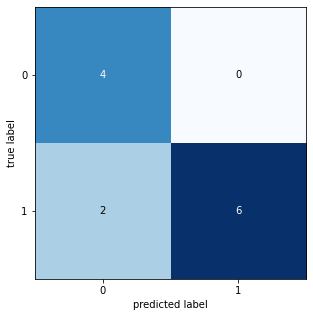

Running Time:  1.470105999999987
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



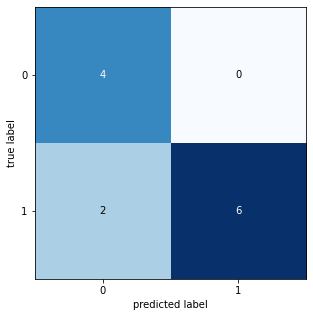

Running Time:  1.4809318999999732
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



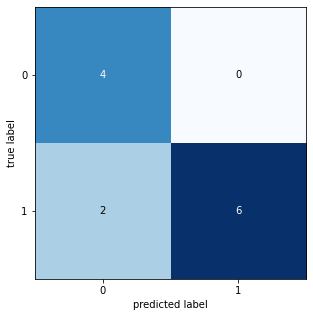

Running Time:  1.487068000000022
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



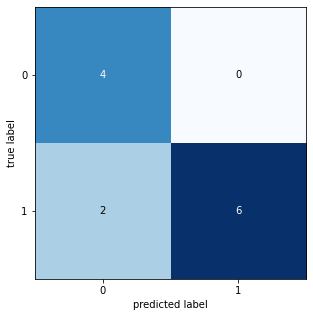

Running Time:  1.652862300000038
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



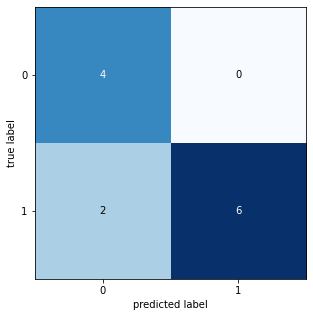

Running Time:  1.481034799999975
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



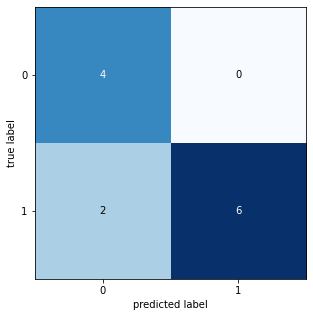

Running Time:  1.4760360999999875
gen terbaik : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 50

Generation : 3
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

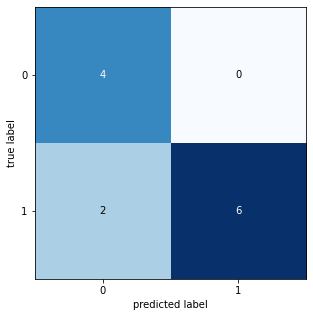

Running Time:  1.4779503999999406
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



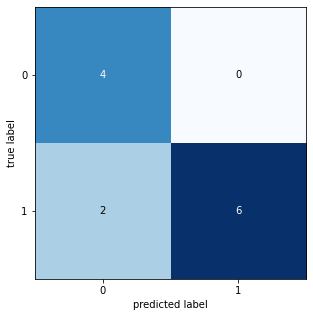

Running Time:  1.4794379999999592
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



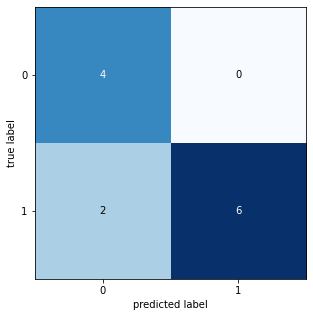

Running Time:  1.4775086000000783
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



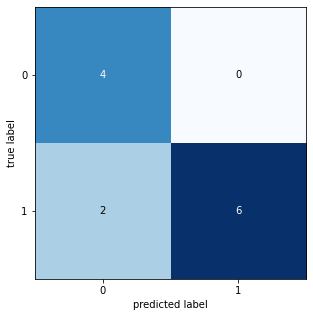

Running Time:  1.4839719000000287
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



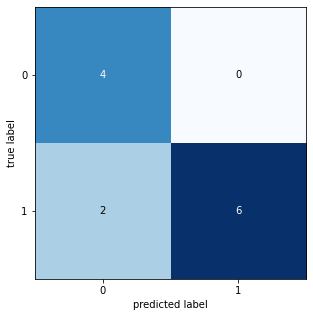

Running Time:  1.482295000000022
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



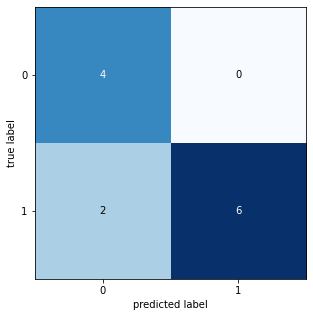

Running Time:  1.6344183999999586
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



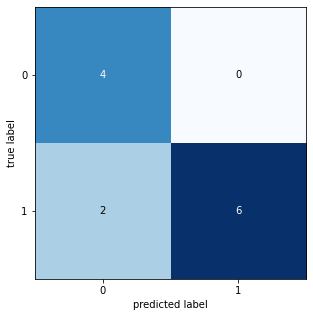

Running Time:  1.4708967999999913
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



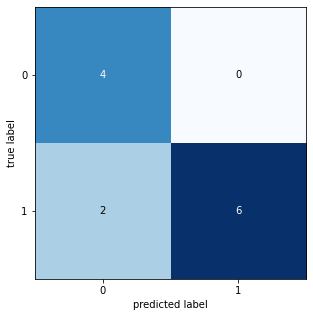

Running Time:  1.482656899999938
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



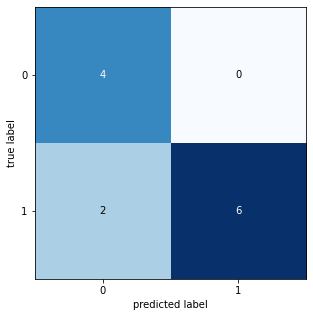

Running Time:  1.4677914999999757
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



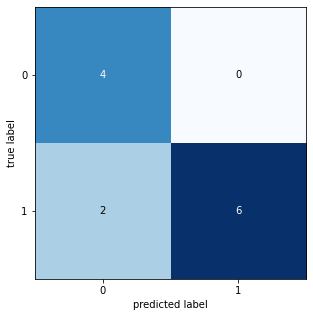

Running Time:  1.466258000000039
gen terbaik : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 53

Generation : 4
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

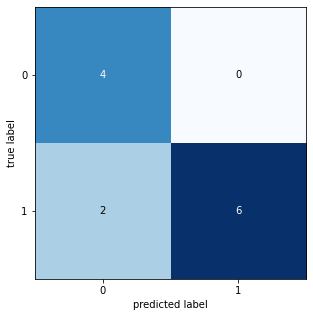

Running Time:  1.4851363999999876
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



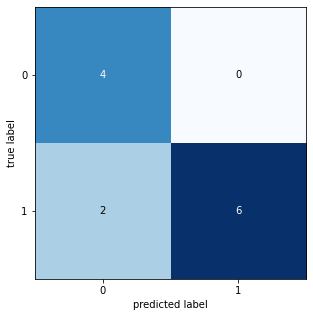

Running Time:  1.4837074999999231
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



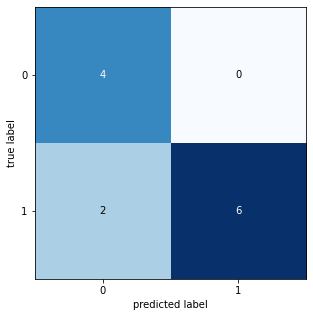

Running Time:  1.4648978999999827
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



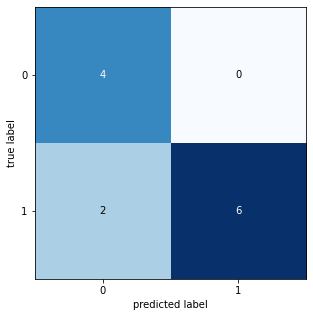

Running Time:  1.6414455000000316
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



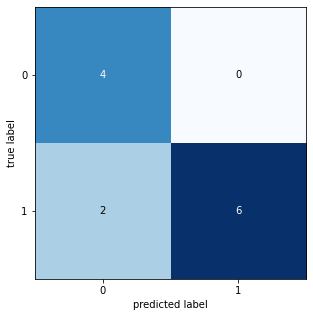

Running Time:  1.4905860000000075
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



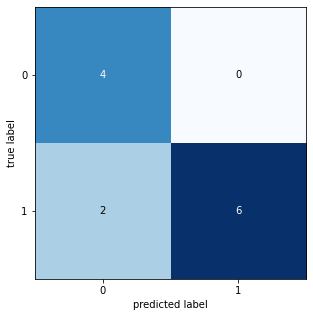

Running Time:  1.473113499999954
gene : [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



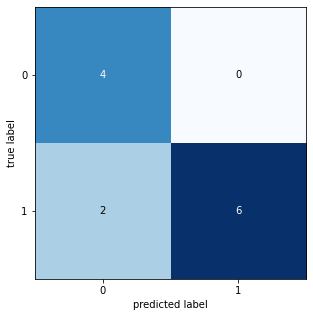

Running Time:  1.4957855000000109
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



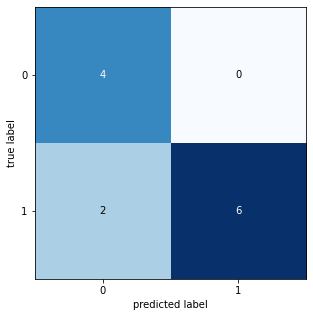

Running Time:  1.4701762000000826
gene : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



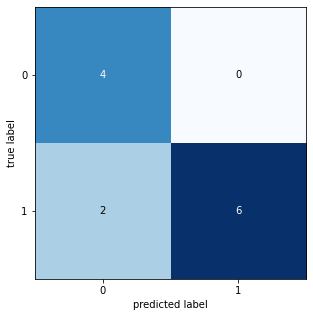

Running Time:  1.4758408000000145
gene : [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



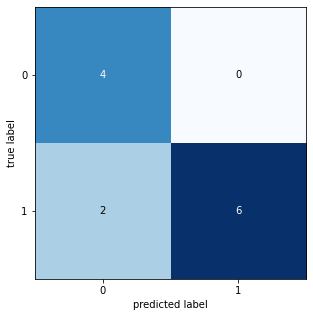

Running Time:  1.4944365999999718
gen terbaik : [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 51

Running Time:  75.8328406999999
Train :  [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test :  [ 1  4  5 17 27 31 37 40 43 48 58 61]
train:  (50, 101)
test:  (12, 101)
Running Time:  1.8692207999999937
colon + IG Orde 2
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
           

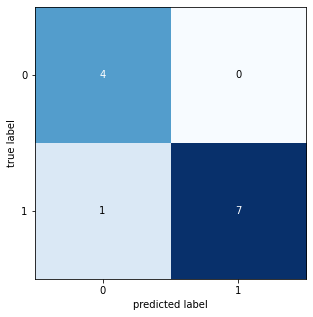

Running Time:  1.458209399999987
colon + IG Orde 3
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



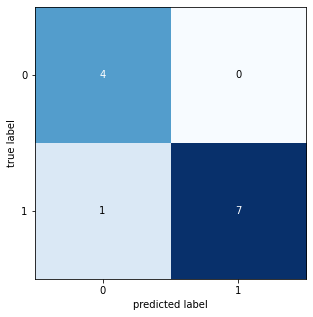

Running Time:  1.6643942000000607
colon + IG Orde 4
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



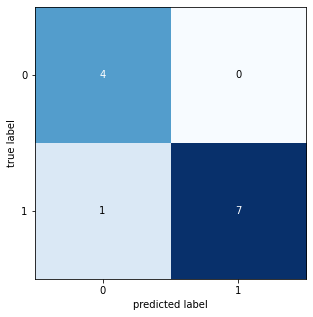

Running Time:  1.5134001999999782
colon + IG + GA Orde 2
Generation : 0
gene : [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



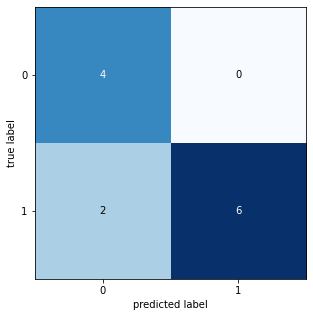

Running Time:  1.4685879999999543
gene : [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



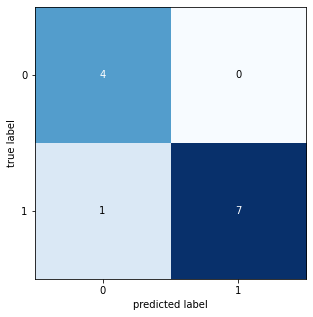

Running Time:  1.4496540999999752
gene : [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



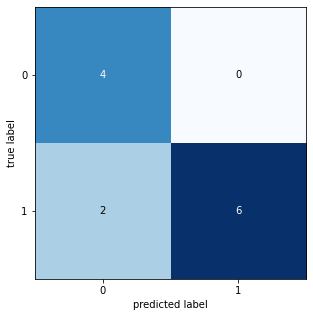

Running Time:  1.4766803999999638
gene : [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



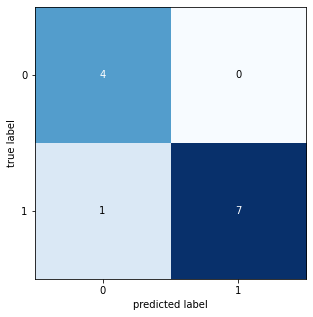

Running Time:  1.455095799999981
gene : [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



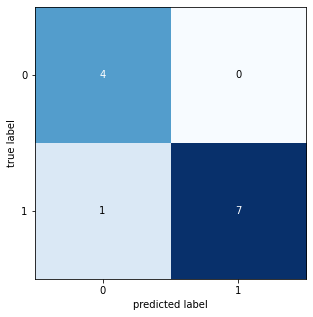

Running Time:  1.4500649000000294
gene : [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



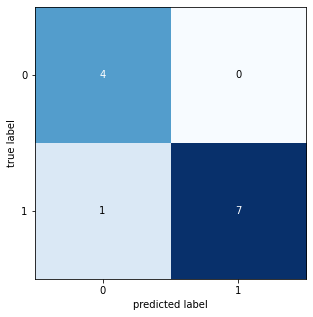

Running Time:  1.6428448000000344
gene : [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



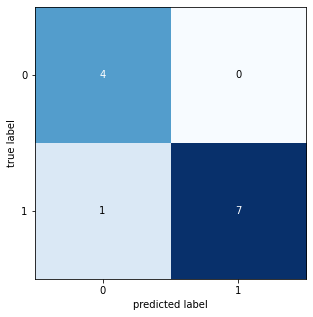

Running Time:  1.4578334000000268
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



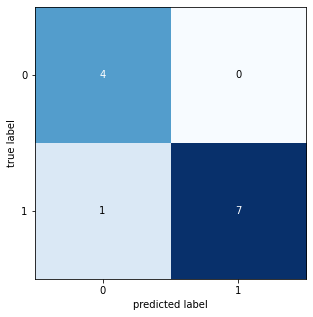

Running Time:  1.4602412000000413
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



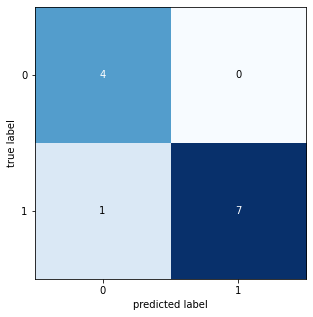

Running Time:  1.4608547000000272
gene : [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



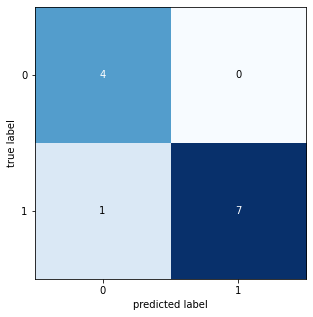

Running Time:  1.4534452000000329
gen terbaik : [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
F-1 Score terbaik : 0.9111111111111112  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 55

Running Time:  14.96004849999997
colon + IG + GA Orde 3
Generation : 0
gene : [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.91666666

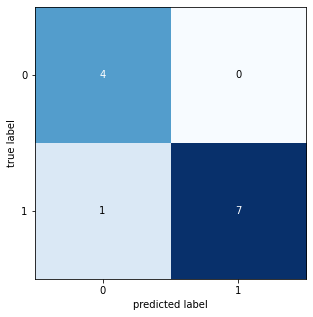

Running Time:  1.4783154000000422
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



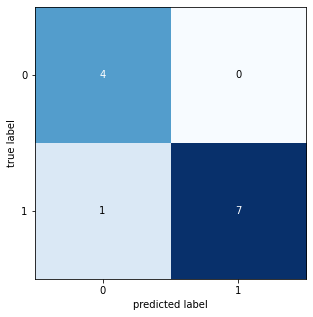

Running Time:  1.4690166000000318
gene : [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



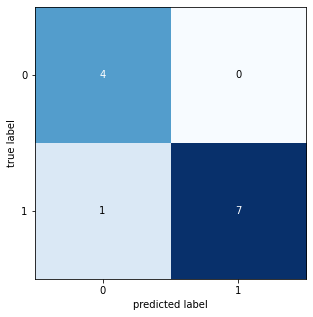

Running Time:  1.63726029999998
gene : [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



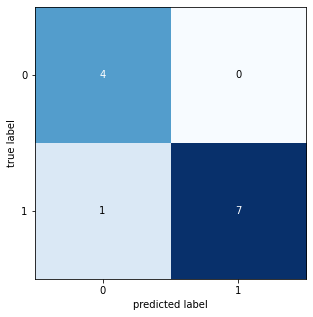

Running Time:  1.4782311000000163
gene : [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



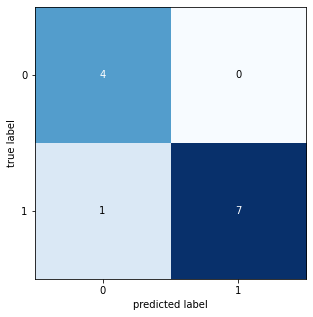

Running Time:  1.4752233000000388
gene : [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



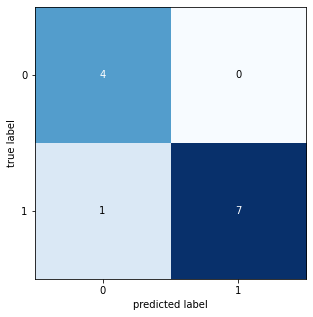

Running Time:  1.467600999999945
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



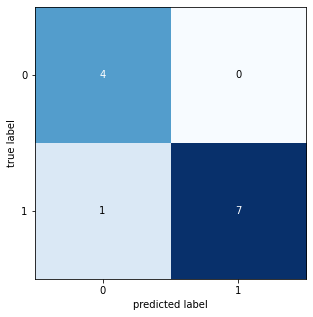

Running Time:  1.466485900000066
gene : [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



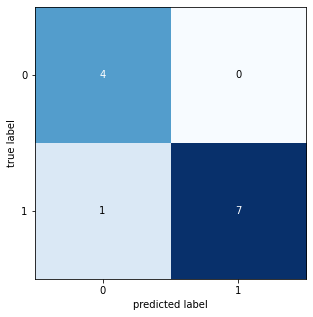

Running Time:  1.474401499999999
gene : [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



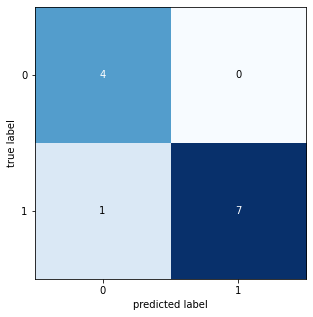

Running Time:  1.4785194999999476
gene : [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



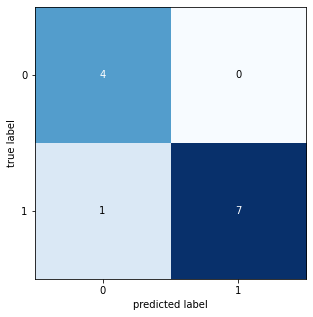

Running Time:  1.4740808000000243
gen terbaik : [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.9111111111111112  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 51

Running Time:  15.087929200000076
colon + IG + GA Orde 4
Generation : 0
gene : [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666

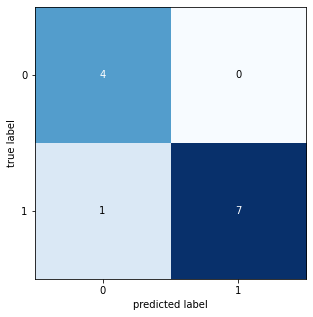

Running Time:  1.4753762999999935
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



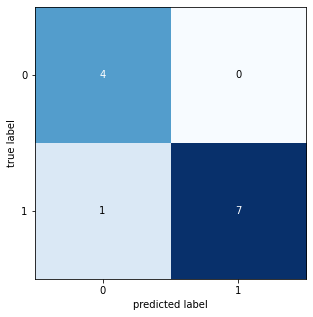

Running Time:  1.4635160999999925
gene : [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



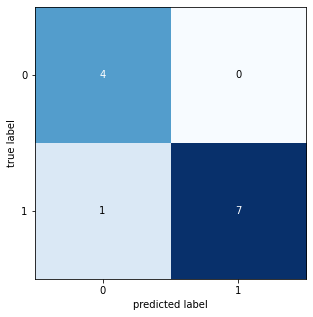

Running Time:  1.4805645999999797
gene : [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



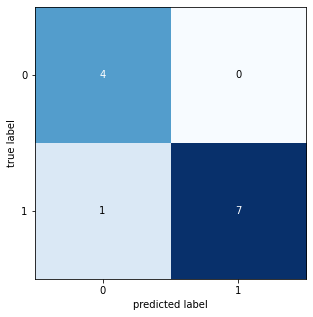

Running Time:  1.4746864999999616
gene : [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



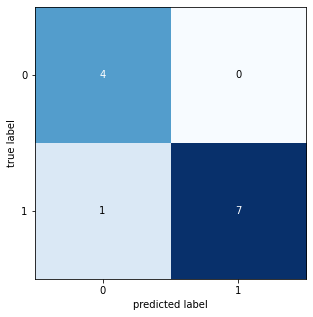

Running Time:  1.4507102999999688
gene : [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



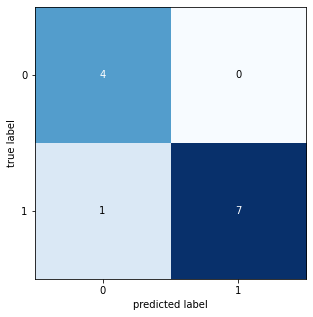

Running Time:  1.4870618999999579
gene : [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



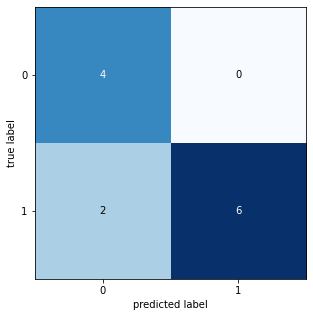

Running Time:  1.4872345999999652
gene : [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



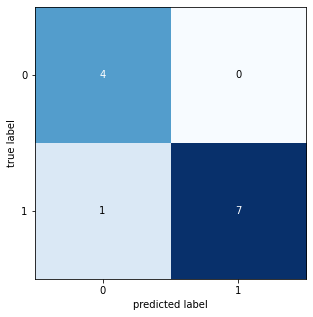

Running Time:  1.6084441000000425
gene : [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



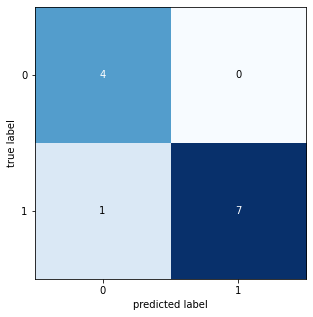

Running Time:  1.4751068000000487
gene : [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



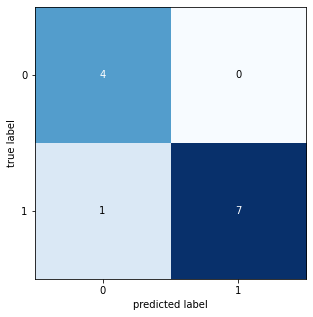

Running Time:  1.4811856000000034
gen terbaik : [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
F-1 Score terbaik : 0.9111111111111112  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 53

Running Time:  15.245285800000033
Avg accuracy colon cancer + IG orde 2 :  0.841025641025641
Avg F1 score colon cancer + IG orde 2 :  0.8086017740429506
Avg running time colon cancer + IG orde 2 :  3.4108564400000034
Avg accuracy colon cancer + IG orde 3 :  0.841025641025641
Avg F1 score colon cancer + IG orde 3 :  0.8086017740429506
Avg running time colon cancer + IG orde 3 :  3.458145160000033
Avg accuracy colon cancer + IG orde 4 :  0.841025641025641
Avg F1 score colon cancer + IG orde 4 :  0.818141432011401
Avg running time colon cancer +

In [9]:
start = timeit.default_timer()
akurasi_IG_2,f1_IG_2,rt_IG_2 = [],[],[]
akurasi_IG_3,f1_IG_3,rt_IG_3 = [],[],[]
akurasi_IG_4,f1_IG_4,rt_IG_4 = [],[],[]

akurasi_IG_GA_2,f1_IG_GA_2,fitur_IG_GA_2,rt_IG_GA_2 = [],[],[],[]
akurasi_IG_GA_3,f1_IG_GA_3,fitur_IG_GA_3,rt_IG_GA_3 = [],[],[],[]
akurasi_IG_GA_4,f1_IG_GA_4,fitur_IG_GA_4,rt_IG_GA_4 = [],[],[],[]

#Melakukan proses K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
kf.get_n_splits(data_new_colon)
X = data_new_colon.copy().iloc[:, 0:len(data_new_colon.columns)-1].values
Y = data_new_colon.copy().iloc[:, len(data_new_colon.columns)-1].values
for train_index, test_index in kf.split(X,Y):
    print("Train : ", train_index, "Test : ", test_index)
    data_train, data_test, y_train, y_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index]), Y[train_index], Y[test_index]
    data_train['label'] = y_train
    data_test['label'] = y_test
    data_train, data_test, rt_ig = InformationGain(data_train.copy(), data_test.copy())
    print("colon + IG Orde 2")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "colon cancer", 2)
    akurasi_IG_2.append(acc)
    f1_IG_2.append(f1)
    rt_IG_2.append(rt+rt_ig)
    print("colon + IG Orde 3")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "colon cancer", 3)
    akurasi_IG_3.append(acc)
    f1_IG_3.append(f1)
    rt_IG_3.append(rt+rt_ig)
    print("colon + IG Orde 4")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "colon cancer", 4)
    akurasi_IG_4.append(acc)
    f1_IG_4.append(f1)
    rt_IG_4.append(rt+rt_ig)
    
    print("colon + IG + GA Orde 2")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 2)
    akurasi_IG_GA_2.append(acc)
    f1_IG_GA_2.append(f1)
    fitur_IG_GA_2.append(fitur)
    rt_IG_GA_2.append(rt+rt_ig)
    print("colon + IG + GA Orde 3")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 3)
    akurasi_IG_GA_3.append(acc)
    f1_IG_GA_3.append(f1)
    fitur_IG_GA_3.append(fitur)
    rt_IG_GA_3.append(rt+rt_ig)
    print("colon + IG + GA Orde 4")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 4)
    akurasi_IG_GA_4.append(acc)
    f1_IG_GA_4.append(f1)
    fitur_IG_GA_4.append(fitur)
    rt_IG_GA_4.append(rt+rt_ig)
    
akurasi_IG_2,f1_IG_2,rt_IG_2 = np.array(akurasi_IG_2),np.array(f1_IG_2),np.array(rt_IG_2)
akurasi_IG_3,f1_IG_3,rt_IG_3 = np.array(akurasi_IG_3),np.array(f1_IG_3),np.array(rt_IG_3)
akurasi_IG_4,f1_IG_4,rt_IG_4 = np.array(akurasi_IG_4),np.array(f1_IG_4),np.array(rt_IG_4)

akurasi_IG_GA_2,f1_IG_GA_2,fitur_IG_GA_2,rt_IG_GA_2 = np.array(akurasi_IG_GA_2),np.array(f1_IG_GA_2),np.array(fitur_IG_GA_2),np.array(rt_IG_GA_2)
akurasi_IG_GA_3,f1_IG_GA_3,fitur_IG_GA_3,rt_IG_GA_3 = np.array(akurasi_IG_GA_3),np.array(f1_IG_GA_3),np.array(fitur_IG_GA_3),np.array(rt_IG_GA_3)
akurasi_IG_GA_4,f1_IG_GA_4,fitur_IG_GA_4,rt_IG_GA_4 = np.array(akurasi_IG_GA_4),np.array(f1_IG_GA_4),np.array(fitur_IG_GA_4),np.array(rt_IG_GA_4)

#Print Result
print('===============================================================================================================================================================================================================')
print('Avg accuracy colon cancer + IG orde 2 : ', akurasi_IG_2.mean())
print('Avg F1 score colon cancer + IG orde 2 : ', f1_IG_2.mean())
print('Avg running time colon cancer + IG orde 2 : ', rt_IG_2.mean())
print('Avg accuracy colon cancer + IG orde 3 : ', akurasi_IG_3.mean())
print('Avg F1 score colon cancer + IG orde 3 : ', f1_IG_3.mean())
print('Avg running time colon cancer + IG orde 3 : ', rt_IG_3.mean())
print('Avg accuracy colon cancer + IG orde 4 : ', akurasi_IG_4.mean())
print('Avg F1 score colon cancer + IG orde 4 : ', f1_IG_4.mean())
print('Avg running time colon cancer + IG orde 4 : ', rt_IG_4.mean())
print('===============================================================================================================================================================================================================')
print('Avg accuracy colon cancer + IG + GA orde 2 : ', akurasi_IG_GA_2.mean())
print('Avg F1 score colon cancer + IG + GA orde 2 : ', f1_IG_GA_2.mean())
print('Avg Features colon cancer + IG + GA orde 2 : ', fitur_IG_GA_2.mean())
print('Avg running time colon cancer + IG + GA orde 2 : ', rt_IG_GA_2.mean())
print('Avg accuracy colon cancer + IG + GA orde 3 : ', akurasi_IG_GA_3.mean())
print('Avg F1 score colon cancer + IG + GA orde 3 : ', f1_IG_GA_3.mean())
print('Avg Features colon cancer + IG + GA orde 3 : ', fitur_IG_GA_3.mean())
print('Avg running time colon cancer + IG + GA orde 3 : ', rt_IG_GA_3.mean())
print('Avg accuracy colon cancer + IG + GA orde 4 : ', akurasi_IG_GA_4.mean())
print('Avg F1 score colon cancer + IG + GA orde 4 : ', f1_IG_GA_4.mean())
print('Avg Features colon cancer + IG + GA orde 4 : ', fitur_IG_GA_4.mean())
print('Avg running time colon cancer + IG + GA orde 4 : ', rt_IG_GA_4.mean())
print()
stop = timeit.default_timer()
print("Overall Running Time : ", stop-start)